In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import re
import string
import nltk
import tensorflow as tf
from time import time
# import Tokenizer method from nltk
from nltk.tokenize import TweetTokenizer,word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report

from gensim.models import Word2Vec

from xgboost import XGBClassifier as XGBoostClassifier

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

%matplotlib inline

In [2]:
import random
seed = 666
random.seed(seed)

In [3]:
#load the data
data = pd.read_csv('C://Users//Naveena//Documents//EmotionAnalysis_DataSet/text-query-tweets_75k.csv')
data.head()
data.dtypes

Datetime          object
Tweet Id           int64
Place             object
Text              object
Username          object
FollowersCount     int64
FriendsCount       int64
Language          object
Hashtag           object
Retweet Count      int64
Likes Count        int64
dtype: object

In [4]:
def plot_frequency_charts(df, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Coronavirus pandemic'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

C:\Users\Naveena\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


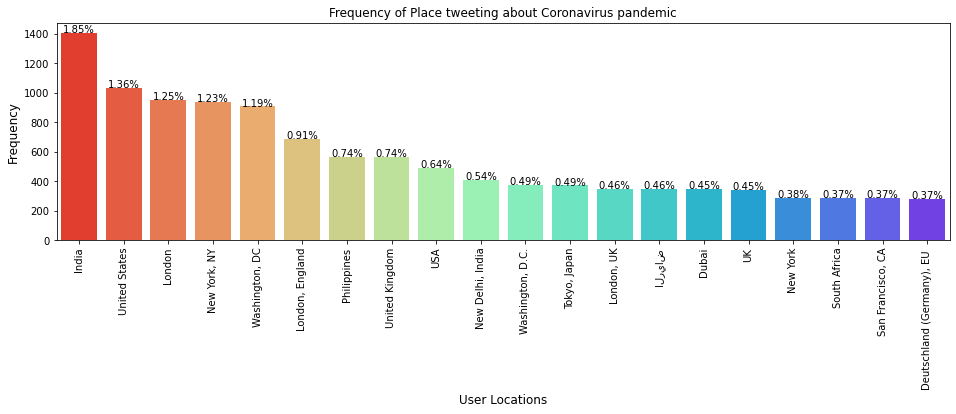

In [5]:
plot_frequency_charts(data, 'Place', 'User Locations', 'rainbow_r')

In [6]:
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [7]:
udf = return_unique_values(data)
print(data)

                        Datetime             Tweet Id  \
0      2021-05-31 23:57:57+00:00  1399515526783774728   
1      2021-05-31 23:41:40+00:00  1399511428613111808   
2      2021-05-31 23:40:00+00:00  1399511006284378113   
3      2021-05-31 23:31:00+00:00  1399508741393944581   
4      2021-05-31 23:28:34+00:00  1399508128954081281   
...                          ...                  ...   
75887  2021-01-01 00:07:33+00:00  1344797371465564160   
75888  2021-01-01 00:05:00+00:00  1344796730609569792   
75889  2021-01-01 00:02:49+00:00  1344796180270751749   
75890  2021-01-01 00:01:59+00:00  1344795972426215432   
75891  2021-01-01 00:00:16+00:00  1344795539582427137   

                         Place  \
0               East Coast USA   
1                    Australia   
2                San Francisco   
3               Pittsburgh, PA   
4      Sydney, New South Wales   
...                        ...   
75887                      NaN   
75888           Washington, DC   
75889    

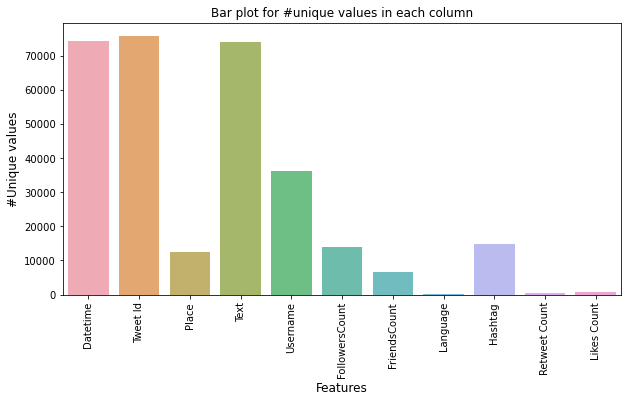

In [8]:
f, ax = plt.subplots(1,1, figsize=(10,5))#plt.figure(figsize=(10, 5))

sns.barplot(x=udf['Features'], y=udf['Uniques'], alpha=0.8)
plt.title('Bar plot for #unique values in each column')
plt.ylabel('#Unique values', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [9]:
def plot_frequency_charts(df, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Corona'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()
    

C:\Users\Naveena\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


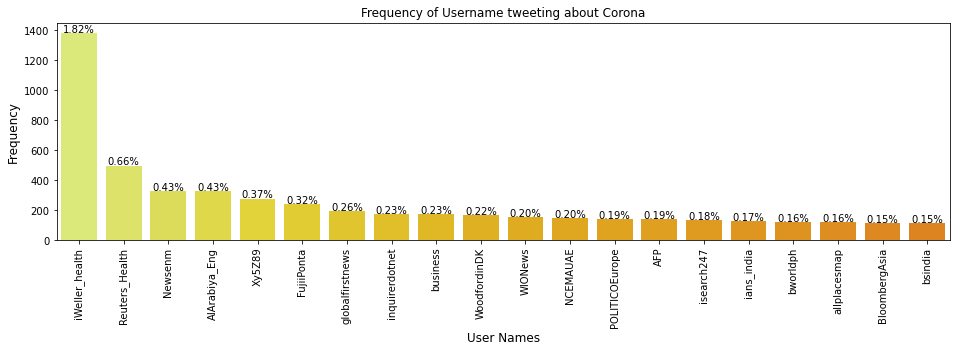

In [10]:
plot_frequency_charts(data, 'Username', 'User Names','Wistia')

In [11]:
from string import punctuation
from nltk.corpus import stopwords
print(stopwords.words('english')[10:15])

def punctuation_stopwords_removal(sms):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in sms if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_sms = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_sms

["you've", "you'll", "you'd", 'your', 'yours']


In [12]:
from wordcloud import WordCloud, STOPWORDS



def draw_word_cloud(df, location, title):
    loc_df = df.loc[df.Place==location]
    loc_df.loc[:, 'Text'] = loc_df['Text'].apply(punctuation_stopwords_removal)
    word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(loc_df['Text']))
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(word_cloud)
    plt.show()
    

C:\Users\Naveena\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


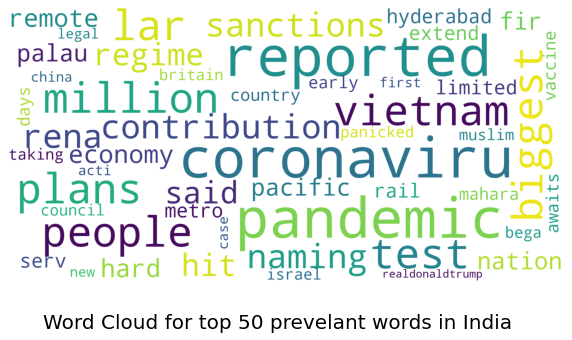

In [13]:
draw_word_cloud(data, 'India', 'Word Cloud for top 50 prevelant words in India')

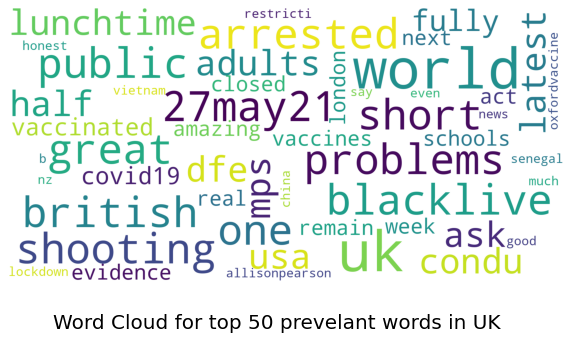

In [14]:
draw_word_cloud(data, 'UK', 'Word Cloud for top 50 prevelant words in UK')

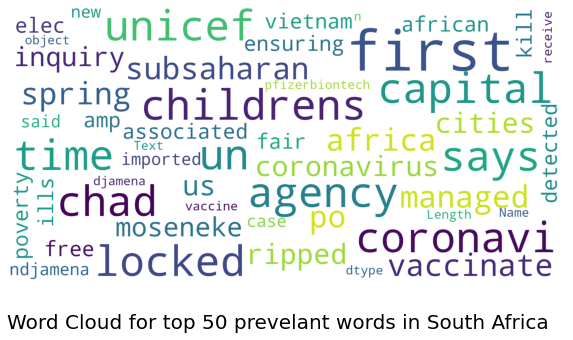

In [15]:
draw_word_cloud(data, 'South Africa', 'Word Cloud for top 50 prevelant words in South Africa')

C:\Users\Naveena\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


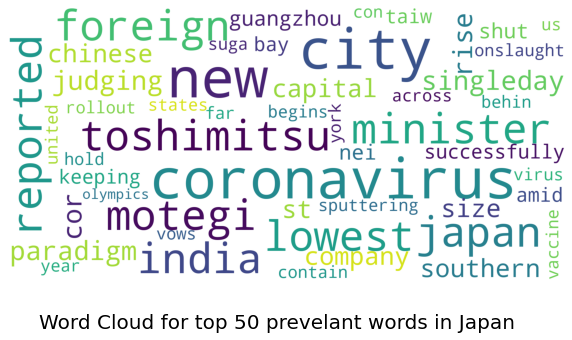

In [70]:
draw_word_cloud(data, 'Tokyo, Japan', 'Word Cloud for top 50 prevelant words in Japan')

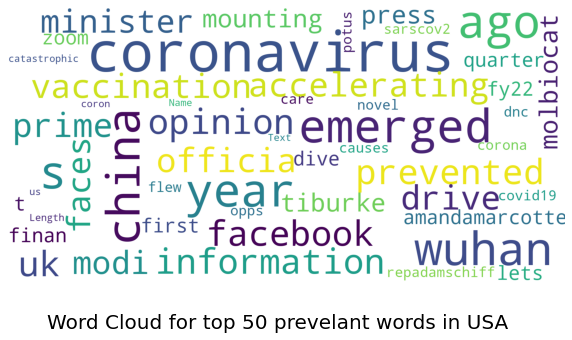

In [17]:
draw_word_cloud(data, 'USA', 'Word Cloud for top 50 prevelant words in USA')

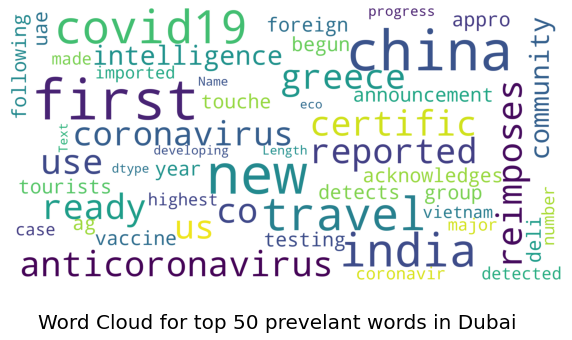

In [18]:
draw_word_cloud(data, 'Dubai', 'Word Cloud for top 50 prevelant words in Dubai')

In [19]:
# !pip install -U textblob
#!pip install text2emotion
#!pip install nrclex
#!pip install gensim
#!pip install xgboost
#!pip uninstall xgboost
#!pip install xgboost==1.4.2
#!pip install tensorflow

In [20]:
data['Text'].astype('str').value_counts()

In its July 2020 report on #Yemen's situation : the @WorldBank stated that the fuel crisis caused by US-Saudi blockade continued with no improvement, disrupting basic services, facing #Coronavirus efforts and humanitarian operations activities  #USADetainsOilShips                                                 432
Yoga guru Ramdev-run Patanjali has claimed that its Ayurvedic medicine 'Coronil' can help cure COVID-19 caused by the novel coronavirus.\n#Patanjalis_EvidenceBased_Medicine4Corona\n\n#PatanjaliCoronil                                                                                                                 159
SARS-CoV-2, the coronavirus which causes COVID-19, does not care whether or not we are weary of this global pandemic.\n\nIts only objective is to survive by finding a host and replicating.\n\nCoronavirus Dashboard: https://t.co/M1DKt1vBeF                                                                            63
Covid is likely to persist once its pandemic phas

In [21]:
text= data.Text

In [22]:
def clean_text(df):
    all_reviews = list()
    lines = data["Text"].values.tolist()
    for text in lines:
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        words = [w for w in words if not w in stop_words]
       # lemmatizer = WordNetLemmatizer()
       # tokenized = [lemmatizer.lemmatize(w, pos='a') for w in words]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

all_reviews = clean_text(data.Text)
all_reviews[0:20]

['mostrecent guidance updated last december equal employment opportunity commission said employers legally require workers vaccinated coronavirus',
 'dog breakfast aust govt went wrong aged care covid response vic latest outbreak exposes failure fully protect fed run aged care homes woman lost parents coronavirus adds criticism vaccination strategy',
 'californians headed campgrounds beaches restaurants long holiday weekend state prepared shed coronavirus rules',
 'pennsylvania lifted nearly coronavirus restrictions leading memorial day resembling years past',
 'not japan cancel games tokyo kept tentative grip coronavirus outbreak could change everything',
 'victoria reported three new locally acquired coronavirus cases taking state outbreak casesa total nine local cases recorded monday included six flagged government daily press conference yesterday',
 'mr sylvester head housing options bristol city council said homelessness surged lockdown biggest rise third coronavirus took toll fam

In [23]:
data["cleaned_Text"] = all_reviews
data.head()

Datetime             Tweet Id                    Place  \
0  2021-05-31 23:57:57+00:00  1399515526783774728           East Coast USA   
1  2021-05-31 23:41:40+00:00  1399511428613111808                Australia   
2  2021-05-31 23:40:00+00:00  1399511006284378113            San Francisco   
3  2021-05-31 23:31:00+00:00  1399508741393944581           Pittsburgh, PA   
4  2021-05-31 23:28:34+00:00  1399508128954081281  Sydney, New South Wales   

                                                Text         Username  \
0  In its most-recent guidance updated last Decem...       WSeparates   
1  ‘A dog’s breakfast’: where the Aust Govt went ...  MSMWatchdog2013   
2  Californians headed to campgrounds, beaches an...        KCBSRadio   
3  Pennsylvania has lifted nearly all of its coro...             KDKA   
4  Why can't #Japan just cancel the games? Tokyo ...          abcmatt   

   FollowersCount  FriendsCount Language                    Hashtag  \
0            5059          5552       en                        NaN   
1           20247         21540       en                        NaN   
2           49198          4446       en                        NaN   
3          198336           284       en                        NaN   
4            6740           558       en  ['Japan', 'olympics2021']   

   Retweet Count  Likes Count  \
0              0            0   
1              1            5   
2              3            9   
3              1           12   
4              0            2   

                                        cleaned_Text  
0  mostrecent guidance updated last december equa...  
1  dog breakfast aust govt went wrong aged care c...  
2  californians headed campgrounds beaches restau...  
3  pennsylvania lifted nearly coronavirus restric...  
4  not japan cancel games tokyo kept tentative gr...

In [24]:
data[['Text','cleaned_Text']].head()

Text  \
0  In its most-recent guidance updated last Decem...   
1  ‘A dog’s breakfast’: where the Aust Govt went ...   
2  Californians headed to campgrounds, beaches an...   
3  Pennsylvania has lifted nearly all of its coro...   
4  Why can't #Japan just cancel the games? Tokyo ...   

                                        cleaned_Text  
0  mostrecent guidance updated last december equa...  
1  dog breakfast aust govt went wrong aged care c...  
2  californians headed campgrounds beaches restau...  
3  pennsylvania lifted nearly coronavirus restric...  
4  not japan cancel games tokyo kept tentative gr...

In [25]:
data.Text = all_reviews
data.head()

Datetime             Tweet Id                    Place  \
0  2021-05-31 23:57:57+00:00  1399515526783774728           East Coast USA   
1  2021-05-31 23:41:40+00:00  1399511428613111808                Australia   
2  2021-05-31 23:40:00+00:00  1399511006284378113            San Francisco   
3  2021-05-31 23:31:00+00:00  1399508741393944581           Pittsburgh, PA   
4  2021-05-31 23:28:34+00:00  1399508128954081281  Sydney, New South Wales   

                                                Text         Username  \
0  mostrecent guidance updated last december equa...       WSeparates   
1  dog breakfast aust govt went wrong aged care c...  MSMWatchdog2013   
2  californians headed campgrounds beaches restau...        KCBSRadio   
3  pennsylvania lifted nearly coronavirus restric...             KDKA   
4  not japan cancel games tokyo kept tentative gr...          abcmatt   

   FollowersCount  FriendsCount Language                    Hashtag  \
0            5059          5552       en                        NaN   
1           20247         21540       en                        NaN   
2           49198          4446       en                        NaN   
3          198336           284       en                        NaN   
4            6740           558       en  ['Japan', 'olympics2021']   

   Retweet Count  Likes Count  \
0              0            0   
1              1            5   
2              3            9   
3              1           12   
4              0            2   

                                        cleaned_Text  
0  mostrecent guidance updated last december equa...  
1  dog breakfast aust govt went wrong aged care c...  
2  californians headed campgrounds beaches restau...  
3  pennsylvania lifted nearly coronavirus restric...  
4  not japan cancel games tokyo kept tentative gr...

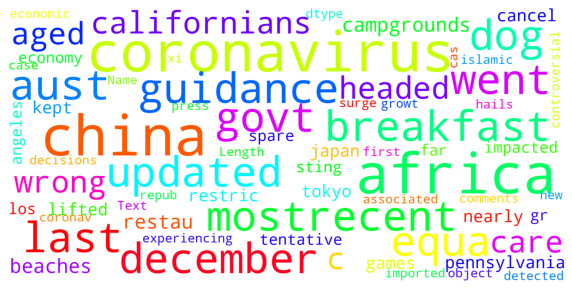

In [26]:
#word cloud for the cleaned text
#!pip install wordcloud
from wordcloud import WordCloud
#function to create word cloud
def create_wordcloud(text):
    eng_stopwords = set(stopwords.words("english"))    
    word_cloud = WordCloud(
                    background_color='white',
                    colormap='gist_rainbow',
                    stopwords=set(eng_stopwords),
                    max_words=300,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(data['Text']))
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.subplots_adjust(top=2.3)
    plt.imshow(word_cloud)
    plt.show()
    
    
create_wordcloud(data["Text"].values)


In [27]:
#data.filtered_text

In [28]:
#data.Text = data.filtered_text

In [29]:
#! python -m textblob.download_corpora

In [30]:
#data.head()

In [31]:
#from textblob import TextBlob
#from textblob.sentiments import NaiveBayesAnalyzer
#import text2emotion as te
from nrclex import NRCLex

In [32]:
#text=data.Text
#print(te.get_emotion(text))
#pandas.Series.astype(str)
#text_str = repr(text)
#print(text_str)
#text.to_frame()
data['label'] = ''
for i,x in data.Text.iteritems():
    text_str=repr(x)
    emotion = NRCLex(text_str)
    #print(te.get_emotion(text_str))
# Classify emotion
    #print('\n\n', emotion.top_emotions)
    emotion = emotion.top_emotions[0]
    emotion=emotion[0]
    if emotion == 'negative':
        emotion = 'sadness'
    elif emotion == 'positive':
        emotion = 'joy'
    #print('\n\n',emotion)
    data['label'][i] = emotion
    print("Index: ", i ,  "label" , emotion)

<ipython-input-32-d54bf16a43ac>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'][i] = emotion


Index:  0 label trust
Index:  1 label sadness
Index:  2 label anticipation
Index:  3 label trust
Index:  4 label fear
Index:  5 label fear
Index:  6 label trust
Index:  7 label fear
Index:  8 label anticipation
Index:  9 label joy
Index:  10 label sadness
Index:  11 label fear
Index:  12 label sadness
Index:  13 label fear
Index:  14 label fear
Index:  15 label fear
Index:  16 label joy
Index:  17 label fear
Index:  18 label anticipation
Index:  19 label fear
Index:  20 label sadness
Index:  21 label anticipation
Index:  22 label fear
Index:  23 label joy
Index:  24 label anticipation
Index:  25 label fear
Index:  26 label anticipation
Index:  27 label fear
Index:  28 label joy
Index:  29 label trust
Index:  30 label fear
Index:  31 label joy
Index:  32 label fear
Index:  33 label joy
Index:  34 label sadness
Index:  35 label trust
Index:  36 label trust
Index:  37 label joy
Index:  38 label joy
Index:  39 label joy
Index:  40 label anger
Index:  41 label fear
Index:  42 label fear
Ind

Index:  444 label trust
Index:  445 label sadness
Index:  446 label trust
Index:  447 label sadness
Index:  448 label sadness
Index:  449 label anticipation
Index:  450 label fear
Index:  451 label trust
Index:  452 label trust
Index:  453 label fear
Index:  454 label sadness
Index:  455 label fear
Index:  456 label joy
Index:  457 label fear
Index:  458 label fear
Index:  459 label fear
Index:  460 label joy
Index:  461 label fear
Index:  462 label joy
Index:  463 label fear
Index:  464 label fear
Index:  465 label joy
Index:  466 label fear
Index:  467 label anticipation
Index:  468 label joy
Index:  469 label fear
Index:  470 label fear
Index:  471 label sadness
Index:  472 label anticipation
Index:  473 label fear
Index:  474 label joy
Index:  475 label joy
Index:  476 label sadness
Index:  477 label fear
Index:  478 label sadness
Index:  479 label fear
Index:  480 label fear
Index:  481 label trust
Index:  482 label joy
Index:  483 label sadness
Index:  484 label fear
Index:  485 

Index:  784 label fear
Index:  785 label trust
Index:  786 label sadness
Index:  787 label sadness
Index:  788 label trust
Index:  789 label joy
Index:  790 label joy
Index:  791 label joy
Index:  792 label sadness
Index:  793 label sadness
Index:  794 label joy
Index:  795 label fear
Index:  796 label sadness
Index:  797 label sadness
Index:  798 label fear
Index:  799 label sadness
Index:  800 label joy
Index:  801 label trust
Index:  802 label joy
Index:  803 label fear
Index:  804 label joy
Index:  805 label sadness
Index:  806 label trust
Index:  807 label trust
Index:  808 label sadness
Index:  809 label sadness
Index:  810 label sadness
Index:  811 label sadness
Index:  812 label joy
Index:  813 label fear
Index:  814 label joy
Index:  815 label fear
Index:  816 label sadness
Index:  817 label joy
Index:  818 label joy
Index:  819 label joy
Index:  820 label anger
Index:  821 label trust
Index:  822 label joy
Index:  823 label sadness
Index:  824 label joy
Index:  825 label fear

Index:  1194 label joy
Index:  1195 label sadness
Index:  1196 label trust
Index:  1197 label sadness
Index:  1198 label joy
Index:  1199 label sadness
Index:  1200 label joy
Index:  1201 label fear
Index:  1202 label trust
Index:  1203 label trust
Index:  1204 label joy
Index:  1205 label joy
Index:  1206 label trust
Index:  1207 label fear
Index:  1208 label fear
Index:  1209 label joy
Index:  1210 label joy
Index:  1211 label fear
Index:  1212 label joy
Index:  1213 label joy
Index:  1214 label joy
Index:  1215 label fear
Index:  1216 label fear
Index:  1217 label trust
Index:  1218 label joy
Index:  1219 label sadness
Index:  1220 label joy
Index:  1221 label joy
Index:  1222 label fear
Index:  1223 label fear
Index:  1224 label fear
Index:  1225 label trust
Index:  1226 label joy
Index:  1227 label joy
Index:  1228 label sadness
Index:  1229 label fear
Index:  1230 label fear
Index:  1231 label sadness
Index:  1232 label sadness
Index:  1233 label fear
Index:  1234 label joy
Index

Index:  1547 label joy
Index:  1548 label fear
Index:  1549 label surprise
Index:  1550 label sadness
Index:  1551 label surprise
Index:  1552 label joy
Index:  1553 label sadness
Index:  1554 label trust
Index:  1555 label fear
Index:  1556 label fear
Index:  1557 label sadness
Index:  1558 label joy
Index:  1559 label joy
Index:  1560 label joy
Index:  1561 label trust
Index:  1562 label joy
Index:  1563 label anticipation
Index:  1564 label fear
Index:  1565 label sadness
Index:  1566 label fear
Index:  1567 label joy
Index:  1568 label fear
Index:  1569 label sadness
Index:  1570 label sadness
Index:  1571 label fear
Index:  1572 label fear
Index:  1573 label joy
Index:  1574 label sadness
Index:  1575 label fear
Index:  1576 label surprise
Index:  1577 label sadness
Index:  1578 label fear
Index:  1579 label joy
Index:  1580 label joy
Index:  1581 label fear
Index:  1582 label fear
Index:  1583 label joy
Index:  1584 label anticipation
Index:  1585 label anticipation
Index:  1586 

Index:  1945 label fear
Index:  1946 label fear
Index:  1947 label joy
Index:  1948 label sadness
Index:  1949 label sadness
Index:  1950 label sadness
Index:  1951 label trust
Index:  1952 label fear
Index:  1953 label fear
Index:  1954 label fear
Index:  1955 label joy
Index:  1956 label fear
Index:  1957 label fear
Index:  1958 label fear
Index:  1959 label fear
Index:  1960 label sadness
Index:  1961 label anticipation
Index:  1962 label fear
Index:  1963 label anticipation
Index:  1964 label fear
Index:  1965 label fear
Index:  1966 label fear
Index:  1967 label joy
Index:  1968 label trust
Index:  1969 label sadness
Index:  1970 label sadness
Index:  1971 label fear
Index:  1972 label anticipation
Index:  1973 label sadness
Index:  1974 label fear
Index:  1975 label fear
Index:  1976 label trust
Index:  1977 label fear
Index:  1978 label joy
Index:  1979 label sadness
Index:  1980 label sadness
Index:  1981 label fear
Index:  1982 label anticipation
Index:  1983 label fear
Index:

Index:  2288 label fear
Index:  2289 label sadness
Index:  2290 label joy
Index:  2291 label joy
Index:  2292 label joy
Index:  2293 label sadness
Index:  2294 label trust
Index:  2295 label joy
Index:  2296 label joy
Index:  2297 label trust
Index:  2298 label joy
Index:  2299 label joy
Index:  2300 label fear
Index:  2301 label joy
Index:  2302 label joy
Index:  2303 label sadness
Index:  2304 label joy
Index:  2305 label fear
Index:  2306 label trust
Index:  2307 label surprise
Index:  2308 label trust
Index:  2309 label joy
Index:  2310 label sadness
Index:  2311 label joy
Index:  2312 label fear
Index:  2313 label joy
Index:  2314 label joy
Index:  2315 label joy
Index:  2316 label joy
Index:  2317 label fear
Index:  2318 label trust
Index:  2319 label joy
Index:  2320 label joy
Index:  2321 label joy
Index:  2322 label joy
Index:  2323 label fear
Index:  2324 label fear
Index:  2325 label fear
Index:  2326 label sadness
Index:  2327 label fear
Index:  2328 label joy
Index:  2329 

Index:  2711 label fear
Index:  2712 label joy
Index:  2713 label fear
Index:  2714 label trust
Index:  2715 label joy
Index:  2716 label sadness
Index:  2717 label joy
Index:  2718 label fear
Index:  2719 label fear
Index:  2720 label joy
Index:  2721 label fear
Index:  2722 label fear
Index:  2723 label anticipation
Index:  2724 label fear
Index:  2725 label fear
Index:  2726 label anticipation
Index:  2727 label fear
Index:  2728 label fear
Index:  2729 label sadness
Index:  2730 label fear
Index:  2731 label trust
Index:  2732 label fear
Index:  2733 label fear
Index:  2734 label fear
Index:  2735 label sadness
Index:  2736 label fear
Index:  2737 label fear
Index:  2738 label joy
Index:  2739 label fear
Index:  2740 label fear
Index:  2741 label trust
Index:  2742 label trust
Index:  2743 label trust
Index:  2744 label joy
Index:  2745 label fear
Index:  2746 label fear
Index:  2747 label fear
Index:  2748 label fear
Index:  2749 label sadness
Index:  2750 label fear
Index:  2751 

Index:  3103 label joy
Index:  3104 label sadness
Index:  3105 label sadness
Index:  3106 label sadness
Index:  3107 label fear
Index:  3108 label sadness
Index:  3109 label fear
Index:  3110 label fear
Index:  3111 label joy
Index:  3112 label joy
Index:  3113 label fear
Index:  3114 label sadness
Index:  3115 label trust
Index:  3116 label joy
Index:  3117 label trust
Index:  3118 label trust
Index:  3119 label fear
Index:  3120 label fear
Index:  3121 label joy
Index:  3122 label fear
Index:  3123 label sadness
Index:  3124 label fear
Index:  3125 label fear
Index:  3126 label fear
Index:  3127 label joy
Index:  3128 label trust
Index:  3129 label fear
Index:  3130 label fear
Index:  3131 label sadness
Index:  3132 label joy
Index:  3133 label sadness
Index:  3134 label trust
Index:  3135 label anger
Index:  3136 label joy
Index:  3137 label joy
Index:  3138 label joy
Index:  3139 label sadness
Index:  3140 label sadness
Index:  3141 label trust
Index:  3142 label sadness
Index:  31

Index:  3512 label trust
Index:  3513 label fear
Index:  3514 label joy
Index:  3515 label fear
Index:  3516 label joy
Index:  3517 label joy
Index:  3518 label sadness
Index:  3519 label joy
Index:  3520 label joy
Index:  3521 label sadness
Index:  3522 label joy
Index:  3523 label joy
Index:  3524 label trust
Index:  3525 label fear
Index:  3526 label joy
Index:  3527 label joy
Index:  3528 label trust
Index:  3529 label joy
Index:  3530 label trust
Index:  3531 label joy
Index:  3532 label joy
Index:  3533 label joy
Index:  3534 label trust
Index:  3535 label trust
Index:  3536 label joy
Index:  3537 label trust
Index:  3538 label sadness
Index:  3539 label joy
Index:  3540 label fear
Index:  3541 label joy
Index:  3542 label joy
Index:  3543 label fear
Index:  3544 label joy
Index:  3545 label sadness
Index:  3546 label anticipation
Index:  3547 label trust
Index:  3548 label fear
Index:  3549 label fear
Index:  3550 label trust
Index:  3551 label sadness
Index:  3552 label anticip

Index:  3908 label anticipation
Index:  3909 label trust
Index:  3910 label trust
Index:  3911 label anticipation
Index:  3912 label sadness
Index:  3913 label trust
Index:  3914 label fear
Index:  3915 label joy
Index:  3916 label joy
Index:  3917 label trust
Index:  3918 label fear
Index:  3919 label surprise
Index:  3920 label trust
Index:  3921 label fear
Index:  3922 label trust
Index:  3923 label trust
Index:  3924 label fear
Index:  3925 label joy
Index:  3926 label joy
Index:  3927 label fear
Index:  3928 label fear
Index:  3929 label fear
Index:  3930 label joy
Index:  3931 label trust
Index:  3932 label joy
Index:  3933 label fear
Index:  3934 label fear
Index:  3935 label fear
Index:  3936 label fear
Index:  3937 label fear
Index:  3938 label joy
Index:  3939 label anticipation
Index:  3940 label fear
Index:  3941 label joy
Index:  3942 label joy
Index:  3943 label fear
Index:  3944 label sadness
Index:  3945 label joy
Index:  3946 label joy
Index:  3947 label joy
Index:  39

Index:  4310 label joy
Index:  4311 label anticipation
Index:  4312 label anticipation
Index:  4313 label fear
Index:  4314 label trust
Index:  4315 label fear
Index:  4316 label fear
Index:  4317 label fear
Index:  4318 label fear
Index:  4319 label fear
Index:  4320 label fear
Index:  4321 label sadness
Index:  4322 label trust
Index:  4323 label sadness
Index:  4324 label joy
Index:  4325 label trust
Index:  4326 label sadness
Index:  4327 label fear
Index:  4328 label sadness
Index:  4329 label fear
Index:  4330 label fear
Index:  4331 label fear
Index:  4332 label joy
Index:  4333 label fear
Index:  4334 label joy
Index:  4335 label joy
Index:  4336 label fear
Index:  4337 label fear
Index:  4338 label trust
Index:  4339 label sadness
Index:  4340 label sadness
Index:  4341 label sadness
Index:  4342 label joy
Index:  4343 label trust
Index:  4344 label fear
Index:  4345 label trust
Index:  4346 label joy
Index:  4347 label joy
Index:  4348 label fear
Index:  4349 label joy
Index:

Index:  4679 label joy
Index:  4680 label trust
Index:  4681 label joy
Index:  4682 label joy
Index:  4683 label sadness
Index:  4684 label joy
Index:  4685 label joy
Index:  4686 label trust
Index:  4687 label sadness
Index:  4688 label joy
Index:  4689 label trust
Index:  4690 label trust
Index:  4691 label joy
Index:  4692 label trust
Index:  4693 label sadness
Index:  4694 label sadness
Index:  4695 label fear
Index:  4696 label trust
Index:  4697 label sadness
Index:  4698 label joy
Index:  4699 label surprise
Index:  4700 label fear
Index:  4701 label joy
Index:  4702 label fear
Index:  4703 label joy
Index:  4704 label fear
Index:  4705 label fear
Index:  4706 label sadness
Index:  4707 label trust
Index:  4708 label joy
Index:  4709 label fear
Index:  4710 label joy
Index:  4711 label fear
Index:  4712 label trust
Index:  4713 label fear
Index:  4714 label fear
Index:  4715 label fear
Index:  4716 label trust
Index:  4717 label sadness
Index:  4718 label fear
Index:  4719 label

Index:  5069 label fear
Index:  5070 label fear
Index:  5071 label joy
Index:  5072 label joy
Index:  5073 label fear
Index:  5074 label fear
Index:  5075 label trust
Index:  5076 label joy
Index:  5077 label sadness
Index:  5078 label joy
Index:  5079 label sadness
Index:  5080 label fear
Index:  5081 label trust
Index:  5082 label joy
Index:  5083 label fear
Index:  5084 label sadness
Index:  5085 label trust
Index:  5086 label fear
Index:  5087 label sadness
Index:  5088 label fear
Index:  5089 label fear
Index:  5090 label fear
Index:  5091 label sadness
Index:  5092 label sadness
Index:  5093 label joy
Index:  5094 label joy
Index:  5095 label fear
Index:  5096 label fear
Index:  5097 label joy
Index:  5098 label joy
Index:  5099 label sadness
Index:  5100 label anger
Index:  5101 label sadness
Index:  5102 label fear
Index:  5103 label joy
Index:  5104 label trust
Index:  5105 label fear
Index:  5106 label joy
Index:  5107 label anger
Index:  5108 label trust
Index:  5109 label j

Index:  5475 label trust
Index:  5476 label fear
Index:  5477 label joy
Index:  5478 label joy
Index:  5479 label fear
Index:  5480 label joy
Index:  5481 label trust
Index:  5482 label joy
Index:  5483 label joy
Index:  5484 label joy
Index:  5485 label joy
Index:  5486 label joy
Index:  5487 label joy
Index:  5488 label fear
Index:  5489 label joy
Index:  5490 label fear
Index:  5491 label sadness
Index:  5492 label anticipation
Index:  5493 label joy
Index:  5494 label joy
Index:  5495 label trust
Index:  5496 label trust
Index:  5497 label sadness
Index:  5498 label fear
Index:  5499 label sadness
Index:  5500 label anticipation
Index:  5501 label joy
Index:  5502 label fear
Index:  5503 label trust
Index:  5504 label trust
Index:  5505 label joy
Index:  5506 label trust
Index:  5507 label joy
Index:  5508 label trust
Index:  5509 label joy
Index:  5510 label trust
Index:  5511 label sadness
Index:  5512 label sadness
Index:  5513 label joy
Index:  5514 label trust
Index:  5515 lab

Index:  5897 label fear
Index:  5898 label joy
Index:  5899 label sadness
Index:  5900 label fear
Index:  5901 label trust
Index:  5902 label joy
Index:  5903 label trust
Index:  5904 label anger
Index:  5905 label trust
Index:  5906 label sadness
Index:  5907 label trust
Index:  5908 label trust
Index:  5909 label fear
Index:  5910 label trust
Index:  5911 label fear
Index:  5912 label trust
Index:  5913 label joy
Index:  5914 label trust
Index:  5915 label fear
Index:  5916 label fear
Index:  5917 label sadness
Index:  5918 label joy
Index:  5919 label sadness
Index:  5920 label fear
Index:  5921 label sadness
Index:  5922 label trust
Index:  5923 label fear
Index:  5924 label trust
Index:  5925 label joy
Index:  5926 label trust
Index:  5927 label joy
Index:  5928 label sadness
Index:  5929 label surprise
Index:  5930 label sadness
Index:  5931 label sadness
Index:  5932 label sadness
Index:  5933 label fear
Index:  5934 label trust
Index:  5935 label joy
Index:  5936 label fear
Ind

Index:  6319 label joy
Index:  6320 label fear
Index:  6321 label fear
Index:  6322 label joy
Index:  6323 label trust
Index:  6324 label fear
Index:  6325 label trust
Index:  6326 label surprise
Index:  6327 label fear
Index:  6328 label joy
Index:  6329 label joy
Index:  6330 label trust
Index:  6331 label fear
Index:  6332 label fear
Index:  6333 label trust
Index:  6334 label trust
Index:  6335 label joy
Index:  6336 label joy
Index:  6337 label anticipation
Index:  6338 label joy
Index:  6339 label fear
Index:  6340 label joy
Index:  6341 label fear
Index:  6342 label fear
Index:  6343 label sadness
Index:  6344 label joy
Index:  6345 label anticipation
Index:  6346 label fear
Index:  6347 label joy
Index:  6348 label sadness
Index:  6349 label sadness
Index:  6350 label sadness
Index:  6351 label fear
Index:  6352 label fear
Index:  6353 label trust
Index:  6354 label sadness
Index:  6355 label trust
Index:  6356 label fear
Index:  6357 label joy
Index:  6358 label sadness
Index:

Index:  6733 label sadness
Index:  6734 label trust
Index:  6735 label trust
Index:  6736 label fear
Index:  6737 label joy
Index:  6738 label sadness
Index:  6739 label anger
Index:  6740 label fear
Index:  6741 label fear
Index:  6742 label joy
Index:  6743 label sadness
Index:  6744 label fear
Index:  6745 label fear
Index:  6746 label fear
Index:  6747 label sadness
Index:  6748 label sadness
Index:  6749 label trust
Index:  6750 label fear
Index:  6751 label joy
Index:  6752 label fear
Index:  6753 label trust
Index:  6754 label anger
Index:  6755 label joy
Index:  6756 label joy
Index:  6757 label fear
Index:  6758 label fear
Index:  6759 label joy
Index:  6760 label joy
Index:  6761 label fear
Index:  6762 label trust
Index:  6763 label fear
Index:  6764 label fear
Index:  6765 label fear
Index:  6766 label joy
Index:  6767 label trust
Index:  6768 label joy
Index:  6769 label anticipation
Index:  6770 label trust
Index:  6771 label sadness
Index:  6772 label fear
Index:  6773 l

Index:  7157 label sadness
Index:  7158 label joy
Index:  7159 label trust
Index:  7160 label joy
Index:  7161 label joy
Index:  7162 label joy
Index:  7163 label sadness
Index:  7164 label fear
Index:  7165 label fear
Index:  7166 label joy
Index:  7167 label trust
Index:  7168 label fear
Index:  7169 label joy
Index:  7170 label anger
Index:  7171 label fear
Index:  7172 label trust
Index:  7173 label trust
Index:  7174 label joy
Index:  7175 label joy
Index:  7176 label fear
Index:  7177 label trust
Index:  7178 label fear
Index:  7179 label sadness
Index:  7180 label fear
Index:  7181 label joy
Index:  7182 label anticipation
Index:  7183 label fear
Index:  7184 label joy
Index:  7185 label joy
Index:  7186 label joy
Index:  7187 label trust
Index:  7188 label joy
Index:  7189 label fear
Index:  7190 label joy
Index:  7191 label trust
Index:  7192 label fear
Index:  7193 label sadness
Index:  7194 label fear
Index:  7195 label fear
Index:  7196 label fear
Index:  7197 label trust
I

Index:  7566 label trust
Index:  7567 label joy
Index:  7568 label anger
Index:  7569 label fear
Index:  7570 label joy
Index:  7571 label trust
Index:  7572 label fear
Index:  7573 label sadness
Index:  7574 label fear
Index:  7575 label joy
Index:  7576 label joy
Index:  7577 label fear
Index:  7578 label fear
Index:  7579 label fear
Index:  7580 label trust
Index:  7581 label joy
Index:  7582 label fear
Index:  7583 label sadness
Index:  7584 label fear
Index:  7585 label fear
Index:  7586 label fear
Index:  7587 label fear
Index:  7588 label joy
Index:  7589 label fear
Index:  7590 label sadness
Index:  7591 label sadness
Index:  7592 label trust
Index:  7593 label anticipation
Index:  7594 label sadness
Index:  7595 label joy
Index:  7596 label sadness
Index:  7597 label trust
Index:  7598 label fear
Index:  7599 label joy
Index:  7600 label trust
Index:  7601 label anticipation
Index:  7602 label sadness
Index:  7603 label fear
Index:  7604 label sadness
Index:  7605 label sadnes

Index:  7983 label joy
Index:  7984 label trust
Index:  7985 label fear
Index:  7986 label sadness
Index:  7987 label trust
Index:  7988 label joy
Index:  7989 label fear
Index:  7990 label joy
Index:  7991 label fear
Index:  7992 label fear
Index:  7993 label fear
Index:  7994 label joy
Index:  7995 label trust
Index:  7996 label joy
Index:  7997 label sadness
Index:  7998 label joy
Index:  7999 label fear
Index:  8000 label anticipation
Index:  8001 label sadness
Index:  8002 label joy
Index:  8003 label joy
Index:  8004 label joy
Index:  8005 label joy
Index:  8006 label joy
Index:  8007 label fear
Index:  8008 label joy
Index:  8009 label trust
Index:  8010 label fear
Index:  8011 label sadness
Index:  8012 label sadness
Index:  8013 label joy
Index:  8014 label joy
Index:  8015 label trust
Index:  8016 label trust
Index:  8017 label joy
Index:  8018 label fear
Index:  8019 label joy
Index:  8020 label trust
Index:  8021 label joy
Index:  8022 label trust
Index:  8023 label joy
Ind

Index:  8340 label anticipation
Index:  8341 label fear
Index:  8342 label fear
Index:  8343 label fear
Index:  8344 label anger
Index:  8345 label trust
Index:  8346 label fear
Index:  8347 label sadness
Index:  8348 label trust
Index:  8349 label sadness
Index:  8350 label trust
Index:  8351 label sadness
Index:  8352 label joy
Index:  8353 label trust
Index:  8354 label sadness
Index:  8355 label sadness
Index:  8356 label trust
Index:  8357 label anticipation
Index:  8358 label joy
Index:  8359 label sadness
Index:  8360 label trust
Index:  8361 label joy
Index:  8362 label fear
Index:  8363 label trust
Index:  8364 label fear
Index:  8365 label trust
Index:  8366 label fear
Index:  8367 label sadness
Index:  8368 label joy
Index:  8369 label anticipation
Index:  8370 label sadness
Index:  8371 label joy
Index:  8372 label fear
Index:  8373 label sadness
Index:  8374 label sadness
Index:  8375 label fear
Index:  8376 label fear
Index:  8377 label surprise
Index:  8378 label trust
I

Index:  8747 label trust
Index:  8748 label trust
Index:  8749 label trust
Index:  8750 label joy
Index:  8751 label sadness
Index:  8752 label trust
Index:  8753 label joy
Index:  8754 label fear
Index:  8755 label joy
Index:  8756 label trust
Index:  8757 label fear
Index:  8758 label joy
Index:  8759 label fear
Index:  8760 label sadness
Index:  8761 label joy
Index:  8762 label sadness
Index:  8763 label anger
Index:  8764 label joy
Index:  8765 label fear
Index:  8766 label fear
Index:  8767 label fear
Index:  8768 label joy
Index:  8769 label joy
Index:  8770 label sadness
Index:  8771 label trust
Index:  8772 label trust
Index:  8773 label joy
Index:  8774 label joy
Index:  8775 label joy
Index:  8776 label fear
Index:  8777 label sadness
Index:  8778 label fear
Index:  8779 label joy
Index:  8780 label fear
Index:  8781 label joy
Index:  8782 label fear
Index:  8783 label trust
Index:  8784 label fear
Index:  8785 label trust
Index:  8786 label sadness
Index:  8787 label sadnes

Index:  9103 label joy
Index:  9104 label fear
Index:  9105 label fear
Index:  9106 label joy
Index:  9107 label trust
Index:  9108 label joy
Index:  9109 label joy
Index:  9110 label fear
Index:  9111 label fear
Index:  9112 label joy
Index:  9113 label sadness
Index:  9114 label sadness
Index:  9115 label joy
Index:  9116 label fear
Index:  9117 label sadness
Index:  9118 label joy
Index:  9119 label trust
Index:  9120 label joy
Index:  9121 label sadness
Index:  9122 label sadness
Index:  9123 label fear
Index:  9124 label sadness
Index:  9125 label sadness
Index:  9126 label sadness
Index:  9127 label joy
Index:  9128 label sadness
Index:  9129 label fear
Index:  9130 label trust
Index:  9131 label sadness
Index:  9132 label fear
Index:  9133 label trust
Index:  9134 label fear
Index:  9135 label sadness
Index:  9136 label joy
Index:  9137 label sadness
Index:  9138 label sadness
Index:  9139 label sadness
Index:  9140 label joy
Index:  9141 label sadness
Index:  9142 label fear
In

Index:  9520 label joy
Index:  9521 label joy
Index:  9522 label joy
Index:  9523 label joy
Index:  9524 label joy
Index:  9525 label joy
Index:  9526 label joy
Index:  9527 label joy
Index:  9528 label joy
Index:  9529 label joy
Index:  9530 label joy
Index:  9531 label joy
Index:  9532 label joy
Index:  9533 label joy
Index:  9534 label joy
Index:  9535 label joy
Index:  9536 label joy
Index:  9537 label joy
Index:  9538 label joy
Index:  9539 label joy
Index:  9540 label joy
Index:  9541 label joy
Index:  9542 label joy
Index:  9543 label joy
Index:  9544 label joy
Index:  9545 label joy
Index:  9546 label joy
Index:  9547 label joy
Index:  9548 label joy
Index:  9549 label joy
Index:  9550 label joy
Index:  9551 label joy
Index:  9552 label joy
Index:  9553 label joy
Index:  9554 label joy
Index:  9555 label joy
Index:  9556 label joy
Index:  9557 label joy
Index:  9558 label fear
Index:  9559 label joy
Index:  9560 label joy
Index:  9561 label joy
Index:  9562 label fear
Index:  9

Index:  9872 label joy
Index:  9873 label anger
Index:  9874 label trust
Index:  9875 label trust
Index:  9876 label joy
Index:  9877 label sadness
Index:  9878 label fear
Index:  9879 label sadness
Index:  9880 label trust
Index:  9881 label joy
Index:  9882 label trust
Index:  9883 label joy
Index:  9884 label joy
Index:  9885 label fear
Index:  9886 label fear
Index:  9887 label joy
Index:  9888 label anger
Index:  9889 label joy
Index:  9890 label sadness
Index:  9891 label fear
Index:  9892 label joy
Index:  9893 label sadness
Index:  9894 label fear
Index:  9895 label fear
Index:  9896 label sadness
Index:  9897 label joy
Index:  9898 label trust
Index:  9899 label trust
Index:  9900 label fear
Index:  9901 label joy
Index:  9902 label joy
Index:  9903 label fear
Index:  9904 label fear
Index:  9905 label fear
Index:  9906 label trust
Index:  9907 label joy
Index:  9908 label sadness
Index:  9909 label joy
Index:  9910 label trust
Index:  9911 label joy
Index:  9912 label sadness

Index:  10267 label fear
Index:  10268 label joy
Index:  10269 label joy
Index:  10270 label fear
Index:  10271 label joy
Index:  10272 label sadness
Index:  10273 label trust
Index:  10274 label joy
Index:  10275 label anticipation
Index:  10276 label joy
Index:  10277 label fear
Index:  10278 label joy
Index:  10279 label joy
Index:  10280 label trust
Index:  10281 label fear
Index:  10282 label joy
Index:  10283 label fear
Index:  10284 label surprise
Index:  10285 label joy
Index:  10286 label anticipation
Index:  10287 label fear
Index:  10288 label joy
Index:  10289 label sadness
Index:  10290 label sadness
Index:  10291 label trust
Index:  10292 label joy
Index:  10293 label fear
Index:  10294 label trust
Index:  10295 label joy
Index:  10296 label fear
Index:  10297 label anticipation
Index:  10298 label joy
Index:  10299 label trust
Index:  10300 label trust
Index:  10301 label fear
Index:  10302 label anticipation
Index:  10303 label joy
Index:  10304 label joy
Index:  10305 

Index:  10641 label trust
Index:  10642 label sadness
Index:  10643 label sadness
Index:  10644 label fear
Index:  10645 label sadness
Index:  10646 label fear
Index:  10647 label sadness
Index:  10648 label fear
Index:  10649 label fear
Index:  10650 label joy
Index:  10651 label joy
Index:  10652 label sadness
Index:  10653 label sadness
Index:  10654 label joy
Index:  10655 label sadness
Index:  10656 label fear
Index:  10657 label joy
Index:  10658 label joy
Index:  10659 label fear
Index:  10660 label fear
Index:  10661 label joy
Index:  10662 label joy
Index:  10663 label sadness
Index:  10664 label joy
Index:  10665 label joy
Index:  10666 label fear
Index:  10667 label anticipation
Index:  10668 label joy
Index:  10669 label joy
Index:  10670 label anger
Index:  10671 label trust
Index:  10672 label sadness
Index:  10673 label joy
Index:  10674 label joy
Index:  10675 label trust
Index:  10676 label sadness
Index:  10677 label joy
Index:  10678 label sadness
Index:  10679 label

Index:  10964 label fear
Index:  10965 label fear
Index:  10966 label fear
Index:  10967 label joy
Index:  10968 label fear
Index:  10969 label joy
Index:  10970 label fear
Index:  10971 label fear
Index:  10972 label joy
Index:  10973 label fear
Index:  10974 label fear
Index:  10975 label fear
Index:  10976 label joy
Index:  10977 label trust
Index:  10978 label joy
Index:  10979 label joy
Index:  10980 label sadness
Index:  10981 label sadness
Index:  10982 label sadness
Index:  10983 label sadness
Index:  10984 label fear
Index:  10985 label sadness
Index:  10986 label sadness
Index:  10987 label joy
Index:  10988 label joy
Index:  10989 label sadness
Index:  10990 label fear
Index:  10991 label joy
Index:  10992 label joy
Index:  10993 label joy
Index:  10994 label fear
Index:  10995 label fear
Index:  10996 label fear
Index:  10997 label joy
Index:  10998 label fear
Index:  10999 label fear
Index:  11000 label trust
Index:  11001 label sadness
Index:  11002 label sadness
Index:  

Index:  11304 label joy
Index:  11305 label fear
Index:  11306 label joy
Index:  11307 label fear
Index:  11308 label sadness
Index:  11309 label joy
Index:  11310 label fear
Index:  11311 label joy
Index:  11312 label fear
Index:  11313 label sadness
Index:  11314 label joy
Index:  11315 label trust
Index:  11316 label fear
Index:  11317 label fear
Index:  11318 label sadness
Index:  11319 label sadness
Index:  11320 label joy
Index:  11321 label fear
Index:  11322 label fear
Index:  11323 label sadness
Index:  11324 label fear
Index:  11325 label fear
Index:  11326 label sadness
Index:  11327 label surprise
Index:  11328 label sadness
Index:  11329 label joy
Index:  11330 label joy
Index:  11331 label sadness
Index:  11332 label sadness
Index:  11333 label sadness
Index:  11334 label fear
Index:  11335 label trust
Index:  11336 label joy
Index:  11337 label joy
Index:  11338 label joy
Index:  11339 label sadness
Index:  11340 label sadness
Index:  11341 label joy
Index:  11342 label 

Index:  11643 label fear
Index:  11644 label trust
Index:  11645 label fear
Index:  11646 label joy
Index:  11647 label joy
Index:  11648 label joy
Index:  11649 label sadness
Index:  11650 label sadness
Index:  11651 label fear
Index:  11652 label fear
Index:  11653 label fear
Index:  11654 label joy
Index:  11655 label fear
Index:  11656 label trust
Index:  11657 label sadness
Index:  11658 label joy
Index:  11659 label sadness
Index:  11660 label joy
Index:  11661 label fear
Index:  11662 label fear
Index:  11663 label trust
Index:  11664 label fear
Index:  11665 label fear
Index:  11666 label joy
Index:  11667 label fear
Index:  11668 label trust
Index:  11669 label sadness
Index:  11670 label joy
Index:  11671 label fear
Index:  11672 label joy
Index:  11673 label fear
Index:  11674 label sadness
Index:  11675 label joy
Index:  11676 label joy
Index:  11677 label surprise
Index:  11678 label fear
Index:  11679 label fear
Index:  11680 label fear
Index:  11681 label sadness
Index: 

Index:  12049 label sadness
Index:  12050 label trust
Index:  12051 label joy
Index:  12052 label sadness
Index:  12053 label fear
Index:  12054 label fear
Index:  12055 label sadness
Index:  12056 label sadness
Index:  12057 label sadness
Index:  12058 label trust
Index:  12059 label fear
Index:  12060 label trust
Index:  12061 label joy
Index:  12062 label fear
Index:  12063 label fear
Index:  12064 label joy
Index:  12065 label fear
Index:  12066 label trust
Index:  12067 label trust
Index:  12068 label joy
Index:  12069 label fear
Index:  12070 label joy
Index:  12071 label joy
Index:  12072 label joy
Index:  12073 label fear
Index:  12074 label sadness
Index:  12075 label fear
Index:  12076 label joy
Index:  12077 label trust
Index:  12078 label joy
Index:  12079 label joy
Index:  12080 label sadness
Index:  12081 label fear
Index:  12082 label fear
Index:  12083 label joy
Index:  12084 label joy
Index:  12085 label fear
Index:  12086 label fear
Index:  12087 label fear
Index:  12

Index:  12484 label trust
Index:  12485 label sadness
Index:  12486 label fear
Index:  12487 label joy
Index:  12488 label sadness
Index:  12489 label joy
Index:  12490 label sadness
Index:  12491 label fear
Index:  12492 label fear
Index:  12493 label joy
Index:  12494 label trust
Index:  12495 label fear
Index:  12496 label trust
Index:  12497 label joy
Index:  12498 label joy
Index:  12499 label sadness
Index:  12500 label fear
Index:  12501 label fear
Index:  12502 label joy
Index:  12503 label fear
Index:  12504 label joy
Index:  12505 label fear
Index:  12506 label fear
Index:  12507 label fear
Index:  12508 label joy
Index:  12509 label sadness
Index:  12510 label sadness
Index:  12511 label sadness
Index:  12512 label joy
Index:  12513 label anticipation
Index:  12514 label sadness
Index:  12515 label surprise
Index:  12516 label surprise
Index:  12517 label fear
Index:  12518 label anticipation
Index:  12519 label sadness
Index:  12520 label fear
Index:  12521 label sadness
In

Index:  12826 label joy
Index:  12827 label joy
Index:  12828 label sadness
Index:  12829 label fear
Index:  12830 label joy
Index:  12831 label sadness
Index:  12832 label joy
Index:  12833 label joy
Index:  12834 label joy
Index:  12835 label fear
Index:  12836 label trust
Index:  12837 label joy
Index:  12838 label trust
Index:  12839 label joy
Index:  12840 label fear
Index:  12841 label fear
Index:  12842 label joy
Index:  12843 label joy
Index:  12844 label sadness
Index:  12845 label anticipation
Index:  12846 label joy
Index:  12847 label joy
Index:  12848 label fear
Index:  12849 label joy
Index:  12850 label fear
Index:  12851 label joy
Index:  12852 label fear
Index:  12853 label joy
Index:  12854 label joy
Index:  12855 label fear
Index:  12856 label trust
Index:  12857 label joy
Index:  12858 label joy
Index:  12859 label sadness
Index:  12860 label joy
Index:  12861 label fear
Index:  12862 label sadness
Index:  12863 label fear
Index:  12864 label joy
Index:  12865 label

Index:  13165 label joy
Index:  13166 label joy
Index:  13167 label joy
Index:  13168 label joy
Index:  13169 label joy
Index:  13170 label joy
Index:  13171 label trust
Index:  13172 label sadness
Index:  13173 label joy
Index:  13174 label fear
Index:  13175 label fear
Index:  13176 label joy
Index:  13177 label trust
Index:  13178 label sadness
Index:  13179 label joy
Index:  13180 label fear
Index:  13181 label sadness
Index:  13182 label joy
Index:  13183 label joy
Index:  13184 label fear
Index:  13185 label joy
Index:  13186 label trust
Index:  13187 label joy
Index:  13188 label anticipation
Index:  13189 label fear
Index:  13190 label fear
Index:  13191 label fear
Index:  13192 label joy
Index:  13193 label sadness
Index:  13194 label joy
Index:  13195 label fear
Index:  13196 label anger
Index:  13197 label sadness
Index:  13198 label joy
Index:  13199 label joy
Index:  13200 label joy
Index:  13201 label joy
Index:  13202 label anticipation
Index:  13203 label joy
Index:  13

Index:  13570 label fear
Index:  13571 label joy
Index:  13572 label sadness
Index:  13573 label sadness
Index:  13574 label trust
Index:  13575 label anticipation
Index:  13576 label joy
Index:  13577 label sadness
Index:  13578 label trust
Index:  13579 label fear
Index:  13580 label fear
Index:  13581 label fear
Index:  13582 label sadness
Index:  13583 label surprise
Index:  13584 label fear
Index:  13585 label anticipation
Index:  13586 label joy
Index:  13587 label joy
Index:  13588 label surprise
Index:  13589 label surprise
Index:  13590 label fear
Index:  13591 label joy
Index:  13592 label fear
Index:  13593 label sadness
Index:  13594 label fear
Index:  13595 label fear
Index:  13596 label fear
Index:  13597 label joy
Index:  13598 label joy
Index:  13599 label fear
Index:  13600 label fear
Index:  13601 label fear
Index:  13602 label joy
Index:  13603 label trust
Index:  13604 label sadness
Index:  13605 label joy
Index:  13606 label trust
Index:  13607 label fear
Index:  1

Index:  13978 label joy
Index:  13979 label fear
Index:  13980 label fear
Index:  13981 label sadness
Index:  13982 label fear
Index:  13983 label fear
Index:  13984 label sadness
Index:  13985 label anger
Index:  13986 label sadness
Index:  13987 label joy
Index:  13988 label joy
Index:  13989 label surprise
Index:  13990 label fear
Index:  13991 label fear
Index:  13992 label fear
Index:  13993 label fear
Index:  13994 label fear
Index:  13995 label sadness
Index:  13996 label fear
Index:  13997 label anticipation
Index:  13998 label trust
Index:  13999 label sadness
Index:  14000 label trust
Index:  14001 label fear
Index:  14002 label fear
Index:  14003 label fear
Index:  14004 label anticipation
Index:  14005 label joy
Index:  14006 label sadness
Index:  14007 label trust
Index:  14008 label fear
Index:  14009 label sadness
Index:  14010 label trust
Index:  14011 label joy
Index:  14012 label sadness
Index:  14013 label surprise
Index:  14014 label sadness
Index:  14015 label fear

Index:  14317 label joy
Index:  14318 label sadness
Index:  14319 label fear
Index:  14320 label anticipation
Index:  14321 label sadness
Index:  14322 label fear
Index:  14323 label trust
Index:  14324 label joy
Index:  14325 label trust
Index:  14326 label joy
Index:  14327 label trust
Index:  14328 label trust
Index:  14329 label joy
Index:  14330 label sadness
Index:  14331 label sadness
Index:  14332 label fear
Index:  14333 label anticipation
Index:  14334 label joy
Index:  14335 label joy
Index:  14336 label joy
Index:  14337 label joy
Index:  14338 label joy
Index:  14339 label joy
Index:  14340 label joy
Index:  14341 label joy
Index:  14342 label joy
Index:  14343 label joy
Index:  14344 label joy
Index:  14345 label fear
Index:  14346 label joy
Index:  14347 label joy
Index:  14348 label fear
Index:  14349 label joy
Index:  14350 label anticipation
Index:  14351 label sadness
Index:  14352 label joy
Index:  14353 label joy
Index:  14354 label joy
Index:  14355 label fear
Ind

Index:  14726 label surprise
Index:  14727 label sadness
Index:  14728 label fear
Index:  14729 label fear
Index:  14730 label trust
Index:  14731 label sadness
Index:  14732 label joy
Index:  14733 label trust
Index:  14734 label fear
Index:  14735 label joy
Index:  14736 label joy
Index:  14737 label sadness
Index:  14738 label joy
Index:  14739 label fear
Index:  14740 label joy
Index:  14741 label joy
Index:  14742 label trust
Index:  14743 label fear
Index:  14744 label sadness
Index:  14745 label fear
Index:  14746 label sadness
Index:  14747 label fear
Index:  14748 label sadness
Index:  14749 label joy
Index:  14750 label joy
Index:  14751 label fear
Index:  14752 label trust
Index:  14753 label joy
Index:  14754 label trust
Index:  14755 label trust
Index:  14756 label fear
Index:  14757 label joy
Index:  14758 label trust
Index:  14759 label joy
Index:  14760 label sadness
Index:  14761 label fear
Index:  14762 label joy
Index:  14763 label joy
Index:  14764 label sadness
Ind

Index:  15134 label fear
Index:  15135 label trust
Index:  15136 label fear
Index:  15137 label fear
Index:  15138 label trust
Index:  15139 label fear
Index:  15140 label sadness
Index:  15141 label sadness
Index:  15142 label joy
Index:  15143 label fear
Index:  15144 label joy
Index:  15145 label fear
Index:  15146 label fear
Index:  15147 label joy
Index:  15148 label joy
Index:  15149 label joy
Index:  15150 label fear
Index:  15151 label joy
Index:  15152 label fear
Index:  15153 label joy
Index:  15154 label fear
Index:  15155 label fear
Index:  15156 label joy
Index:  15157 label joy
Index:  15158 label sadness
Index:  15159 label fear
Index:  15160 label joy
Index:  15161 label sadness
Index:  15162 label joy
Index:  15163 label joy
Index:  15164 label joy
Index:  15165 label joy
Index:  15166 label joy
Index:  15167 label trust
Index:  15168 label fear
Index:  15169 label sadness
Index:  15170 label anticipation
Index:  15171 label sadness
Index:  15172 label sadness
Index:  

Index:  15520 label joy
Index:  15521 label joy
Index:  15522 label sadness
Index:  15523 label sadness
Index:  15524 label trust
Index:  15525 label joy
Index:  15526 label trust
Index:  15527 label joy
Index:  15528 label sadness
Index:  15529 label joy
Index:  15530 label sadness
Index:  15531 label sadness
Index:  15532 label joy
Index:  15533 label joy
Index:  15534 label trust
Index:  15535 label anger
Index:  15536 label joy
Index:  15537 label sadness
Index:  15538 label joy
Index:  15539 label joy
Index:  15540 label joy
Index:  15541 label trust
Index:  15542 label fear
Index:  15543 label fear
Index:  15544 label sadness
Index:  15545 label fear
Index:  15546 label joy
Index:  15547 label trust
Index:  15548 label joy
Index:  15549 label joy
Index:  15550 label joy
Index:  15551 label fear
Index:  15552 label joy
Index:  15553 label sadness
Index:  15554 label fear
Index:  15555 label sadness
Index:  15556 label joy
Index:  15557 label fear
Index:  15558 label joy
Index:  15

Index:  15915 label sadness
Index:  15916 label sadness
Index:  15917 label fear
Index:  15918 label fear
Index:  15919 label fear
Index:  15920 label fear
Index:  15921 label fear
Index:  15922 label fear
Index:  15923 label joy
Index:  15924 label anticipation
Index:  15925 label sadness
Index:  15926 label fear
Index:  15927 label trust
Index:  15928 label fear
Index:  15929 label trust
Index:  15930 label fear
Index:  15931 label joy
Index:  15932 label sadness
Index:  15933 label sadness
Index:  15934 label joy
Index:  15935 label joy
Index:  15936 label joy
Index:  15937 label fear
Index:  15938 label joy
Index:  15939 label joy
Index:  15940 label fear
Index:  15941 label joy
Index:  15942 label trust
Index:  15943 label fear
Index:  15944 label joy
Index:  15945 label fear
Index:  15946 label joy
Index:  15947 label joy
Index:  15948 label fear
Index:  15949 label fear
Index:  15950 label joy
Index:  15951 label joy
Index:  15952 label joy
Index:  15953 label fear
Index:  15954

Index:  16336 label fear
Index:  16337 label joy
Index:  16338 label sadness
Index:  16339 label joy
Index:  16340 label trust
Index:  16341 label sadness
Index:  16342 label trust
Index:  16343 label joy
Index:  16344 label trust
Index:  16345 label joy
Index:  16346 label fear
Index:  16347 label surprise
Index:  16348 label surprise
Index:  16349 label trust
Index:  16350 label trust
Index:  16351 label joy
Index:  16352 label fear
Index:  16353 label fear
Index:  16354 label fear
Index:  16355 label joy
Index:  16356 label surprise
Index:  16357 label trust
Index:  16358 label sadness
Index:  16359 label trust
Index:  16360 label trust
Index:  16361 label anticipation
Index:  16362 label sadness
Index:  16363 label sadness
Index:  16364 label fear
Index:  16365 label sadness
Index:  16366 label joy
Index:  16367 label fear
Index:  16368 label surprise
Index:  16369 label surprise
Index:  16370 label trust
Index:  16371 label joy
Index:  16372 label joy
Index:  16373 label joy
Index

Index:  16790 label fear
Index:  16791 label anger
Index:  16792 label trust
Index:  16793 label sadness
Index:  16794 label fear
Index:  16795 label trust
Index:  16796 label joy
Index:  16797 label joy
Index:  16798 label fear
Index:  16799 label anticipation
Index:  16800 label fear
Index:  16801 label trust
Index:  16802 label fear
Index:  16803 label anticipation
Index:  16804 label trust
Index:  16805 label sadness
Index:  16806 label fear
Index:  16807 label fear
Index:  16808 label joy
Index:  16809 label joy
Index:  16810 label trust
Index:  16811 label trust
Index:  16812 label fear
Index:  16813 label anticipation
Index:  16814 label anticipation
Index:  16815 label fear
Index:  16816 label anticipation
Index:  16817 label anticipation
Index:  16818 label joy
Index:  16819 label fear
Index:  16820 label fear
Index:  16821 label fear
Index:  16822 label fear
Index:  16823 label joy
Index:  16824 label anticipation
Index:  16825 label fear
Index:  16826 label joy
Index:  16827

Index:  17161 label joy
Index:  17162 label fear
Index:  17163 label trust
Index:  17164 label sadness
Index:  17165 label trust
Index:  17166 label joy
Index:  17167 label sadness
Index:  17168 label joy
Index:  17169 label fear
Index:  17170 label fear
Index:  17171 label fear
Index:  17172 label fear
Index:  17173 label trust
Index:  17174 label joy
Index:  17175 label joy
Index:  17176 label joy
Index:  17177 label fear
Index:  17178 label joy
Index:  17179 label surprise
Index:  17180 label joy
Index:  17181 label anticipation
Index:  17182 label sadness
Index:  17183 label fear
Index:  17184 label joy
Index:  17185 label fear
Index:  17186 label joy
Index:  17187 label joy
Index:  17188 label joy
Index:  17189 label sadness
Index:  17190 label sadness
Index:  17191 label trust
Index:  17192 label fear
Index:  17193 label joy
Index:  17194 label joy
Index:  17195 label trust
Index:  17196 label trust
Index:  17197 label joy
Index:  17198 label joy
Index:  17199 label trust
Index: 

Index:  17498 label trust
Index:  17499 label trust
Index:  17500 label fear
Index:  17501 label sadness
Index:  17502 label sadness
Index:  17503 label trust
Index:  17504 label trust
Index:  17505 label joy
Index:  17506 label fear
Index:  17507 label fear
Index:  17508 label fear
Index:  17509 label sadness
Index:  17510 label sadness
Index:  17511 label joy
Index:  17512 label joy
Index:  17513 label sadness
Index:  17514 label joy
Index:  17515 label sadness
Index:  17516 label fear
Index:  17517 label joy
Index:  17518 label sadness
Index:  17519 label sadness
Index:  17520 label fear
Index:  17521 label joy
Index:  17522 label anger
Index:  17523 label fear
Index:  17524 label sadness
Index:  17525 label joy
Index:  17526 label joy
Index:  17527 label fear
Index:  17528 label joy
Index:  17529 label sadness
Index:  17530 label sadness
Index:  17531 label joy
Index:  17532 label fear
Index:  17533 label anticipation
Index:  17534 label fear
Index:  17535 label fear
Index:  17536 

Index:  17913 label sadness
Index:  17914 label fear
Index:  17915 label trust
Index:  17916 label fear
Index:  17917 label joy
Index:  17918 label fear
Index:  17919 label joy
Index:  17920 label trust
Index:  17921 label fear
Index:  17922 label sadness
Index:  17923 label trust
Index:  17924 label trust
Index:  17925 label joy
Index:  17926 label fear
Index:  17927 label fear
Index:  17928 label fear
Index:  17929 label joy
Index:  17930 label joy
Index:  17931 label joy
Index:  17932 label fear
Index:  17933 label sadness
Index:  17934 label sadness
Index:  17935 label anticipation
Index:  17936 label sadness
Index:  17937 label trust
Index:  17938 label joy
Index:  17939 label fear
Index:  17940 label sadness
Index:  17941 label surprise
Index:  17942 label joy
Index:  17943 label joy
Index:  17944 label fear
Index:  17945 label trust
Index:  17946 label trust
Index:  17947 label surprise
Index:  17948 label joy
Index:  17949 label sadness
Index:  17950 label fear
Index:  17951 la

Index:  18249 label joy
Index:  18250 label joy
Index:  18251 label joy
Index:  18252 label trust
Index:  18253 label joy
Index:  18254 label fear
Index:  18255 label trust
Index:  18256 label joy
Index:  18257 label fear
Index:  18258 label joy
Index:  18259 label joy
Index:  18260 label fear
Index:  18261 label sadness
Index:  18262 label joy
Index:  18263 label joy
Index:  18264 label fear
Index:  18265 label fear
Index:  18266 label trust
Index:  18267 label joy
Index:  18268 label joy
Index:  18269 label joy
Index:  18270 label joy
Index:  18271 label fear
Index:  18272 label fear
Index:  18273 label joy
Index:  18274 label joy
Index:  18275 label trust
Index:  18276 label fear
Index:  18277 label fear
Index:  18278 label joy
Index:  18279 label joy
Index:  18280 label anger
Index:  18281 label fear
Index:  18282 label fear
Index:  18283 label fear
Index:  18284 label joy
Index:  18285 label joy
Index:  18286 label joy
Index:  18287 label joy
Index:  18288 label fear
Index:  18289

Index:  18665 label trust
Index:  18666 label joy
Index:  18667 label trust
Index:  18668 label fear
Index:  18669 label joy
Index:  18670 label sadness
Index:  18671 label joy
Index:  18672 label sadness
Index:  18673 label sadness
Index:  18674 label joy
Index:  18675 label surprise
Index:  18676 label trust
Index:  18677 label fear
Index:  18678 label anticipation
Index:  18679 label anger
Index:  18680 label fear
Index:  18681 label fear
Index:  18682 label fear
Index:  18683 label joy
Index:  18684 label trust
Index:  18685 label joy
Index:  18686 label fear
Index:  18687 label fear
Index:  18688 label trust
Index:  18689 label joy
Index:  18690 label fear
Index:  18691 label trust
Index:  18692 label trust
Index:  18693 label joy
Index:  18694 label sadness
Index:  18695 label joy
Index:  18696 label fear
Index:  18697 label joy
Index:  18698 label fear
Index:  18699 label fear
Index:  18700 label joy
Index:  18701 label trust
Index:  18702 label anticipation
Index:  18703 label 

Index:  19024 label sadness
Index:  19025 label sadness
Index:  19026 label fear
Index:  19027 label sadness
Index:  19028 label sadness
Index:  19029 label sadness
Index:  19030 label fear
Index:  19031 label sadness
Index:  19032 label sadness
Index:  19033 label fear
Index:  19034 label fear
Index:  19035 label fear
Index:  19036 label sadness
Index:  19037 label fear
Index:  19038 label fear
Index:  19039 label fear
Index:  19040 label fear
Index:  19041 label joy
Index:  19042 label fear
Index:  19043 label trust
Index:  19044 label fear
Index:  19045 label fear
Index:  19046 label joy
Index:  19047 label joy
Index:  19048 label joy
Index:  19049 label fear
Index:  19050 label fear
Index:  19051 label fear
Index:  19052 label joy
Index:  19053 label anticipation
Index:  19054 label sadness
Index:  19055 label joy
Index:  19056 label sadness
Index:  19057 label joy
Index:  19058 label anticipation
Index:  19059 label fear
Index:  19060 label fear
Index:  19061 label trust
Index:  1

Index:  19431 label fear
Index:  19432 label joy
Index:  19433 label fear
Index:  19434 label joy
Index:  19435 label fear
Index:  19436 label trust
Index:  19437 label sadness
Index:  19438 label trust
Index:  19439 label fear
Index:  19440 label fear
Index:  19441 label joy
Index:  19442 label trust
Index:  19443 label fear
Index:  19444 label joy
Index:  19445 label fear
Index:  19446 label anticipation
Index:  19447 label joy
Index:  19448 label sadness
Index:  19449 label sadness
Index:  19450 label joy
Index:  19451 label trust
Index:  19452 label fear
Index:  19453 label fear
Index:  19454 label sadness
Index:  19455 label sadness
Index:  19456 label fear
Index:  19457 label trust
Index:  19458 label trust
Index:  19459 label joy
Index:  19460 label sadness
Index:  19461 label trust
Index:  19462 label trust
Index:  19463 label sadness
Index:  19464 label sadness
Index:  19465 label joy
Index:  19466 label joy
Index:  19467 label fear
Index:  19468 label sadness
Index:  19469 la

Index:  19840 label fear
Index:  19841 label joy
Index:  19842 label joy
Index:  19843 label fear
Index:  19844 label anticipation
Index:  19845 label sadness
Index:  19846 label fear
Index:  19847 label joy
Index:  19848 label sadness
Index:  19849 label sadness
Index:  19850 label joy
Index:  19851 label sadness
Index:  19852 label fear
Index:  19853 label joy
Index:  19854 label sadness
Index:  19855 label sadness
Index:  19856 label fear
Index:  19857 label fear
Index:  19858 label sadness
Index:  19859 label joy
Index:  19860 label sadness
Index:  19861 label joy
Index:  19862 label joy
Index:  19863 label fear
Index:  19864 label fear
Index:  19865 label sadness
Index:  19866 label sadness
Index:  19867 label joy
Index:  19868 label fear
Index:  19869 label sadness
Index:  19870 label trust
Index:  19871 label fear
Index:  19872 label sadness
Index:  19873 label sadness
Index:  19874 label anticipation
Index:  19875 label sadness
Index:  19876 label joy
Index:  19877 label fear
I

Index:  20258 label fear
Index:  20259 label joy
Index:  20260 label fear
Index:  20261 label joy
Index:  20262 label fear
Index:  20263 label fear
Index:  20264 label joy
Index:  20265 label joy
Index:  20266 label joy
Index:  20267 label sadness
Index:  20268 label joy
Index:  20269 label fear
Index:  20270 label joy
Index:  20271 label fear
Index:  20272 label fear
Index:  20273 label fear
Index:  20274 label fear
Index:  20275 label joy
Index:  20276 label fear
Index:  20277 label fear
Index:  20278 label fear
Index:  20279 label fear
Index:  20280 label joy
Index:  20281 label fear
Index:  20282 label fear
Index:  20283 label fear
Index:  20284 label surprise
Index:  20285 label surprise
Index:  20286 label anticipation
Index:  20287 label fear
Index:  20288 label anger
Index:  20289 label fear
Index:  20290 label fear
Index:  20291 label trust
Index:  20292 label joy
Index:  20293 label fear
Index:  20294 label joy
Index:  20295 label fear
Index:  20296 label joy
Index:  20297 la

Index:  20671 label trust
Index:  20672 label anticipation
Index:  20673 label fear
Index:  20674 label joy
Index:  20675 label trust
Index:  20676 label sadness
Index:  20677 label sadness
Index:  20678 label joy
Index:  20679 label joy
Index:  20680 label joy
Index:  20681 label joy
Index:  20682 label sadness
Index:  20683 label fear
Index:  20684 label joy
Index:  20685 label trust
Index:  20686 label joy
Index:  20687 label joy
Index:  20688 label anticipation
Index:  20689 label anticipation
Index:  20690 label sadness
Index:  20691 label joy
Index:  20692 label sadness
Index:  20693 label joy
Index:  20694 label surprise
Index:  20695 label sadness
Index:  20696 label anticipation
Index:  20697 label joy
Index:  20698 label trust
Index:  20699 label joy
Index:  20700 label sadness
Index:  20701 label joy
Index:  20702 label joy
Index:  20703 label trust
Index:  20704 label trust
Index:  20705 label anger
Index:  20706 label joy
Index:  20707 label trust
Index:  20708 label joy
I

Index:  21002 label joy
Index:  21003 label joy
Index:  21004 label trust
Index:  21005 label trust
Index:  21006 label trust
Index:  21007 label joy
Index:  21008 label sadness
Index:  21009 label fear
Index:  21010 label sadness
Index:  21011 label sadness
Index:  21012 label joy
Index:  21013 label trust
Index:  21014 label joy
Index:  21015 label fear
Index:  21016 label sadness
Index:  21017 label fear
Index:  21018 label joy
Index:  21019 label joy
Index:  21020 label joy
Index:  21021 label trust
Index:  21022 label fear
Index:  21023 label joy
Index:  21024 label joy
Index:  21025 label joy
Index:  21026 label sadness
Index:  21027 label trust
Index:  21028 label sadness
Index:  21029 label joy
Index:  21030 label joy
Index:  21031 label joy
Index:  21032 label anger
Index:  21033 label fear
Index:  21034 label fear
Index:  21035 label sadness
Index:  21036 label joy
Index:  21037 label joy
Index:  21038 label joy
Index:  21039 label joy
Index:  21040 label trust
Index:  21041 

Index:  21376 label fear
Index:  21377 label joy
Index:  21378 label fear
Index:  21379 label trust
Index:  21380 label fear
Index:  21381 label fear
Index:  21382 label fear
Index:  21383 label sadness
Index:  21384 label sadness
Index:  21385 label sadness
Index:  21386 label joy
Index:  21387 label fear
Index:  21388 label joy
Index:  21389 label sadness
Index:  21390 label sadness
Index:  21391 label sadness
Index:  21392 label fear
Index:  21393 label fear
Index:  21394 label anticipation
Index:  21395 label sadness
Index:  21396 label sadness
Index:  21397 label joy
Index:  21398 label trust
Index:  21399 label joy
Index:  21400 label joy
Index:  21401 label sadness
Index:  21402 label fear
Index:  21403 label joy
Index:  21404 label joy
Index:  21405 label fear
Index:  21406 label fear
Index:  21407 label fear
Index:  21408 label trust
Index:  21409 label joy
Index:  21410 label fear
Index:  21411 label joy
Index:  21412 label joy
Index:  21413 label fear
Index:  21414 label joy

Index:  21742 label trust
Index:  21743 label trust
Index:  21744 label trust
Index:  21745 label trust
Index:  21746 label surprise
Index:  21747 label fear
Index:  21748 label joy
Index:  21749 label sadness
Index:  21750 label trust
Index:  21751 label trust
Index:  21752 label trust
Index:  21753 label trust
Index:  21754 label sadness
Index:  21755 label sadness
Index:  21756 label anticipation
Index:  21757 label sadness
Index:  21758 label fear
Index:  21759 label fear
Index:  21760 label trust
Index:  21761 label trust
Index:  21762 label trust
Index:  21763 label joy
Index:  21764 label joy
Index:  21765 label joy
Index:  21766 label joy
Index:  21767 label sadness
Index:  21768 label joy
Index:  21769 label joy
Index:  21770 label sadness
Index:  21771 label trust
Index:  21772 label fear
Index:  21773 label trust
Index:  21774 label joy
Index:  21775 label joy
Index:  21776 label sadness
Index:  21777 label sadness
Index:  21778 label joy
Index:  21779 label sadness
Index:  

Index:  22120 label trust
Index:  22121 label joy
Index:  22122 label trust
Index:  22123 label surprise
Index:  22124 label anticipation
Index:  22125 label joy
Index:  22126 label trust
Index:  22127 label fear
Index:  22128 label sadness
Index:  22129 label joy
Index:  22130 label sadness
Index:  22131 label sadness
Index:  22132 label joy
Index:  22133 label anticipation
Index:  22134 label sadness
Index:  22135 label fear
Index:  22136 label fear
Index:  22137 label joy
Index:  22138 label joy
Index:  22139 label joy
Index:  22140 label joy
Index:  22141 label trust
Index:  22142 label joy
Index:  22143 label fear
Index:  22144 label sadness
Index:  22145 label sadness
Index:  22146 label trust
Index:  22147 label joy
Index:  22148 label trust
Index:  22149 label joy
Index:  22150 label sadness
Index:  22151 label fear
Index:  22152 label trust
Index:  22153 label joy
Index:  22154 label joy
Index:  22155 label sadness
Index:  22156 label trust
Index:  22157 label joy
Index:  2215

Index:  22465 label joy
Index:  22466 label joy
Index:  22467 label sadness
Index:  22468 label trust
Index:  22469 label joy
Index:  22470 label trust
Index:  22471 label joy
Index:  22472 label sadness
Index:  22473 label fear
Index:  22474 label trust
Index:  22475 label joy
Index:  22476 label surprise
Index:  22477 label joy
Index:  22478 label joy
Index:  22479 label joy
Index:  22480 label fear
Index:  22481 label sadness
Index:  22482 label fear
Index:  22483 label fear
Index:  22484 label surprise
Index:  22485 label surprise
Index:  22486 label fear
Index:  22487 label joy
Index:  22488 label joy
Index:  22489 label joy
Index:  22490 label joy
Index:  22491 label trust
Index:  22492 label sadness
Index:  22493 label fear
Index:  22494 label joy
Index:  22495 label joy
Index:  22496 label joy
Index:  22497 label joy
Index:  22498 label joy
Index:  22499 label trust
Index:  22500 label joy
Index:  22501 label trust
Index:  22502 label joy
Index:  22503 label joy
Index:  22504 l

Index:  22906 label fear
Index:  22907 label trust
Index:  22908 label fear
Index:  22909 label anticipation
Index:  22910 label trust
Index:  22911 label fear
Index:  22912 label joy
Index:  22913 label fear
Index:  22914 label joy
Index:  22915 label joy
Index:  22916 label fear
Index:  22917 label fear
Index:  22918 label joy
Index:  22919 label joy
Index:  22920 label sadness
Index:  22921 label joy
Index:  22922 label sadness
Index:  22923 label joy
Index:  22924 label fear
Index:  22925 label fear
Index:  22926 label anger
Index:  22927 label joy
Index:  22928 label joy
Index:  22929 label sadness
Index:  22930 label fear
Index:  22931 label sadness
Index:  22932 label joy
Index:  22933 label joy
Index:  22934 label anticipation
Index:  22935 label trust
Index:  22936 label joy
Index:  22937 label fear
Index:  22938 label joy
Index:  22939 label fear
Index:  22940 label joy
Index:  22941 label joy
Index:  22942 label sadness
Index:  22943 label fear
Index:  22944 label joy
Index:

Index:  23299 label sadness
Index:  23300 label joy
Index:  23301 label fear
Index:  23302 label sadness
Index:  23303 label fear
Index:  23304 label sadness
Index:  23305 label joy
Index:  23306 label trust
Index:  23307 label joy
Index:  23308 label joy
Index:  23309 label fear
Index:  23310 label fear
Index:  23311 label joy
Index:  23312 label joy
Index:  23313 label joy
Index:  23314 label fear
Index:  23315 label joy
Index:  23316 label trust
Index:  23317 label joy
Index:  23318 label trust
Index:  23319 label trust
Index:  23320 label joy
Index:  23321 label joy
Index:  23322 label joy
Index:  23323 label joy
Index:  23324 label joy
Index:  23325 label joy
Index:  23326 label joy
Index:  23327 label joy
Index:  23328 label joy
Index:  23329 label fear
Index:  23330 label joy
Index:  23331 label fear
Index:  23332 label joy
Index:  23333 label joy
Index:  23334 label joy
Index:  23335 label fear
Index:  23336 label joy
Index:  23337 label joy
Index:  23338 label joy
Index:  2333

Index:  23667 label fear
Index:  23668 label surprise
Index:  23669 label fear
Index:  23670 label trust
Index:  23671 label sadness
Index:  23672 label trust
Index:  23673 label fear
Index:  23674 label fear
Index:  23675 label fear
Index:  23676 label joy
Index:  23677 label joy
Index:  23678 label fear
Index:  23679 label fear
Index:  23680 label joy
Index:  23681 label fear
Index:  23682 label joy
Index:  23683 label fear
Index:  23684 label sadness
Index:  23685 label fear
Index:  23686 label joy
Index:  23687 label trust
Index:  23688 label joy
Index:  23689 label joy
Index:  23690 label fear
Index:  23691 label fear
Index:  23692 label sadness
Index:  23693 label joy
Index:  23694 label fear
Index:  23695 label fear
Index:  23696 label sadness
Index:  23697 label sadness
Index:  23698 label fear
Index:  23699 label joy
Index:  23700 label joy
Index:  23701 label sadness
Index:  23702 label fear
Index:  23703 label fear
Index:  23704 label fear
Index:  23705 label joy
Index:  237

Index:  24077 label fear
Index:  24078 label joy
Index:  24079 label joy
Index:  24080 label fear
Index:  24081 label joy
Index:  24082 label joy
Index:  24083 label joy
Index:  24084 label joy
Index:  24085 label fear
Index:  24086 label joy
Index:  24087 label joy
Index:  24088 label fear
Index:  24089 label fear
Index:  24090 label trust
Index:  24091 label joy
Index:  24092 label joy
Index:  24093 label fear
Index:  24094 label joy
Index:  24095 label joy
Index:  24096 label joy
Index:  24097 label joy
Index:  24098 label joy
Index:  24099 label fear
Index:  24100 label joy
Index:  24101 label joy
Index:  24102 label fear
Index:  24103 label joy
Index:  24104 label sadness
Index:  24105 label joy
Index:  24106 label fear
Index:  24107 label joy
Index:  24108 label fear
Index:  24109 label fear
Index:  24110 label trust
Index:  24111 label joy
Index:  24112 label trust
Index:  24113 label sadness
Index:  24114 label sadness
Index:  24115 label joy
Index:  24116 label joy
Index:  241

Index:  24443 label sadness
Index:  24444 label surprise
Index:  24445 label joy
Index:  24446 label joy
Index:  24447 label fear
Index:  24448 label fear
Index:  24449 label trust
Index:  24450 label sadness
Index:  24451 label trust
Index:  24452 label joy
Index:  24453 label trust
Index:  24454 label fear
Index:  24455 label sadness
Index:  24456 label sadness
Index:  24457 label fear
Index:  24458 label trust
Index:  24459 label fear
Index:  24460 label sadness
Index:  24461 label fear
Index:  24462 label joy
Index:  24463 label fear
Index:  24464 label joy
Index:  24465 label trust
Index:  24466 label sadness
Index:  24467 label trust
Index:  24468 label fear
Index:  24469 label trust
Index:  24470 label joy
Index:  24471 label fear
Index:  24472 label joy
Index:  24473 label joy
Index:  24474 label sadness
Index:  24475 label joy
Index:  24476 label trust
Index:  24477 label trust
Index:  24478 label fear
Index:  24479 label joy
Index:  24480 label anticipation
Index:  24481 labe

Index:  24770 label joy
Index:  24771 label trust
Index:  24772 label fear
Index:  24773 label sadness
Index:  24774 label sadness
Index:  24775 label joy
Index:  24776 label anger
Index:  24777 label sadness
Index:  24778 label trust
Index:  24779 label trust
Index:  24780 label joy
Index:  24781 label surprise
Index:  24782 label fear
Index:  24783 label joy
Index:  24784 label joy
Index:  24785 label sadness
Index:  24786 label fear
Index:  24787 label sadness
Index:  24788 label fear
Index:  24789 label sadness
Index:  24790 label trust
Index:  24791 label joy
Index:  24792 label trust
Index:  24793 label joy
Index:  24794 label joy
Index:  24795 label joy
Index:  24796 label sadness
Index:  24797 label fear
Index:  24798 label joy
Index:  24799 label joy
Index:  24800 label fear
Index:  24801 label sadness
Index:  24802 label joy
Index:  24803 label trust
Index:  24804 label joy
Index:  24805 label trust
Index:  24806 label joy
Index:  24807 label joy
Index:  24808 label joy
Index

Index:  25120 label sadness
Index:  25121 label joy
Index:  25122 label fear
Index:  25123 label joy
Index:  25124 label joy
Index:  25125 label joy
Index:  25126 label fear
Index:  25127 label fear
Index:  25128 label joy
Index:  25129 label sadness
Index:  25130 label anger
Index:  25131 label joy
Index:  25132 label joy
Index:  25133 label joy
Index:  25134 label joy
Index:  25135 label trust
Index:  25136 label joy
Index:  25137 label joy
Index:  25138 label joy
Index:  25139 label joy
Index:  25140 label sadness
Index:  25141 label joy
Index:  25142 label sadness
Index:  25143 label fear
Index:  25144 label fear
Index:  25145 label fear
Index:  25146 label trust
Index:  25147 label sadness
Index:  25148 label fear
Index:  25149 label trust
Index:  25150 label joy
Index:  25151 label joy
Index:  25152 label sadness
Index:  25153 label fear
Index:  25154 label fear
Index:  25155 label joy
Index:  25156 label fear
Index:  25157 label joy
Index:  25158 label trust
Index:  25159 label 

Index:  25477 label fear
Index:  25478 label fear
Index:  25479 label joy
Index:  25480 label joy
Index:  25481 label joy
Index:  25482 label fear
Index:  25483 label sadness
Index:  25484 label joy
Index:  25485 label fear
Index:  25486 label anger
Index:  25487 label joy
Index:  25488 label sadness
Index:  25489 label trust
Index:  25490 label fear
Index:  25491 label fear
Index:  25492 label fear
Index:  25493 label trust
Index:  25494 label fear
Index:  25495 label joy
Index:  25496 label joy
Index:  25497 label joy
Index:  25498 label joy
Index:  25499 label sadness
Index:  25500 label sadness
Index:  25501 label sadness
Index:  25502 label joy
Index:  25503 label trust
Index:  25504 label fear
Index:  25505 label trust
Index:  25506 label joy
Index:  25507 label joy
Index:  25508 label joy
Index:  25509 label sadness
Index:  25510 label joy
Index:  25511 label anger
Index:  25512 label sadness
Index:  25513 label anticipation
Index:  25514 label sadness
Index:  25515 label trust


Index:  25802 label trust
Index:  25803 label anticipation
Index:  25804 label trust
Index:  25805 label trust
Index:  25806 label fear
Index:  25807 label fear
Index:  25808 label joy
Index:  25809 label trust
Index:  25810 label trust
Index:  25811 label trust
Index:  25812 label trust
Index:  25813 label joy
Index:  25814 label fear
Index:  25815 label fear
Index:  25816 label sadness
Index:  25817 label fear
Index:  25818 label trust
Index:  25819 label sadness
Index:  25820 label fear
Index:  25821 label sadness
Index:  25822 label fear
Index:  25823 label joy
Index:  25824 label fear
Index:  25825 label trust
Index:  25826 label sadness
Index:  25827 label fear
Index:  25828 label fear
Index:  25829 label joy
Index:  25830 label joy
Index:  25831 label trust
Index:  25832 label trust
Index:  25833 label trust
Index:  25834 label fear
Index:  25835 label joy
Index:  25836 label anger
Index:  25837 label joy
Index:  25838 label fear
Index:  25839 label anticipation
Index:  25840 la

Index:  26224 label fear
Index:  26225 label joy
Index:  26226 label joy
Index:  26227 label trust
Index:  26228 label joy
Index:  26229 label sadness
Index:  26230 label fear
Index:  26231 label trust
Index:  26232 label joy
Index:  26233 label sadness
Index:  26234 label joy
Index:  26235 label trust
Index:  26236 label joy
Index:  26237 label joy
Index:  26238 label fear
Index:  26239 label joy
Index:  26240 label fear
Index:  26241 label sadness
Index:  26242 label fear
Index:  26243 label sadness
Index:  26244 label trust
Index:  26245 label fear
Index:  26246 label sadness
Index:  26247 label sadness
Index:  26248 label sadness
Index:  26249 label sadness
Index:  26250 label anger
Index:  26251 label trust
Index:  26252 label surprise
Index:  26253 label joy
Index:  26254 label joy
Index:  26255 label joy
Index:  26256 label fear
Index:  26257 label joy
Index:  26258 label fear
Index:  26259 label joy
Index:  26260 label fear
Index:  26261 label sadness
Index:  26262 label trust


Index:  26539 label joy
Index:  26540 label sadness
Index:  26541 label joy
Index:  26542 label sadness
Index:  26543 label joy
Index:  26544 label trust
Index:  26545 label joy
Index:  26546 label trust
Index:  26547 label joy
Index:  26548 label joy
Index:  26549 label sadness
Index:  26550 label fear
Index:  26551 label sadness
Index:  26552 label joy
Index:  26553 label trust
Index:  26554 label joy
Index:  26555 label trust
Index:  26556 label joy
Index:  26557 label sadness
Index:  26558 label fear
Index:  26559 label joy
Index:  26560 label fear
Index:  26561 label joy
Index:  26562 label sadness
Index:  26563 label fear
Index:  26564 label trust
Index:  26565 label trust
Index:  26566 label anticipation
Index:  26567 label trust
Index:  26568 label trust
Index:  26569 label fear
Index:  26570 label trust
Index:  26571 label trust
Index:  26572 label trust
Index:  26573 label trust
Index:  26574 label fear
Index:  26575 label fear
Index:  26576 label sadness
Index:  26577 label 

Index:  26895 label joy
Index:  26896 label fear
Index:  26897 label joy
Index:  26898 label joy
Index:  26899 label sadness
Index:  26900 label joy
Index:  26901 label sadness
Index:  26902 label sadness
Index:  26903 label joy
Index:  26904 label fear
Index:  26905 label joy
Index:  26906 label joy
Index:  26907 label sadness
Index:  26908 label joy
Index:  26909 label sadness
Index:  26910 label joy
Index:  26911 label joy
Index:  26912 label joy
Index:  26913 label joy
Index:  26914 label trust
Index:  26915 label trust
Index:  26916 label fear
Index:  26917 label surprise
Index:  26918 label trust
Index:  26919 label trust
Index:  26920 label trust
Index:  26921 label trust
Index:  26922 label trust
Index:  26923 label fear
Index:  26924 label joy
Index:  26925 label joy
Index:  26926 label joy
Index:  26927 label joy
Index:  26928 label trust
Index:  26929 label joy
Index:  26930 label fear
Index:  26931 label joy
Index:  26932 label sadness
Index:  26933 label trust
Index:  2693

Index:  27309 label sadness
Index:  27310 label sadness
Index:  27311 label joy
Index:  27312 label joy
Index:  27313 label trust
Index:  27314 label trust
Index:  27315 label fear
Index:  27316 label fear
Index:  27317 label trust
Index:  27318 label sadness
Index:  27319 label joy
Index:  27320 label trust
Index:  27321 label trust
Index:  27322 label joy
Index:  27323 label trust
Index:  27324 label joy
Index:  27325 label fear
Index:  27326 label trust
Index:  27327 label joy
Index:  27328 label trust
Index:  27329 label fear
Index:  27330 label trust
Index:  27331 label joy
Index:  27332 label joy
Index:  27333 label joy
Index:  27334 label surprise
Index:  27335 label fear
Index:  27336 label fear
Index:  27337 label trust
Index:  27338 label anticipation
Index:  27339 label joy
Index:  27340 label joy
Index:  27341 label joy
Index:  27342 label joy
Index:  27343 label joy
Index:  27344 label joy
Index:  27345 label joy
Index:  27346 label joy
Index:  27347 label anger
Index:  27

Index:  27679 label sadness
Index:  27680 label anticipation
Index:  27681 label joy
Index:  27682 label joy
Index:  27683 label fear
Index:  27684 label fear
Index:  27685 label anger
Index:  27686 label joy
Index:  27687 label sadness
Index:  27688 label trust
Index:  27689 label anticipation
Index:  27690 label fear
Index:  27691 label joy
Index:  27692 label fear
Index:  27693 label sadness
Index:  27694 label fear
Index:  27695 label fear
Index:  27696 label fear
Index:  27697 label anger
Index:  27698 label fear
Index:  27699 label sadness
Index:  27700 label joy
Index:  27701 label joy
Index:  27702 label sadness
Index:  27703 label sadness
Index:  27704 label sadness
Index:  27705 label joy
Index:  27706 label sadness
Index:  27707 label joy
Index:  27708 label sadness
Index:  27709 label joy
Index:  27710 label fear
Index:  27711 label joy
Index:  27712 label joy
Index:  27713 label joy
Index:  27714 label trust
Index:  27715 label fear
Index:  27716 label sadness
Index:  2771

Index:  28068 label joy
Index:  28069 label joy
Index:  28070 label sadness
Index:  28071 label anticipation
Index:  28072 label fear
Index:  28073 label joy
Index:  28074 label surprise
Index:  28075 label anticipation
Index:  28076 label joy
Index:  28077 label trust
Index:  28078 label joy
Index:  28079 label fear
Index:  28080 label sadness
Index:  28081 label joy
Index:  28082 label fear
Index:  28083 label joy
Index:  28084 label joy
Index:  28085 label joy
Index:  28086 label joy
Index:  28087 label fear
Index:  28088 label joy
Index:  28089 label joy
Index:  28090 label trust
Index:  28091 label joy
Index:  28092 label fear
Index:  28093 label fear
Index:  28094 label anger
Index:  28095 label joy
Index:  28096 label joy
Index:  28097 label joy
Index:  28098 label trust
Index:  28099 label sadness
Index:  28100 label joy
Index:  28101 label fear
Index:  28102 label sadness
Index:  28103 label fear
Index:  28104 label joy
Index:  28105 label joy
Index:  28106 label joy
Index:  2

Index:  28476 label joy
Index:  28477 label joy
Index:  28478 label fear
Index:  28479 label fear
Index:  28480 label fear
Index:  28481 label fear
Index:  28482 label joy
Index:  28483 label joy
Index:  28484 label joy
Index:  28485 label joy
Index:  28486 label fear
Index:  28487 label joy
Index:  28488 label joy
Index:  28489 label fear
Index:  28490 label joy
Index:  28491 label joy
Index:  28492 label joy
Index:  28493 label joy
Index:  28494 label joy
Index:  28495 label sadness
Index:  28496 label joy
Index:  28497 label trust
Index:  28498 label joy
Index:  28499 label anger
Index:  28500 label sadness
Index:  28501 label fear
Index:  28502 label joy
Index:  28503 label joy
Index:  28504 label trust
Index:  28505 label sadness
Index:  28506 label joy
Index:  28507 label joy
Index:  28508 label joy
Index:  28509 label fear
Index:  28510 label joy
Index:  28511 label joy
Index:  28512 label joy
Index:  28513 label anger
Index:  28514 label sadness
Index:  28515 label trust
Index:

Index:  28850 label sadness
Index:  28851 label fear
Index:  28852 label joy
Index:  28853 label fear
Index:  28854 label anger
Index:  28855 label joy
Index:  28856 label joy
Index:  28857 label joy
Index:  28858 label joy
Index:  28859 label joy
Index:  28860 label joy
Index:  28861 label joy
Index:  28862 label joy
Index:  28863 label joy
Index:  28864 label joy
Index:  28865 label sadness
Index:  28866 label joy
Index:  28867 label joy
Index:  28868 label fear
Index:  28869 label joy
Index:  28870 label fear
Index:  28871 label sadness
Index:  28872 label sadness
Index:  28873 label sadness
Index:  28874 label fear
Index:  28875 label joy
Index:  28876 label joy
Index:  28877 label trust
Index:  28878 label surprise
Index:  28879 label sadness
Index:  28880 label fear
Index:  28881 label fear
Index:  28882 label sadness
Index:  28883 label trust
Index:  28884 label trust
Index:  28885 label anger
Index:  28886 label joy
Index:  28887 label joy
Index:  28888 label trust
Index:  2888

Index:  29243 label fear
Index:  29244 label fear
Index:  29245 label sadness
Index:  29246 label sadness
Index:  29247 label sadness
Index:  29248 label sadness
Index:  29249 label trust
Index:  29250 label anticipation
Index:  29251 label sadness
Index:  29252 label surprise
Index:  29253 label joy
Index:  29254 label fear
Index:  29255 label trust
Index:  29256 label joy
Index:  29257 label joy
Index:  29258 label surprise
Index:  29259 label joy
Index:  29260 label joy
Index:  29261 label fear
Index:  29262 label joy
Index:  29263 label joy
Index:  29264 label trust
Index:  29265 label surprise
Index:  29266 label joy
Index:  29267 label fear
Index:  29268 label trust
Index:  29269 label fear
Index:  29270 label joy
Index:  29271 label joy
Index:  29272 label sadness
Index:  29273 label sadness
Index:  29274 label fear
Index:  29275 label sadness
Index:  29276 label trust
Index:  29277 label joy
Index:  29278 label joy
Index:  29279 label joy
Index:  29280 label fear
Index:  29281 

Index:  29624 label joy
Index:  29625 label trust
Index:  29626 label fear
Index:  29627 label fear
Index:  29628 label joy
Index:  29629 label fear
Index:  29630 label sadness
Index:  29631 label joy
Index:  29632 label joy
Index:  29633 label trust
Index:  29634 label joy
Index:  29635 label joy
Index:  29636 label fear
Index:  29637 label trust
Index:  29638 label fear
Index:  29639 label trust
Index:  29640 label trust
Index:  29641 label anticipation
Index:  29642 label sadness
Index:  29643 label trust
Index:  29644 label fear
Index:  29645 label joy
Index:  29646 label joy
Index:  29647 label trust
Index:  29648 label trust
Index:  29649 label surprise
Index:  29650 label joy
Index:  29651 label joy
Index:  29652 label joy
Index:  29653 label sadness
Index:  29654 label trust
Index:  29655 label sadness
Index:  29656 label fear
Index:  29657 label trust
Index:  29658 label joy
Index:  29659 label sadness
Index:  29660 label trust
Index:  29661 label joy
Index:  29662 label joy
I

Index:  29969 label joy
Index:  29970 label trust
Index:  29971 label joy
Index:  29972 label anger
Index:  29973 label joy
Index:  29974 label joy
Index:  29975 label joy
Index:  29976 label trust
Index:  29977 label trust
Index:  29978 label trust
Index:  29979 label trust
Index:  29980 label trust
Index:  29981 label sadness
Index:  29982 label trust
Index:  29983 label fear
Index:  29984 label trust
Index:  29985 label trust
Index:  29986 label trust
Index:  29987 label fear
Index:  29988 label fear
Index:  29989 label fear
Index:  29990 label fear
Index:  29991 label joy
Index:  29992 label joy
Index:  29993 label joy
Index:  29994 label joy
Index:  29995 label fear
Index:  29996 label anticipation
Index:  29997 label trust
Index:  29998 label trust
Index:  29999 label fear
Index:  30000 label joy
Index:  30001 label anticipation
Index:  30002 label joy
Index:  30003 label trust
Index:  30004 label fear
Index:  30005 label trust
Index:  30006 label joy
Index:  30007 label joy
Inde

Index:  30324 label joy
Index:  30325 label fear
Index:  30326 label trust
Index:  30327 label joy
Index:  30328 label joy
Index:  30329 label fear
Index:  30330 label joy
Index:  30331 label joy
Index:  30332 label joy
Index:  30333 label joy
Index:  30334 label trust
Index:  30335 label joy
Index:  30336 label joy
Index:  30337 label joy
Index:  30338 label fear
Index:  30339 label trust
Index:  30340 label trust
Index:  30341 label joy
Index:  30342 label joy
Index:  30343 label sadness
Index:  30344 label sadness
Index:  30345 label fear
Index:  30346 label fear
Index:  30347 label sadness
Index:  30348 label fear
Index:  30349 label joy
Index:  30350 label joy
Index:  30351 label joy
Index:  30352 label fear
Index:  30353 label joy
Index:  30354 label joy
Index:  30355 label fear
Index:  30356 label fear
Index:  30357 label fear
Index:  30358 label trust
Index:  30359 label sadness
Index:  30360 label sadness
Index:  30361 label joy
Index:  30362 label fear
Index:  30363 label joy

Index:  30708 label joy
Index:  30709 label surprise
Index:  30710 label joy
Index:  30711 label sadness
Index:  30712 label joy
Index:  30713 label fear
Index:  30714 label fear
Index:  30715 label anticipation
Index:  30716 label fear
Index:  30717 label sadness
Index:  30718 label joy
Index:  30719 label sadness
Index:  30720 label fear
Index:  30721 label sadness
Index:  30722 label joy
Index:  30723 label joy
Index:  30724 label sadness
Index:  30725 label anger
Index:  30726 label joy
Index:  30727 label trust
Index:  30728 label joy
Index:  30729 label joy
Index:  30730 label fear
Index:  30731 label joy
Index:  30732 label fear
Index:  30733 label trust
Index:  30734 label joy
Index:  30735 label joy
Index:  30736 label sadness
Index:  30737 label joy
Index:  30738 label joy
Index:  30739 label anticipation
Index:  30740 label fear
Index:  30741 label joy
Index:  30742 label trust
Index:  30743 label joy
Index:  30744 label joy
Index:  30745 label fear
Index:  30746 label fear


Index:  31121 label joy
Index:  31122 label sadness
Index:  31123 label sadness
Index:  31124 label joy
Index:  31125 label fear
Index:  31126 label sadness
Index:  31127 label fear
Index:  31128 label fear
Index:  31129 label joy
Index:  31130 label fear
Index:  31131 label joy
Index:  31132 label sadness
Index:  31133 label trust
Index:  31134 label joy
Index:  31135 label joy
Index:  31136 label trust
Index:  31137 label fear
Index:  31138 label sadness
Index:  31139 label joy
Index:  31140 label joy
Index:  31141 label joy
Index:  31142 label joy
Index:  31143 label joy
Index:  31144 label joy
Index:  31145 label trust
Index:  31146 label fear
Index:  31147 label fear
Index:  31148 label joy
Index:  31149 label trust
Index:  31150 label sadness
Index:  31151 label sadness
Index:  31152 label joy
Index:  31153 label fear
Index:  31154 label joy
Index:  31155 label fear
Index:  31156 label trust
Index:  31157 label joy
Index:  31158 label fear
Index:  31159 label trust
Index:  31160 

Index:  31482 label joy
Index:  31483 label fear
Index:  31484 label fear
Index:  31485 label fear
Index:  31486 label fear
Index:  31487 label fear
Index:  31488 label sadness
Index:  31489 label anger
Index:  31490 label joy
Index:  31491 label fear
Index:  31492 label anger
Index:  31493 label anticipation
Index:  31494 label sadness
Index:  31495 label trust
Index:  31496 label joy
Index:  31497 label fear
Index:  31498 label anticipation
Index:  31499 label trust
Index:  31500 label fear
Index:  31501 label anticipation
Index:  31502 label anticipation
Index:  31503 label fear
Index:  31504 label joy
Index:  31505 label anticipation
Index:  31506 label fear
Index:  31507 label joy
Index:  31508 label joy
Index:  31509 label joy
Index:  31510 label joy
Index:  31511 label fear
Index:  31512 label sadness
Index:  31513 label fear
Index:  31514 label joy
Index:  31515 label sadness
Index:  31516 label joy
Index:  31517 label fear
Index:  31518 label joy
Index:  31519 label joy
Index:

Index:  31830 label anticipation
Index:  31831 label joy
Index:  31832 label joy
Index:  31833 label trust
Index:  31834 label fear
Index:  31835 label sadness
Index:  31836 label joy
Index:  31837 label sadness
Index:  31838 label joy
Index:  31839 label fear
Index:  31840 label joy
Index:  31841 label joy
Index:  31842 label fear
Index:  31843 label joy
Index:  31844 label joy
Index:  31845 label joy
Index:  31846 label trust
Index:  31847 label fear
Index:  31848 label fear
Index:  31849 label fear
Index:  31850 label fear
Index:  31851 label fear
Index:  31852 label fear
Index:  31853 label fear
Index:  31854 label fear
Index:  31855 label fear
Index:  31856 label fear
Index:  31857 label fear
Index:  31858 label fear
Index:  31859 label fear
Index:  31860 label fear
Index:  31861 label sadness
Index:  31862 label fear
Index:  31863 label joy
Index:  31864 label fear
Index:  31865 label fear
Index:  31866 label joy
Index:  31867 label joy
Index:  31868 label trust
Index:  31869 lab

Index:  32162 label sadness
Index:  32163 label fear
Index:  32164 label joy
Index:  32165 label trust
Index:  32166 label fear
Index:  32167 label joy
Index:  32168 label fear
Index:  32169 label fear
Index:  32170 label trust
Index:  32171 label joy
Index:  32172 label sadness
Index:  32173 label joy
Index:  32174 label joy
Index:  32175 label trust
Index:  32176 label fear
Index:  32177 label fear
Index:  32178 label joy
Index:  32179 label trust
Index:  32180 label joy
Index:  32181 label trust
Index:  32182 label fear
Index:  32183 label joy
Index:  32184 label joy
Index:  32185 label fear
Index:  32186 label joy
Index:  32187 label fear
Index:  32188 label fear
Index:  32189 label joy
Index:  32190 label trust
Index:  32191 label anger
Index:  32192 label fear
Index:  32193 label fear
Index:  32194 label sadness
Index:  32195 label joy
Index:  32196 label joy
Index:  32197 label sadness
Index:  32198 label joy
Index:  32199 label sadness
Index:  32200 label trust
Index:  32201 la

Index:  32591 label joy
Index:  32592 label fear
Index:  32593 label trust
Index:  32594 label trust
Index:  32595 label trust
Index:  32596 label trust
Index:  32597 label trust
Index:  32598 label trust
Index:  32599 label surprise
Index:  32600 label joy
Index:  32601 label anger
Index:  32602 label trust
Index:  32603 label anticipation
Index:  32604 label fear
Index:  32605 label joy
Index:  32606 label sadness
Index:  32607 label trust
Index:  32608 label sadness
Index:  32609 label trust
Index:  32610 label sadness
Index:  32611 label trust
Index:  32612 label sadness
Index:  32613 label fear
Index:  32614 label joy
Index:  32615 label joy
Index:  32616 label joy
Index:  32617 label fear
Index:  32618 label fear
Index:  32619 label anticipation
Index:  32620 label joy
Index:  32621 label sadness
Index:  32622 label fear
Index:  32623 label joy
Index:  32624 label trust
Index:  32625 label fear
Index:  32626 label sadness
Index:  32627 label joy
Index:  32628 label joy
Index:  32

Index:  32919 label joy
Index:  32920 label fear
Index:  32921 label joy
Index:  32922 label fear
Index:  32923 label joy
Index:  32924 label surprise
Index:  32925 label joy
Index:  32926 label fear
Index:  32927 label fear
Index:  32928 label joy
Index:  32929 label sadness
Index:  32930 label joy
Index:  32931 label joy
Index:  32932 label fear
Index:  32933 label joy
Index:  32934 label sadness
Index:  32935 label fear
Index:  32936 label joy
Index:  32937 label joy
Index:  32938 label joy
Index:  32939 label joy
Index:  32940 label joy
Index:  32941 label anticipation
Index:  32942 label joy
Index:  32943 label joy
Index:  32944 label joy
Index:  32945 label fear
Index:  32946 label fear
Index:  32947 label sadness
Index:  32948 label joy
Index:  32949 label joy
Index:  32950 label joy
Index:  32951 label trust
Index:  32952 label trust
Index:  32953 label trust
Index:  32954 label fear
Index:  32955 label joy
Index:  32956 label trust
Index:  32957 label joy
Index:  32958 label j

Index:  33334 label trust
Index:  33335 label joy
Index:  33336 label fear
Index:  33337 label joy
Index:  33338 label sadness
Index:  33339 label joy
Index:  33340 label joy
Index:  33341 label joy
Index:  33342 label trust
Index:  33343 label joy
Index:  33344 label fear
Index:  33345 label sadness
Index:  33346 label joy
Index:  33347 label joy
Index:  33348 label anger
Index:  33349 label joy
Index:  33350 label joy
Index:  33351 label surprise
Index:  33352 label trust
Index:  33353 label sadness
Index:  33354 label sadness
Index:  33355 label trust
Index:  33356 label joy
Index:  33357 label joy
Index:  33358 label fear
Index:  33359 label joy
Index:  33360 label sadness
Index:  33361 label trust
Index:  33362 label trust
Index:  33363 label sadness
Index:  33364 label trust
Index:  33365 label trust
Index:  33366 label joy
Index:  33367 label fear
Index:  33368 label fear
Index:  33369 label joy
Index:  33370 label anticipation
Index:  33371 label joy
Index:  33372 label sadness

Index:  33763 label sadness
Index:  33764 label trust
Index:  33765 label joy
Index:  33766 label anticipation
Index:  33767 label joy
Index:  33768 label joy
Index:  33769 label sadness
Index:  33770 label joy
Index:  33771 label anticipation
Index:  33772 label joy
Index:  33773 label joy
Index:  33774 label joy
Index:  33775 label surprise
Index:  33776 label fear
Index:  33777 label trust
Index:  33778 label sadness
Index:  33779 label trust
Index:  33780 label anticipation
Index:  33781 label anticipation
Index:  33782 label trust
Index:  33783 label trust
Index:  33784 label trust
Index:  33785 label surprise
Index:  33786 label fear
Index:  33787 label joy
Index:  33788 label joy
Index:  33789 label fear
Index:  33790 label anticipation
Index:  33791 label fear
Index:  33792 label trust
Index:  33793 label anger
Index:  33794 label fear
Index:  33795 label joy
Index:  33796 label joy
Index:  33797 label fear
Index:  33798 label fear
Index:  33799 label fear
Index:  33800 label s

Index:  34182 label trust
Index:  34183 label joy
Index:  34184 label fear
Index:  34185 label joy
Index:  34186 label fear
Index:  34187 label fear
Index:  34188 label sadness
Index:  34189 label joy
Index:  34190 label fear
Index:  34191 label joy
Index:  34192 label joy
Index:  34193 label joy
Index:  34194 label fear
Index:  34195 label trust
Index:  34196 label sadness
Index:  34197 label trust
Index:  34198 label fear
Index:  34199 label fear
Index:  34200 label joy
Index:  34201 label sadness
Index:  34202 label joy
Index:  34203 label trust
Index:  34204 label joy
Index:  34205 label fear
Index:  34206 label fear
Index:  34207 label trust
Index:  34208 label trust
Index:  34209 label fear
Index:  34210 label trust
Index:  34211 label trust
Index:  34212 label fear
Index:  34213 label sadness
Index:  34214 label fear
Index:  34215 label fear
Index:  34216 label fear
Index:  34217 label fear
Index:  34218 label sadness
Index:  34219 label fear
Index:  34220 label fear
Index:  342

Index:  34570 label joy
Index:  34571 label fear
Index:  34572 label joy
Index:  34573 label trust
Index:  34574 label trust
Index:  34575 label trust
Index:  34576 label joy
Index:  34577 label joy
Index:  34578 label trust
Index:  34579 label joy
Index:  34580 label fear
Index:  34581 label trust
Index:  34582 label trust
Index:  34583 label fear
Index:  34584 label joy
Index:  34585 label joy
Index:  34586 label fear
Index:  34587 label joy
Index:  34588 label fear
Index:  34589 label trust
Index:  34590 label sadness
Index:  34591 label fear
Index:  34592 label joy
Index:  34593 label joy
Index:  34594 label sadness
Index:  34595 label joy
Index:  34596 label trust
Index:  34597 label sadness
Index:  34598 label trust
Index:  34599 label joy
Index:  34600 label joy
Index:  34601 label sadness
Index:  34602 label fear
Index:  34603 label joy
Index:  34604 label fear
Index:  34605 label joy
Index:  34606 label joy
Index:  34607 label joy
Index:  34608 label joy
Index:  34609 label fe

Index:  34928 label sadness
Index:  34929 label joy
Index:  34930 label trust
Index:  34931 label trust
Index:  34932 label joy
Index:  34933 label trust
Index:  34934 label sadness
Index:  34935 label fear
Index:  34936 label fear
Index:  34937 label fear
Index:  34938 label fear
Index:  34939 label joy
Index:  34940 label joy
Index:  34941 label sadness
Index:  34942 label fear
Index:  34943 label fear
Index:  34944 label joy
Index:  34945 label joy
Index:  34946 label fear
Index:  34947 label trust
Index:  34948 label joy
Index:  34949 label fear
Index:  34950 label joy
Index:  34951 label anger
Index:  34952 label joy
Index:  34953 label joy
Index:  34954 label joy
Index:  34955 label fear
Index:  34956 label fear
Index:  34957 label joy
Index:  34958 label trust
Index:  34959 label fear
Index:  34960 label joy
Index:  34961 label joy
Index:  34962 label joy
Index:  34963 label joy
Index:  34964 label trust
Index:  34965 label joy
Index:  34966 label trust
Index:  34967 label joy
I

Index:  35289 label joy
Index:  35290 label fear
Index:  35291 label fear
Index:  35292 label joy
Index:  35293 label joy
Index:  35294 label sadness
Index:  35295 label sadness
Index:  35296 label anticipation
Index:  35297 label sadness
Index:  35298 label sadness
Index:  35299 label trust
Index:  35300 label trust
Index:  35301 label joy
Index:  35302 label joy
Index:  35303 label sadness
Index:  35304 label fear
Index:  35305 label joy
Index:  35306 label sadness
Index:  35307 label fear
Index:  35308 label joy
Index:  35309 label fear
Index:  35310 label trust
Index:  35311 label joy
Index:  35312 label anger
Index:  35313 label sadness
Index:  35314 label anger
Index:  35315 label trust
Index:  35316 label joy
Index:  35317 label trust
Index:  35318 label fear
Index:  35319 label fear
Index:  35320 label joy
Index:  35321 label fear
Index:  35322 label sadness
Index:  35323 label joy
Index:  35324 label fear
Index:  35325 label fear
Index:  35326 label fear
Index:  35327 label jo

Index:  35641 label joy
Index:  35642 label anticipation
Index:  35643 label sadness
Index:  35644 label sadness
Index:  35645 label joy
Index:  35646 label fear
Index:  35647 label sadness
Index:  35648 label fear
Index:  35649 label joy
Index:  35650 label fear
Index:  35651 label fear
Index:  35652 label fear
Index:  35653 label joy
Index:  35654 label joy
Index:  35655 label joy
Index:  35656 label sadness
Index:  35657 label trust
Index:  35658 label joy
Index:  35659 label joy
Index:  35660 label joy
Index:  35661 label joy
Index:  35662 label fear
Index:  35663 label trust
Index:  35664 label joy
Index:  35665 label joy
Index:  35666 label fear
Index:  35667 label joy
Index:  35668 label trust
Index:  35669 label trust
Index:  35670 label anger
Index:  35671 label joy
Index:  35672 label sadness
Index:  35673 label sadness
Index:  35674 label fear
Index:  35675 label joy
Index:  35676 label joy
Index:  35677 label anger
Index:  35678 label fear
Index:  35679 label joy
Index:  35

Index:  35973 label joy
Index:  35974 label joy
Index:  35975 label trust
Index:  35976 label joy
Index:  35977 label sadness
Index:  35978 label trust
Index:  35979 label sadness
Index:  35980 label fear
Index:  35981 label joy
Index:  35982 label joy
Index:  35983 label fear
Index:  35984 label fear
Index:  35985 label joy
Index:  35986 label trust
Index:  35987 label joy
Index:  35988 label anticipation
Index:  35989 label trust
Index:  35990 label joy
Index:  35991 label fear
Index:  35992 label anticipation
Index:  35993 label disgust
Index:  35994 label trust
Index:  35995 label fear
Index:  35996 label sadness
Index:  35997 label joy
Index:  35998 label sadness
Index:  35999 label trust
Index:  36000 label joy
Index:  36001 label sadness
Index:  36002 label sadness
Index:  36003 label fear
Index:  36004 label joy
Index:  36005 label fear
Index:  36006 label joy
Index:  36007 label fear
Index:  36008 label joy
Index:  36009 label fear
Index:  36010 label sadness
Index:  36011 lab

Index:  36367 label joy
Index:  36368 label sadness
Index:  36369 label fear
Index:  36370 label sadness
Index:  36371 label fear
Index:  36372 label joy
Index:  36373 label joy
Index:  36374 label joy
Index:  36375 label anticipation
Index:  36376 label fear
Index:  36377 label joy
Index:  36378 label joy
Index:  36379 label joy
Index:  36380 label joy
Index:  36381 label anger
Index:  36382 label trust
Index:  36383 label fear
Index:  36384 label joy
Index:  36385 label fear
Index:  36386 label anticipation
Index:  36387 label joy
Index:  36388 label anger
Index:  36389 label trust
Index:  36390 label joy
Index:  36391 label fear
Index:  36392 label joy
Index:  36393 label sadness
Index:  36394 label sadness
Index:  36395 label anger
Index:  36396 label trust
Index:  36397 label joy
Index:  36398 label fear
Index:  36399 label joy
Index:  36400 label joy
Index:  36401 label fear
Index:  36402 label joy
Index:  36403 label fear
Index:  36404 label sadness
Index:  36405 label fear
Inde

Index:  36763 label joy
Index:  36764 label sadness
Index:  36765 label fear
Index:  36766 label joy
Index:  36767 label fear
Index:  36768 label sadness
Index:  36769 label joy
Index:  36770 label sadness
Index:  36771 label sadness
Index:  36772 label joy
Index:  36773 label joy
Index:  36774 label joy
Index:  36775 label fear
Index:  36776 label fear
Index:  36777 label fear
Index:  36778 label sadness
Index:  36779 label sadness
Index:  36780 label sadness
Index:  36781 label fear
Index:  36782 label fear
Index:  36783 label fear
Index:  36784 label sadness
Index:  36785 label fear
Index:  36786 label fear
Index:  36787 label joy
Index:  36788 label joy
Index:  36789 label sadness
Index:  36790 label trust
Index:  36791 label joy
Index:  36792 label anger
Index:  36793 label sadness
Index:  36794 label joy
Index:  36795 label joy
Index:  36796 label joy
Index:  36797 label joy
Index:  36798 label trust
Index:  36799 label fear
Index:  36800 label joy
Index:  36801 label joy
Index: 

Index:  37097 label anticipation
Index:  37098 label fear
Index:  37099 label fear
Index:  37100 label fear
Index:  37101 label joy
Index:  37102 label surprise
Index:  37103 label joy
Index:  37104 label joy
Index:  37105 label sadness
Index:  37106 label trust
Index:  37107 label fear
Index:  37108 label fear
Index:  37109 label trust
Index:  37110 label sadness
Index:  37111 label anger
Index:  37112 label anger
Index:  37113 label joy
Index:  37114 label trust
Index:  37115 label fear
Index:  37116 label anticipation
Index:  37117 label fear
Index:  37118 label trust
Index:  37119 label anger
Index:  37120 label fear
Index:  37121 label joy
Index:  37122 label trust
Index:  37123 label joy
Index:  37124 label anticipation
Index:  37125 label joy
Index:  37126 label fear
Index:  37127 label fear
Index:  37128 label fear
Index:  37129 label fear
Index:  37130 label trust
Index:  37131 label joy
Index:  37132 label anticipation
Index:  37133 label joy
Index:  37134 label joy
Index:  3

Index:  37493 label trust
Index:  37494 label joy
Index:  37495 label fear
Index:  37496 label sadness
Index:  37497 label trust
Index:  37498 label fear
Index:  37499 label anticipation
Index:  37500 label joy
Index:  37501 label joy
Index:  37502 label fear
Index:  37503 label joy
Index:  37504 label fear
Index:  37505 label joy
Index:  37506 label fear
Index:  37507 label fear
Index:  37508 label joy
Index:  37509 label fear
Index:  37510 label joy
Index:  37511 label trust
Index:  37512 label sadness
Index:  37513 label joy
Index:  37514 label joy
Index:  37515 label joy
Index:  37516 label joy
Index:  37517 label sadness
Index:  37518 label sadness
Index:  37519 label joy
Index:  37520 label joy
Index:  37521 label sadness
Index:  37522 label joy
Index:  37523 label joy
Index:  37524 label joy
Index:  37525 label sadness
Index:  37526 label trust
Index:  37527 label trust
Index:  37528 label sadness
Index:  37529 label sadness
Index:  37530 label joy
Index:  37531 label joy
Index:

Index:  37824 label trust
Index:  37825 label joy
Index:  37826 label fear
Index:  37827 label fear
Index:  37828 label sadness
Index:  37829 label trust
Index:  37830 label trust
Index:  37831 label joy
Index:  37832 label anger
Index:  37833 label trust
Index:  37834 label joy
Index:  37835 label joy
Index:  37836 label trust
Index:  37837 label trust
Index:  37838 label joy
Index:  37839 label fear
Index:  37840 label trust
Index:  37841 label fear
Index:  37842 label trust
Index:  37843 label trust
Index:  37844 label trust
Index:  37845 label fear
Index:  37846 label fear
Index:  37847 label joy
Index:  37848 label anticipation
Index:  37849 label joy
Index:  37850 label fear
Index:  37851 label trust
Index:  37852 label fear
Index:  37853 label surprise
Index:  37854 label joy
Index:  37855 label fear
Index:  37856 label fear
Index:  37857 label joy
Index:  37858 label fear
Index:  37859 label joy
Index:  37860 label anticipation
Index:  37861 label joy
Index:  37862 label fear
I

Index:  38161 label joy
Index:  38162 label trust
Index:  38163 label joy
Index:  38164 label fear
Index:  38165 label joy
Index:  38166 label joy
Index:  38167 label trust
Index:  38168 label sadness
Index:  38169 label sadness
Index:  38170 label sadness
Index:  38171 label joy
Index:  38172 label fear
Index:  38173 label fear
Index:  38174 label joy
Index:  38175 label joy
Index:  38176 label joy
Index:  38177 label trust
Index:  38178 label fear
Index:  38179 label joy
Index:  38180 label sadness
Index:  38181 label anger
Index:  38182 label trust
Index:  38183 label sadness
Index:  38184 label joy
Index:  38185 label joy
Index:  38186 label joy
Index:  38187 label sadness
Index:  38188 label sadness
Index:  38189 label joy
Index:  38190 label joy
Index:  38191 label joy
Index:  38192 label fear
Index:  38193 label fear
Index:  38194 label joy
Index:  38195 label joy
Index:  38196 label sadness
Index:  38197 label fear
Index:  38198 label sadness
Index:  38199 label joy
Index:  382

Index:  38523 label fear
Index:  38524 label joy
Index:  38525 label sadness
Index:  38526 label joy
Index:  38527 label joy
Index:  38528 label fear
Index:  38529 label sadness
Index:  38530 label anger
Index:  38531 label sadness
Index:  38532 label trust
Index:  38533 label sadness
Index:  38534 label joy
Index:  38535 label fear
Index:  38536 label anger
Index:  38537 label sadness
Index:  38538 label fear
Index:  38539 label sadness
Index:  38540 label sadness
Index:  38541 label fear
Index:  38542 label sadness
Index:  38543 label trust
Index:  38544 label joy
Index:  38545 label trust
Index:  38546 label fear
Index:  38547 label trust
Index:  38548 label fear
Index:  38549 label joy
Index:  38550 label trust
Index:  38551 label joy
Index:  38552 label joy
Index:  38553 label fear
Index:  38554 label joy
Index:  38555 label joy
Index:  38556 label fear
Index:  38557 label trust
Index:  38558 label joy
Index:  38559 label fear
Index:  38560 label joy
Index:  38561 label anger
Inde

Index:  38893 label joy
Index:  38894 label trust
Index:  38895 label trust
Index:  38896 label fear
Index:  38897 label joy
Index:  38898 label fear
Index:  38899 label fear
Index:  38900 label fear
Index:  38901 label trust
Index:  38902 label trust
Index:  38903 label joy
Index:  38904 label joy
Index:  38905 label trust
Index:  38906 label fear
Index:  38907 label fear
Index:  38908 label trust
Index:  38909 label trust
Index:  38910 label fear
Index:  38911 label fear
Index:  38912 label fear
Index:  38913 label sadness
Index:  38914 label joy
Index:  38915 label trust
Index:  38916 label sadness
Index:  38917 label fear
Index:  38918 label sadness
Index:  38919 label sadness
Index:  38920 label joy
Index:  38921 label fear
Index:  38922 label fear
Index:  38923 label sadness
Index:  38924 label joy
Index:  38925 label sadness
Index:  38926 label sadness
Index:  38927 label fear
Index:  38928 label sadness
Index:  38929 label trust
Index:  38930 label fear
Index:  38931 label joy


Index:  39257 label joy
Index:  39258 label joy
Index:  39259 label joy
Index:  39260 label fear
Index:  39261 label fear
Index:  39262 label trust
Index:  39263 label fear
Index:  39264 label joy
Index:  39265 label fear
Index:  39266 label fear
Index:  39267 label anger
Index:  39268 label fear
Index:  39269 label fear
Index:  39270 label joy
Index:  39271 label sadness
Index:  39272 label trust
Index:  39273 label joy
Index:  39274 label trust
Index:  39275 label joy
Index:  39276 label trust
Index:  39277 label joy
Index:  39278 label joy
Index:  39279 label anticipation
Index:  39280 label joy
Index:  39281 label joy
Index:  39282 label trust
Index:  39283 label joy
Index:  39284 label joy
Index:  39285 label disgust
Index:  39286 label trust
Index:  39287 label fear
Index:  39288 label sadness
Index:  39289 label fear
Index:  39290 label trust
Index:  39291 label sadness
Index:  39292 label joy
Index:  39293 label joy
Index:  39294 label joy
Index:  39295 label joy
Index:  39296 

Index:  39587 label trust
Index:  39588 label fear
Index:  39589 label fear
Index:  39590 label trust
Index:  39591 label fear
Index:  39592 label fear
Index:  39593 label fear
Index:  39594 label fear
Index:  39595 label fear
Index:  39596 label fear
Index:  39597 label joy
Index:  39598 label fear
Index:  39599 label joy
Index:  39600 label joy
Index:  39601 label fear
Index:  39602 label joy
Index:  39603 label fear
Index:  39604 label joy
Index:  39605 label joy
Index:  39606 label sadness
Index:  39607 label fear
Index:  39608 label joy
Index:  39609 label joy
Index:  39610 label joy
Index:  39611 label joy
Index:  39612 label trust
Index:  39613 label trust
Index:  39614 label fear
Index:  39615 label joy
Index:  39616 label surprise
Index:  39617 label fear
Index:  39618 label joy
Index:  39619 label anger
Index:  39620 label fear
Index:  39621 label joy
Index:  39622 label fear
Index:  39623 label anger
Index:  39624 label joy
Index:  39625 label joy
Index:  39626 label fear
In

Index:  39939 label joy
Index:  39940 label fear
Index:  39941 label fear
Index:  39942 label joy
Index:  39943 label anticipation
Index:  39944 label joy
Index:  39945 label fear
Index:  39946 label sadness
Index:  39947 label fear
Index:  39948 label fear
Index:  39949 label sadness
Index:  39950 label fear
Index:  39951 label fear
Index:  39952 label trust
Index:  39953 label sadness
Index:  39954 label fear
Index:  39955 label sadness
Index:  39956 label sadness
Index:  39957 label fear
Index:  39958 label trust
Index:  39959 label sadness
Index:  39960 label fear
Index:  39961 label joy
Index:  39962 label joy
Index:  39963 label fear
Index:  39964 label joy
Index:  39965 label joy
Index:  39966 label sadness
Index:  39967 label fear
Index:  39968 label sadness
Index:  39969 label fear
Index:  39970 label fear
Index:  39971 label joy
Index:  39972 label fear
Index:  39973 label anticipation
Index:  39974 label fear
Index:  39975 label anger
Index:  39976 label sadness
Index:  3997

Index:  40352 label joy
Index:  40353 label fear
Index:  40354 label joy
Index:  40355 label sadness
Index:  40356 label sadness
Index:  40357 label fear
Index:  40358 label anger
Index:  40359 label joy
Index:  40360 label sadness
Index:  40361 label joy
Index:  40362 label joy
Index:  40363 label joy
Index:  40364 label sadness
Index:  40365 label joy
Index:  40366 label fear
Index:  40367 label joy
Index:  40368 label joy
Index:  40369 label sadness
Index:  40370 label fear
Index:  40371 label trust
Index:  40372 label sadness
Index:  40373 label joy
Index:  40374 label fear
Index:  40375 label trust
Index:  40376 label trust
Index:  40377 label trust
Index:  40378 label anticipation
Index:  40379 label fear
Index:  40380 label joy
Index:  40381 label sadness
Index:  40382 label sadness
Index:  40383 label fear
Index:  40384 label joy
Index:  40385 label joy
Index:  40386 label anticipation
Index:  40387 label joy
Index:  40388 label fear
Index:  40389 label joy
Index:  40390 label 

Index:  40752 label fear
Index:  40753 label fear
Index:  40754 label fear
Index:  40755 label fear
Index:  40756 label fear
Index:  40757 label trust
Index:  40758 label fear
Index:  40759 label fear
Index:  40760 label joy
Index:  40761 label fear
Index:  40762 label fear
Index:  40763 label trust
Index:  40764 label fear
Index:  40765 label fear
Index:  40766 label fear
Index:  40767 label joy
Index:  40768 label fear
Index:  40769 label sadness
Index:  40770 label anticipation
Index:  40771 label fear
Index:  40772 label trust
Index:  40773 label joy
Index:  40774 label fear
Index:  40775 label fear
Index:  40776 label joy
Index:  40777 label fear
Index:  40778 label joy
Index:  40779 label fear
Index:  40780 label trust
Index:  40781 label fear
Index:  40782 label trust
Index:  40783 label joy
Index:  40784 label trust
Index:  40785 label joy
Index:  40786 label sadness
Index:  40787 label joy
Index:  40788 label joy
Index:  40789 label joy
Index:  40790 label joy
Index:  40791 la

Index:  41075 label fear
Index:  41076 label joy
Index:  41077 label joy
Index:  41078 label joy
Index:  41079 label sadness
Index:  41080 label fear
Index:  41081 label fear
Index:  41082 label trust
Index:  41083 label trust
Index:  41084 label joy
Index:  41085 label joy
Index:  41086 label sadness
Index:  41087 label anticipation
Index:  41088 label anticipation
Index:  41089 label anticipation
Index:  41090 label trust
Index:  41091 label joy
Index:  41092 label trust
Index:  41093 label sadness
Index:  41094 label trust
Index:  41095 label joy
Index:  41096 label trust
Index:  41097 label fear
Index:  41098 label sadness
Index:  41099 label joy
Index:  41100 label joy
Index:  41101 label trust
Index:  41102 label joy
Index:  41103 label anticipation
Index:  41104 label joy
Index:  41105 label fear
Index:  41106 label joy
Index:  41107 label trust
Index:  41108 label joy
Index:  41109 label anger
Index:  41110 label joy
Index:  41111 label joy
Index:  41112 label joy
Index:  41113

Index:  41431 label joy
Index:  41432 label anticipation
Index:  41433 label anticipation
Index:  41434 label sadness
Index:  41435 label anticipation
Index:  41436 label joy
Index:  41437 label fear
Index:  41438 label fear
Index:  41439 label joy
Index:  41440 label joy
Index:  41441 label fear
Index:  41442 label fear
Index:  41443 label joy
Index:  41444 label joy
Index:  41445 label fear
Index:  41446 label sadness
Index:  41447 label joy
Index:  41448 label sadness
Index:  41449 label trust
Index:  41450 label fear
Index:  41451 label joy
Index:  41452 label joy
Index:  41453 label joy
Index:  41454 label sadness
Index:  41455 label joy
Index:  41456 label joy
Index:  41457 label fear
Index:  41458 label trust
Index:  41459 label joy
Index:  41460 label fear
Index:  41461 label fear
Index:  41462 label sadness
Index:  41463 label joy
Index:  41464 label trust
Index:  41465 label sadness
Index:  41466 label joy
Index:  41467 label fear
Index:  41468 label sadness
Index:  41469 lab

Index:  41812 label joy
Index:  41813 label fear
Index:  41814 label fear
Index:  41815 label joy
Index:  41816 label fear
Index:  41817 label anticipation
Index:  41818 label joy
Index:  41819 label joy
Index:  41820 label joy
Index:  41821 label joy
Index:  41822 label sadness
Index:  41823 label fear
Index:  41824 label fear
Index:  41825 label fear
Index:  41826 label fear
Index:  41827 label joy
Index:  41828 label joy
Index:  41829 label trust
Index:  41830 label joy
Index:  41831 label fear
Index:  41832 label joy
Index:  41833 label joy
Index:  41834 label joy
Index:  41835 label joy
Index:  41836 label joy
Index:  41837 label joy
Index:  41838 label joy
Index:  41839 label fear
Index:  41840 label sadness
Index:  41841 label fear
Index:  41842 label sadness
Index:  41843 label sadness
Index:  41844 label joy
Index:  41845 label fear
Index:  41846 label sadness
Index:  41847 label fear
Index:  41848 label sadness
Index:  41849 label sadness
Index:  41850 label joy
Index:  41851

Index:  42233 label joy
Index:  42234 label joy
Index:  42235 label joy
Index:  42236 label fear
Index:  42237 label sadness
Index:  42238 label joy
Index:  42239 label sadness
Index:  42240 label sadness
Index:  42241 label fear
Index:  42242 label fear
Index:  42243 label joy
Index:  42244 label fear
Index:  42245 label joy
Index:  42246 label trust
Index:  42247 label joy
Index:  42248 label joy
Index:  42249 label sadness
Index:  42250 label joy
Index:  42251 label fear
Index:  42252 label anticipation
Index:  42253 label sadness
Index:  42254 label joy
Index:  42255 label anger
Index:  42256 label joy
Index:  42257 label fear
Index:  42258 label anticipation
Index:  42259 label fear
Index:  42260 label joy
Index:  42261 label sadness
Index:  42262 label joy
Index:  42263 label joy
Index:  42264 label joy
Index:  42265 label anger
Index:  42266 label joy
Index:  42267 label joy
Index:  42268 label joy
Index:  42269 label joy
Index:  42270 label trust
Index:  42271 label fear
Index:

Index:  42591 label joy
Index:  42592 label joy
Index:  42593 label trust
Index:  42594 label anticipation
Index:  42595 label trust
Index:  42596 label joy
Index:  42597 label sadness
Index:  42598 label sadness
Index:  42599 label sadness
Index:  42600 label sadness
Index:  42601 label sadness
Index:  42602 label fear
Index:  42603 label joy
Index:  42604 label fear
Index:  42605 label fear
Index:  42606 label trust
Index:  42607 label sadness
Index:  42608 label fear
Index:  42609 label joy
Index:  42610 label joy
Index:  42611 label trust
Index:  42612 label trust
Index:  42613 label surprise
Index:  42614 label sadness
Index:  42615 label joy
Index:  42616 label sadness
Index:  42617 label fear
Index:  42618 label trust
Index:  42619 label surprise
Index:  42620 label trust
Index:  42621 label joy
Index:  42622 label trust
Index:  42623 label fear
Index:  42624 label fear
Index:  42625 label joy
Index:  42626 label joy
Index:  42627 label joy
Index:  42628 label fear
Index:  42629

Index:  42914 label fear
Index:  42915 label trust
Index:  42916 label trust
Index:  42917 label trust
Index:  42918 label trust
Index:  42919 label trust
Index:  42920 label trust
Index:  42921 label trust
Index:  42922 label trust
Index:  42923 label trust
Index:  42924 label fear
Index:  42925 label trust
Index:  42926 label trust
Index:  42927 label trust
Index:  42928 label sadness
Index:  42929 label trust
Index:  42930 label trust
Index:  42931 label trust
Index:  42932 label trust
Index:  42933 label trust
Index:  42934 label trust
Index:  42935 label trust
Index:  42936 label trust
Index:  42937 label joy
Index:  42938 label sadness
Index:  42939 label trust
Index:  42940 label trust
Index:  42941 label trust
Index:  42942 label trust
Index:  42943 label joy
Index:  42944 label trust
Index:  42945 label trust
Index:  42946 label trust
Index:  42947 label trust
Index:  42948 label trust
Index:  42949 label trust
Index:  42950 label trust
Index:  42951 label trust
Index:  42952 

Index:  43280 label trust
Index:  43281 label fear
Index:  43282 label fear
Index:  43283 label anger
Index:  43284 label anger
Index:  43285 label sadness
Index:  43286 label trust
Index:  43287 label sadness
Index:  43288 label fear
Index:  43289 label joy
Index:  43290 label trust
Index:  43291 label sadness
Index:  43292 label fear
Index:  43293 label joy
Index:  43294 label sadness
Index:  43295 label fear
Index:  43296 label sadness
Index:  43297 label sadness
Index:  43298 label sadness
Index:  43299 label fear
Index:  43300 label fear
Index:  43301 label trust
Index:  43302 label trust
Index:  43303 label trust
Index:  43304 label sadness
Index:  43305 label fear
Index:  43306 label joy
Index:  43307 label fear
Index:  43308 label joy
Index:  43309 label sadness
Index:  43310 label fear
Index:  43311 label trust
Index:  43312 label sadness
Index:  43313 label joy
Index:  43314 label sadness
Index:  43315 label fear
Index:  43316 label joy
Index:  43317 label trust
Index:  43318

Index:  43607 label joy
Index:  43608 label fear
Index:  43609 label joy
Index:  43610 label trust
Index:  43611 label trust
Index:  43612 label sadness
Index:  43613 label fear
Index:  43614 label fear
Index:  43615 label fear
Index:  43616 label trust
Index:  43617 label fear
Index:  43618 label joy
Index:  43619 label joy
Index:  43620 label joy
Index:  43621 label sadness
Index:  43622 label anticipation
Index:  43623 label trust
Index:  43624 label joy
Index:  43625 label joy
Index:  43626 label fear
Index:  43627 label trust
Index:  43628 label anger
Index:  43629 label fear
Index:  43630 label sadness
Index:  43631 label joy
Index:  43632 label fear
Index:  43633 label fear
Index:  43634 label trust
Index:  43635 label joy
Index:  43636 label sadness
Index:  43637 label fear
Index:  43638 label joy
Index:  43639 label sadness
Index:  43640 label fear
Index:  43641 label sadness
Index:  43642 label fear
Index:  43643 label sadness
Index:  43644 label joy
Index:  43645 label sadne

Index:  44009 label fear
Index:  44010 label trust
Index:  44011 label joy
Index:  44012 label joy
Index:  44013 label trust
Index:  44014 label trust
Index:  44015 label joy
Index:  44016 label trust
Index:  44017 label trust
Index:  44018 label anticipation
Index:  44019 label fear
Index:  44020 label trust
Index:  44021 label fear
Index:  44022 label joy
Index:  44023 label joy
Index:  44024 label trust
Index:  44025 label anticipation
Index:  44026 label sadness
Index:  44027 label fear
Index:  44028 label anticipation
Index:  44029 label sadness
Index:  44030 label anger
Index:  44031 label trust
Index:  44032 label sadness
Index:  44033 label trust
Index:  44034 label anger
Index:  44035 label fear
Index:  44036 label surprise
Index:  44037 label fear
Index:  44038 label joy
Index:  44039 label sadness
Index:  44040 label fear
Index:  44041 label joy
Index:  44042 label trust
Index:  44043 label joy
Index:  44044 label joy
Index:  44045 label fear
Index:  44046 label trust
Index:

Index:  44413 label anticipation
Index:  44414 label joy
Index:  44415 label fear
Index:  44416 label fear
Index:  44417 label joy
Index:  44418 label trust
Index:  44419 label joy
Index:  44420 label joy
Index:  44421 label sadness
Index:  44422 label fear
Index:  44423 label sadness
Index:  44424 label trust
Index:  44425 label joy
Index:  44426 label fear
Index:  44427 label joy
Index:  44428 label sadness
Index:  44429 label joy
Index:  44430 label joy
Index:  44431 label fear
Index:  44432 label joy
Index:  44433 label fear
Index:  44434 label joy
Index:  44435 label sadness
Index:  44436 label surprise
Index:  44437 label joy
Index:  44438 label sadness
Index:  44439 label joy
Index:  44440 label fear
Index:  44441 label trust
Index:  44442 label fear
Index:  44443 label trust
Index:  44444 label fear
Index:  44445 label fear
Index:  44446 label anger
Index:  44447 label sadness
Index:  44448 label sadness
Index:  44449 label sadness
Index:  44450 label sadness
Index:  44451 labe

Index:  44833 label joy
Index:  44834 label joy
Index:  44835 label joy
Index:  44836 label joy
Index:  44837 label joy
Index:  44838 label joy
Index:  44839 label joy
Index:  44840 label joy
Index:  44841 label joy
Index:  44842 label joy
Index:  44843 label joy
Index:  44844 label joy
Index:  44845 label joy
Index:  44846 label joy
Index:  44847 label joy
Index:  44848 label joy
Index:  44849 label joy
Index:  44850 label joy
Index:  44851 label joy
Index:  44852 label joy
Index:  44853 label joy
Index:  44854 label joy
Index:  44855 label joy
Index:  44856 label joy
Index:  44857 label joy
Index:  44858 label joy
Index:  44859 label joy
Index:  44860 label joy
Index:  44861 label joy
Index:  44862 label joy
Index:  44863 label joy
Index:  44864 label joy
Index:  44865 label joy
Index:  44866 label joy
Index:  44867 label joy
Index:  44868 label joy
Index:  44869 label joy
Index:  44870 label joy
Index:  44871 label joy
Index:  44872 label joy
Index:  44873 label joy
Index:  44874 la

Index:  45155 label fear
Index:  45156 label fear
Index:  45157 label fear
Index:  45158 label fear
Index:  45159 label fear
Index:  45160 label joy
Index:  45161 label fear
Index:  45162 label fear
Index:  45163 label joy
Index:  45164 label fear
Index:  45165 label fear
Index:  45166 label joy
Index:  45167 label fear
Index:  45168 label anticipation
Index:  45169 label joy
Index:  45170 label sadness
Index:  45171 label joy
Index:  45172 label anticipation
Index:  45173 label anticipation
Index:  45174 label fear
Index:  45175 label joy
Index:  45176 label anticipation
Index:  45177 label fear
Index:  45178 label sadness
Index:  45179 label sadness
Index:  45180 label sadness
Index:  45181 label fear
Index:  45182 label fear
Index:  45183 label joy
Index:  45184 label anticipation
Index:  45185 label fear
Index:  45186 label joy
Index:  45187 label fear
Index:  45188 label fear
Index:  45189 label fear
Index:  45190 label fear
Index:  45191 label fear
Index:  45192 label fear
Index:

Index:  45501 label fear
Index:  45502 label fear
Index:  45503 label sadness
Index:  45504 label fear
Index:  45505 label fear
Index:  45506 label joy
Index:  45507 label joy
Index:  45508 label fear
Index:  45509 label joy
Index:  45510 label trust
Index:  45511 label sadness
Index:  45512 label sadness
Index:  45513 label trust
Index:  45514 label sadness
Index:  45515 label joy
Index:  45516 label trust
Index:  45517 label fear
Index:  45518 label trust
Index:  45519 label sadness
Index:  45520 label sadness
Index:  45521 label sadness
Index:  45522 label joy
Index:  45523 label sadness
Index:  45524 label trust
Index:  45525 label joy
Index:  45526 label joy
Index:  45527 label sadness
Index:  45528 label joy
Index:  45529 label joy
Index:  45530 label trust
Index:  45531 label joy
Index:  45532 label joy
Index:  45533 label sadness
Index:  45534 label fear
Index:  45535 label sadness
Index:  45536 label joy
Index:  45537 label sadness
Index:  45538 label joy
Index:  45539 label f

Index:  45865 label joy
Index:  45866 label joy
Index:  45867 label trust
Index:  45868 label joy
Index:  45869 label trust
Index:  45870 label joy
Index:  45871 label joy
Index:  45872 label joy
Index:  45873 label joy
Index:  45874 label joy
Index:  45875 label fear
Index:  45876 label surprise
Index:  45877 label joy
Index:  45878 label joy
Index:  45879 label trust
Index:  45880 label trust
Index:  45881 label joy
Index:  45882 label sadness
Index:  45883 label fear
Index:  45884 label fear
Index:  45885 label trust
Index:  45886 label sadness
Index:  45887 label joy
Index:  45888 label joy
Index:  45889 label trust
Index:  45890 label joy
Index:  45891 label joy
Index:  45892 label sadness
Index:  45893 label joy
Index:  45894 label sadness
Index:  45895 label sadness
Index:  45896 label sadness
Index:  45897 label joy
Index:  45898 label fear
Index:  45899 label joy
Index:  45900 label fear
Index:  45901 label sadness
Index:  45902 label joy
Index:  45903 label joy
Index:  45904 

Index:  46224 label fear
Index:  46225 label trust
Index:  46226 label joy
Index:  46227 label trust
Index:  46228 label fear
Index:  46229 label sadness
Index:  46230 label sadness
Index:  46231 label joy
Index:  46232 label joy
Index:  46233 label sadness
Index:  46234 label joy
Index:  46235 label fear
Index:  46236 label sadness
Index:  46237 label sadness
Index:  46238 label anticipation
Index:  46239 label fear
Index:  46240 label joy
Index:  46241 label fear
Index:  46242 label sadness
Index:  46243 label joy
Index:  46244 label joy
Index:  46245 label joy
Index:  46246 label joy
Index:  46247 label trust
Index:  46248 label fear
Index:  46249 label sadness
Index:  46250 label joy
Index:  46251 label fear
Index:  46252 label surprise
Index:  46253 label joy
Index:  46254 label sadness
Index:  46255 label joy
Index:  46256 label trust
Index:  46257 label joy
Index:  46258 label joy
Index:  46259 label sadness
Index:  46260 label trust
Index:  46261 label joy
Index:  46262 label j

Index:  46552 label anticipation
Index:  46553 label fear
Index:  46554 label joy
Index:  46555 label fear
Index:  46556 label joy
Index:  46557 label trust
Index:  46558 label fear
Index:  46559 label sadness
Index:  46560 label sadness
Index:  46561 label joy
Index:  46562 label sadness
Index:  46563 label joy
Index:  46564 label joy
Index:  46565 label joy
Index:  46566 label joy
Index:  46567 label sadness
Index:  46568 label joy
Index:  46569 label anger
Index:  46570 label fear
Index:  46571 label fear
Index:  46572 label sadness
Index:  46573 label sadness
Index:  46574 label trust
Index:  46575 label fear
Index:  46576 label sadness
Index:  46577 label sadness
Index:  46578 label sadness
Index:  46579 label sadness
Index:  46580 label anger
Index:  46581 label anger
Index:  46582 label joy
Index:  46583 label fear
Index:  46584 label joy
Index:  46585 label fear
Index:  46586 label trust
Index:  46587 label fear
Index:  46588 label trust
Index:  46589 label trust
Index:  46590 

Index:  46928 label joy
Index:  46929 label joy
Index:  46930 label joy
Index:  46931 label sadness
Index:  46932 label trust
Index:  46933 label trust
Index:  46934 label trust
Index:  46935 label sadness
Index:  46936 label joy
Index:  46937 label sadness
Index:  46938 label anticipation
Index:  46939 label fear
Index:  46940 label joy
Index:  46941 label fear
Index:  46942 label fear
Index:  46943 label trust
Index:  46944 label fear
Index:  46945 label joy
Index:  46946 label fear
Index:  46947 label fear
Index:  46948 label anticipation
Index:  46949 label anger
Index:  46950 label fear
Index:  46951 label fear
Index:  46952 label fear
Index:  46953 label fear
Index:  46954 label fear
Index:  46955 label fear
Index:  46956 label sadness
Index:  46957 label fear
Index:  46958 label joy
Index:  46959 label trust
Index:  46960 label trust
Index:  46961 label joy
Index:  46962 label joy
Index:  46963 label trust
Index:  46964 label fear
Index:  46965 label sadness
Index:  46966 label 

Index:  47328 label joy
Index:  47329 label joy
Index:  47330 label joy
Index:  47331 label joy
Index:  47332 label joy
Index:  47333 label anger
Index:  47334 label fear
Index:  47335 label anticipation
Index:  47336 label trust
Index:  47337 label joy
Index:  47338 label joy
Index:  47339 label trust
Index:  47340 label trust
Index:  47341 label fear
Index:  47342 label joy
Index:  47343 label fear
Index:  47344 label fear
Index:  47345 label joy
Index:  47346 label joy
Index:  47347 label trust
Index:  47348 label joy
Index:  47349 label trust
Index:  47350 label trust
Index:  47351 label joy
Index:  47352 label trust
Index:  47353 label anticipation
Index:  47354 label anticipation
Index:  47355 label trust
Index:  47356 label fear
Index:  47357 label joy
Index:  47358 label joy
Index:  47359 label joy
Index:  47360 label sadness
Index:  47361 label fear
Index:  47362 label fear
Index:  47363 label joy
Index:  47364 label joy
Index:  47365 label fear
Index:  47366 label sadness
Ind

Index:  47691 label anticipation
Index:  47692 label fear
Index:  47693 label trust
Index:  47694 label joy
Index:  47695 label joy
Index:  47696 label trust
Index:  47697 label fear
Index:  47698 label trust
Index:  47699 label fear
Index:  47700 label fear
Index:  47701 label sadness
Index:  47702 label sadness
Index:  47703 label anticipation
Index:  47704 label trust
Index:  47705 label fear
Index:  47706 label joy
Index:  47707 label joy
Index:  47708 label trust
Index:  47709 label fear
Index:  47710 label anticipation
Index:  47711 label joy
Index:  47712 label fear
Index:  47713 label joy
Index:  47714 label anticipation
Index:  47715 label anticipation
Index:  47716 label trust
Index:  47717 label sadness
Index:  47718 label fear
Index:  47719 label joy
Index:  47720 label sadness
Index:  47721 label fear
Index:  47722 label trust
Index:  47723 label fear
Index:  47724 label joy
Index:  47725 label fear
Index:  47726 label joy
Index:  47727 label anticipation
Index:  47728 lab

Index:  48054 label sadness
Index:  48055 label fear
Index:  48056 label fear
Index:  48057 label fear
Index:  48058 label trust
Index:  48059 label fear
Index:  48060 label fear
Index:  48061 label trust
Index:  48062 label trust
Index:  48063 label trust
Index:  48064 label trust
Index:  48065 label fear
Index:  48066 label trust
Index:  48067 label trust
Index:  48068 label fear
Index:  48069 label trust
Index:  48070 label fear
Index:  48071 label fear
Index:  48072 label fear
Index:  48073 label joy
Index:  48074 label trust
Index:  48075 label fear
Index:  48076 label trust
Index:  48077 label trust
Index:  48078 label fear
Index:  48079 label trust
Index:  48080 label fear
Index:  48081 label trust
Index:  48082 label trust
Index:  48083 label trust
Index:  48084 label fear
Index:  48085 label trust
Index:  48086 label fear
Index:  48087 label trust
Index:  48088 label fear
Index:  48089 label fear
Index:  48090 label fear
Index:  48091 label fear
Index:  48092 label trust
Index

Index:  48408 label trust
Index:  48409 label fear
Index:  48410 label trust
Index:  48411 label trust
Index:  48412 label fear
Index:  48413 label trust
Index:  48414 label trust
Index:  48415 label fear
Index:  48416 label fear
Index:  48417 label fear
Index:  48418 label trust
Index:  48419 label fear
Index:  48420 label trust
Index:  48421 label trust
Index:  48422 label trust
Index:  48423 label trust
Index:  48424 label fear
Index:  48425 label trust
Index:  48426 label sadness
Index:  48427 label fear
Index:  48428 label fear
Index:  48429 label trust
Index:  48430 label fear
Index:  48431 label trust
Index:  48432 label trust
Index:  48433 label trust
Index:  48434 label trust
Index:  48435 label trust
Index:  48436 label trust
Index:  48437 label fear
Index:  48438 label trust
Index:  48439 label trust
Index:  48440 label trust
Index:  48441 label trust
Index:  48442 label trust
Index:  48443 label fear
Index:  48444 label trust
Index:  48445 label trust
Index:  48446 label sa

Index:  48755 label fear
Index:  48756 label trust
Index:  48757 label fear
Index:  48758 label trust
Index:  48759 label fear
Index:  48760 label trust
Index:  48761 label fear
Index:  48762 label trust
Index:  48763 label fear
Index:  48764 label trust
Index:  48765 label fear
Index:  48766 label trust
Index:  48767 label trust
Index:  48768 label fear
Index:  48769 label trust
Index:  48770 label trust
Index:  48771 label trust
Index:  48772 label fear
Index:  48773 label trust
Index:  48774 label fear
Index:  48775 label fear
Index:  48776 label trust
Index:  48777 label trust
Index:  48778 label fear
Index:  48779 label trust
Index:  48780 label fear
Index:  48781 label fear
Index:  48782 label trust
Index:  48783 label trust
Index:  48784 label trust
Index:  48785 label trust
Index:  48786 label trust
Index:  48787 label fear
Index:  48788 label fear
Index:  48789 label fear
Index:  48790 label trust
Index:  48791 label fear
Index:  48792 label fear
Index:  48793 label trust
Inde

Index:  49100 label joy
Index:  49101 label trust
Index:  49102 label joy
Index:  49103 label fear
Index:  49104 label joy
Index:  49105 label sadness
Index:  49106 label joy
Index:  49107 label fear
Index:  49108 label sadness
Index:  49109 label joy
Index:  49110 label fear
Index:  49111 label joy
Index:  49112 label fear
Index:  49113 label joy
Index:  49114 label sadness
Index:  49115 label sadness
Index:  49116 label trust
Index:  49117 label fear
Index:  49118 label fear
Index:  49119 label joy
Index:  49120 label fear
Index:  49121 label fear
Index:  49122 label joy
Index:  49123 label fear
Index:  49124 label fear
Index:  49125 label trust
Index:  49126 label fear
Index:  49127 label fear
Index:  49128 label trust
Index:  49129 label joy
Index:  49130 label anticipation
Index:  49131 label fear
Index:  49132 label fear
Index:  49133 label anger
Index:  49134 label joy
Index:  49135 label joy
Index:  49136 label sadness
Index:  49137 label joy
Index:  49138 label fear
Index:  49

Index:  49515 label joy
Index:  49516 label fear
Index:  49517 label fear
Index:  49518 label joy
Index:  49519 label joy
Index:  49520 label trust
Index:  49521 label anticipation
Index:  49522 label fear
Index:  49523 label fear
Index:  49524 label anticipation
Index:  49525 label anticipation
Index:  49526 label joy
Index:  49527 label joy
Index:  49528 label joy
Index:  49529 label fear
Index:  49530 label fear
Index:  49531 label sadness
Index:  49532 label anticipation
Index:  49533 label joy
Index:  49534 label fear
Index:  49535 label fear
Index:  49536 label sadness
Index:  49537 label fear
Index:  49538 label sadness
Index:  49539 label joy
Index:  49540 label joy
Index:  49541 label joy
Index:  49542 label fear
Index:  49543 label sadness
Index:  49544 label anger
Index:  49545 label fear
Index:  49546 label joy
Index:  49547 label joy
Index:  49548 label fear
Index:  49549 label joy
Index:  49550 label trust
Index:  49551 label joy
Index:  49552 label sadness
Index:  49553 

Index:  49940 label sadness
Index:  49941 label sadness
Index:  49942 label fear
Index:  49943 label joy
Index:  49944 label anticipation
Index:  49945 label trust
Index:  49946 label sadness
Index:  49947 label fear
Index:  49948 label trust
Index:  49949 label anger
Index:  49950 label anticipation
Index:  49951 label joy
Index:  49952 label joy
Index:  49953 label fear
Index:  49954 label joy
Index:  49955 label sadness
Index:  49956 label fear
Index:  49957 label trust
Index:  49958 label trust
Index:  49959 label joy
Index:  49960 label trust
Index:  49961 label joy
Index:  49962 label joy
Index:  49963 label joy
Index:  49964 label joy
Index:  49965 label trust
Index:  49966 label trust
Index:  49967 label trust
Index:  49968 label fear
Index:  49969 label trust
Index:  49970 label fear
Index:  49971 label trust
Index:  49972 label joy
Index:  49973 label sadness
Index:  49974 label sadness
Index:  49975 label trust
Index:  49976 label joy
Index:  49977 label trust
Index:  49978 

Index:  50382 label fear
Index:  50383 label fear
Index:  50384 label joy
Index:  50385 label joy
Index:  50386 label fear
Index:  50387 label fear
Index:  50388 label joy
Index:  50389 label joy
Index:  50390 label fear
Index:  50391 label fear
Index:  50392 label fear
Index:  50393 label sadness
Index:  50394 label fear
Index:  50395 label fear
Index:  50396 label fear
Index:  50397 label sadness
Index:  50398 label joy
Index:  50399 label joy
Index:  50400 label joy
Index:  50401 label fear
Index:  50402 label trust
Index:  50403 label fear
Index:  50404 label joy
Index:  50405 label fear
Index:  50406 label fear
Index:  50407 label fear
Index:  50408 label fear
Index:  50409 label sadness
Index:  50410 label joy
Index:  50411 label fear
Index:  50412 label fear
Index:  50413 label joy
Index:  50414 label fear
Index:  50415 label joy
Index:  50416 label fear
Index:  50417 label sadness
Index:  50418 label fear
Index:  50419 label anticipation
Index:  50420 label joy
Index:  50421 la

Index:  50798 label joy
Index:  50799 label trust
Index:  50800 label joy
Index:  50801 label joy
Index:  50802 label joy
Index:  50803 label joy
Index:  50804 label joy
Index:  50805 label joy
Index:  50806 label joy
Index:  50807 label joy
Index:  50808 label fear
Index:  50809 label joy
Index:  50810 label joy
Index:  50811 label joy
Index:  50812 label joy
Index:  50813 label joy
Index:  50814 label sadness
Index:  50815 label sadness
Index:  50816 label fear
Index:  50817 label sadness
Index:  50818 label fear
Index:  50819 label fear
Index:  50820 label fear
Index:  50821 label sadness
Index:  50822 label fear
Index:  50823 label fear
Index:  50824 label fear
Index:  50825 label sadness
Index:  50826 label fear
Index:  50827 label joy
Index:  50828 label joy
Index:  50829 label fear
Index:  50830 label joy
Index:  50831 label anticipation
Index:  50832 label joy
Index:  50833 label fear
Index:  50834 label fear
Index:  50835 label sadness
Index:  50836 label joy
Index:  50837 lab

Index:  51164 label joy
Index:  51165 label joy
Index:  51166 label trust
Index:  51167 label fear
Index:  51168 label joy
Index:  51169 label trust
Index:  51170 label fear
Index:  51171 label joy
Index:  51172 label joy
Index:  51173 label joy
Index:  51174 label joy
Index:  51175 label sadness
Index:  51176 label fear
Index:  51177 label joy
Index:  51178 label joy
Index:  51179 label joy
Index:  51180 label joy
Index:  51181 label trust
Index:  51182 label joy
Index:  51183 label trust
Index:  51184 label joy
Index:  51185 label sadness
Index:  51186 label joy
Index:  51187 label fear
Index:  51188 label trust
Index:  51189 label trust
Index:  51190 label joy
Index:  51191 label trust
Index:  51192 label trust
Index:  51193 label joy
Index:  51194 label trust
Index:  51195 label joy
Index:  51196 label surprise
Index:  51197 label anger
Index:  51198 label fear
Index:  51199 label sadness
Index:  51200 label trust
Index:  51201 label fear
Index:  51202 label fear
Index:  51203 labe

Index:  51586 label trust
Index:  51587 label joy
Index:  51588 label trust
Index:  51589 label trust
Index:  51590 label sadness
Index:  51591 label fear
Index:  51592 label fear
Index:  51593 label joy
Index:  51594 label joy
Index:  51595 label sadness
Index:  51596 label joy
Index:  51597 label sadness
Index:  51598 label joy
Index:  51599 label joy
Index:  51600 label joy
Index:  51601 label fear
Index:  51602 label joy
Index:  51603 label joy
Index:  51604 label joy
Index:  51605 label joy
Index:  51606 label joy
Index:  51607 label joy
Index:  51608 label joy
Index:  51609 label sadness
Index:  51610 label fear
Index:  51611 label joy
Index:  51612 label trust
Index:  51613 label fear
Index:  51614 label joy
Index:  51615 label joy
Index:  51616 label trust
Index:  51617 label joy
Index:  51618 label joy
Index:  51619 label fear
Index:  51620 label trust
Index:  51621 label trust
Index:  51622 label trust
Index:  51623 label sadness
Index:  51624 label trust
Index:  51625 label 

Index:  51916 label fear
Index:  51917 label sadness
Index:  51918 label sadness
Index:  51919 label fear
Index:  51920 label sadness
Index:  51921 label fear
Index:  51922 label fear
Index:  51923 label fear
Index:  51924 label fear
Index:  51925 label fear
Index:  51926 label joy
Index:  51927 label fear
Index:  51928 label fear
Index:  51929 label fear
Index:  51930 label anticipation
Index:  51931 label joy
Index:  51932 label sadness
Index:  51933 label joy
Index:  51934 label trust
Index:  51935 label fear
Index:  51936 label fear
Index:  51937 label joy
Index:  51938 label surprise
Index:  51939 label joy
Index:  51940 label trust
Index:  51941 label joy
Index:  51942 label fear
Index:  51943 label fear
Index:  51944 label trust
Index:  51945 label joy
Index:  51946 label fear
Index:  51947 label fear
Index:  51948 label trust
Index:  51949 label joy
Index:  51950 label fear
Index:  51951 label sadness
Index:  51952 label fear
Index:  51953 label anticipation
Index:  51954 label

Index:  52346 label fear
Index:  52347 label fear
Index:  52348 label trust
Index:  52349 label sadness
Index:  52350 label fear
Index:  52351 label joy
Index:  52352 label joy
Index:  52353 label fear
Index:  52354 label joy
Index:  52355 label joy
Index:  52356 label joy
Index:  52357 label fear
Index:  52358 label fear
Index:  52359 label trust
Index:  52360 label trust
Index:  52361 label sadness
Index:  52362 label trust
Index:  52363 label sadness
Index:  52364 label sadness
Index:  52365 label sadness
Index:  52366 label joy
Index:  52367 label joy
Index:  52368 label trust
Index:  52369 label sadness
Index:  52370 label joy
Index:  52371 label joy
Index:  52372 label fear
Index:  52373 label joy
Index:  52374 label joy
Index:  52375 label fear
Index:  52376 label joy
Index:  52377 label joy
Index:  52378 label joy
Index:  52379 label joy
Index:  52380 label joy
Index:  52381 label joy
Index:  52382 label joy
Index:  52383 label joy
Index:  52384 label sadness
Index:  52385 labe

Index:  52691 label anticipation
Index:  52692 label joy
Index:  52693 label trust
Index:  52694 label joy
Index:  52695 label trust
Index:  52696 label joy
Index:  52697 label trust
Index:  52698 label joy
Index:  52699 label joy
Index:  52700 label joy
Index:  52701 label joy
Index:  52702 label joy
Index:  52703 label joy
Index:  52704 label joy
Index:  52705 label sadness
Index:  52706 label joy
Index:  52707 label sadness
Index:  52708 label joy
Index:  52709 label trust
Index:  52710 label fear
Index:  52711 label fear
Index:  52712 label joy
Index:  52713 label joy
Index:  52714 label joy
Index:  52715 label sadness
Index:  52716 label joy
Index:  52717 label sadness
Index:  52718 label joy
Index:  52719 label fear
Index:  52720 label fear
Index:  52721 label fear
Index:  52722 label fear
Index:  52723 label joy
Index:  52724 label joy
Index:  52725 label joy
Index:  52726 label joy
Index:  52727 label anger
Index:  52728 label fear
Index:  52729 label trust
Index:  52730 label 

Index:  53128 label trust
Index:  53129 label joy
Index:  53130 label sadness
Index:  53131 label fear
Index:  53132 label fear
Index:  53133 label joy
Index:  53134 label fear
Index:  53135 label trust
Index:  53136 label joy
Index:  53137 label joy
Index:  53138 label joy
Index:  53139 label joy
Index:  53140 label trust
Index:  53141 label fear
Index:  53142 label trust
Index:  53143 label joy
Index:  53144 label trust
Index:  53145 label joy
Index:  53146 label joy
Index:  53147 label sadness
Index:  53148 label anger
Index:  53149 label sadness
Index:  53150 label sadness
Index:  53151 label fear
Index:  53152 label trust
Index:  53153 label joy
Index:  53154 label sadness
Index:  53155 label sadness
Index:  53156 label trust
Index:  53157 label trust
Index:  53158 label trust
Index:  53159 label sadness
Index:  53160 label anger
Index:  53161 label fear
Index:  53162 label joy
Index:  53163 label sadness
Index:  53164 label sadness
Index:  53165 label sadness
Index:  53166 label 

Index:  53488 label joy
Index:  53489 label joy
Index:  53490 label joy
Index:  53491 label fear
Index:  53492 label trust
Index:  53493 label joy
Index:  53494 label anger
Index:  53495 label joy
Index:  53496 label fear
Index:  53497 label joy
Index:  53498 label sadness
Index:  53499 label fear
Index:  53500 label joy
Index:  53501 label joy
Index:  53502 label sadness
Index:  53503 label sadness
Index:  53504 label joy
Index:  53505 label joy
Index:  53506 label sadness
Index:  53507 label fear
Index:  53508 label joy
Index:  53509 label fear
Index:  53510 label fear
Index:  53511 label joy
Index:  53512 label fear
Index:  53513 label joy
Index:  53514 label sadness
Index:  53515 label joy
Index:  53516 label joy
Index:  53517 label trust
Index:  53518 label sadness
Index:  53519 label trust
Index:  53520 label joy
Index:  53521 label fear
Index:  53522 label joy
Index:  53523 label fear
Index:  53524 label joy
Index:  53525 label joy
Index:  53526 label joy
Index:  53527 label tru

Index:  53910 label joy
Index:  53911 label joy
Index:  53912 label fear
Index:  53913 label joy
Index:  53914 label joy
Index:  53915 label sadness
Index:  53916 label sadness
Index:  53917 label joy
Index:  53918 label surprise
Index:  53919 label fear
Index:  53920 label joy
Index:  53921 label sadness
Index:  53922 label trust
Index:  53923 label joy
Index:  53924 label trust
Index:  53925 label sadness
Index:  53926 label sadness
Index:  53927 label joy
Index:  53928 label joy
Index:  53929 label trust
Index:  53930 label joy
Index:  53931 label fear
Index:  53932 label trust
Index:  53933 label joy
Index:  53934 label trust
Index:  53935 label sadness
Index:  53936 label fear
Index:  53937 label joy
Index:  53938 label joy
Index:  53939 label joy
Index:  53940 label trust
Index:  53941 label sadness
Index:  53942 label joy
Index:  53943 label trust
Index:  53944 label joy
Index:  53945 label fear
Index:  53946 label anger
Index:  53947 label joy
Index:  53948 label joy
Index:  53

Index:  54259 label fear
Index:  54260 label fear
Index:  54261 label fear
Index:  54262 label sadness
Index:  54263 label joy
Index:  54264 label joy
Index:  54265 label anger
Index:  54266 label trust
Index:  54267 label trust
Index:  54268 label trust
Index:  54269 label surprise
Index:  54270 label trust
Index:  54271 label joy
Index:  54272 label sadness
Index:  54273 label joy
Index:  54274 label surprise
Index:  54275 label joy
Index:  54276 label trust
Index:  54277 label anticipation
Index:  54278 label fear
Index:  54279 label joy
Index:  54280 label sadness
Index:  54281 label joy
Index:  54282 label fear
Index:  54283 label anticipation
Index:  54284 label joy
Index:  54285 label joy
Index:  54286 label joy
Index:  54287 label joy
Index:  54288 label sadness
Index:  54289 label joy
Index:  54290 label trust
Index:  54291 label fear
Index:  54292 label joy
Index:  54293 label joy
Index:  54294 label surprise
Index:  54295 label sadness
Index:  54296 label fear
Index:  54297 

Index:  54663 label joy
Index:  54664 label joy
Index:  54665 label sadness
Index:  54666 label trust
Index:  54667 label surprise
Index:  54668 label joy
Index:  54669 label joy
Index:  54670 label surprise
Index:  54671 label surprise
Index:  54672 label joy
Index:  54673 label sadness
Index:  54674 label sadness
Index:  54675 label joy
Index:  54676 label surprise
Index:  54677 label joy
Index:  54678 label joy
Index:  54679 label surprise
Index:  54680 label sadness
Index:  54681 label surprise
Index:  54682 label surprise
Index:  54683 label surprise
Index:  54684 label surprise
Index:  54685 label surprise
Index:  54686 label trust
Index:  54687 label trust
Index:  54688 label surprise
Index:  54689 label surprise
Index:  54690 label anger
Index:  54691 label surprise
Index:  54692 label surprise
Index:  54693 label surprise
Index:  54694 label sadness
Index:  54695 label surprise
Index:  54696 label fear
Index:  54697 label sadness
Index:  54698 label sadness
Index:  54699 label

Index:  55069 label sadness
Index:  55070 label fear
Index:  55071 label joy
Index:  55072 label surprise
Index:  55073 label sadness
Index:  55074 label joy
Index:  55075 label joy
Index:  55076 label joy
Index:  55077 label sadness
Index:  55078 label joy
Index:  55079 label fear
Index:  55080 label joy
Index:  55081 label fear
Index:  55082 label fear
Index:  55083 label fear
Index:  55084 label joy
Index:  55085 label joy
Index:  55086 label joy
Index:  55087 label joy
Index:  55088 label joy
Index:  55089 label surprise
Index:  55090 label joy
Index:  55091 label anger
Index:  55092 label joy
Index:  55093 label trust
Index:  55094 label sadness
Index:  55095 label fear
Index:  55096 label fear
Index:  55097 label sadness
Index:  55098 label joy
Index:  55099 label joy
Index:  55100 label joy
Index:  55101 label fear
Index:  55102 label joy
Index:  55103 label surprise
Index:  55104 label joy
Index:  55105 label joy
Index:  55106 label joy
Index:  55107 label joy
Index:  55108 lab

Index:  55403 label anger
Index:  55404 label fear
Index:  55405 label joy
Index:  55406 label sadness
Index:  55407 label joy
Index:  55408 label fear
Index:  55409 label fear
Index:  55410 label sadness
Index:  55411 label joy
Index:  55412 label joy
Index:  55413 label trust
Index:  55414 label sadness
Index:  55415 label joy
Index:  55416 label fear
Index:  55417 label fear
Index:  55418 label joy
Index:  55419 label trust
Index:  55420 label fear
Index:  55421 label joy
Index:  55422 label joy
Index:  55423 label joy
Index:  55424 label joy
Index:  55425 label trust
Index:  55426 label joy
Index:  55427 label fear
Index:  55428 label sadness
Index:  55429 label fear
Index:  55430 label fear
Index:  55431 label sadness
Index:  55432 label joy
Index:  55433 label joy
Index:  55434 label joy
Index:  55435 label joy
Index:  55436 label joy
Index:  55437 label sadness
Index:  55438 label fear
Index:  55439 label fear
Index:  55440 label trust
Index:  55441 label sadness
Index:  55442 l

Index:  55779 label sadness
Index:  55780 label fear
Index:  55781 label sadness
Index:  55782 label fear
Index:  55783 label joy
Index:  55784 label trust
Index:  55785 label surprise
Index:  55786 label joy
Index:  55787 label trust
Index:  55788 label joy
Index:  55789 label sadness
Index:  55790 label joy
Index:  55791 label sadness
Index:  55792 label sadness
Index:  55793 label joy
Index:  55794 label sadness
Index:  55795 label fear
Index:  55796 label joy
Index:  55797 label fear
Index:  55798 label joy
Index:  55799 label surprise
Index:  55800 label fear
Index:  55801 label anger
Index:  55802 label joy
Index:  55803 label sadness
Index:  55804 label joy
Index:  55805 label sadness
Index:  55806 label joy
Index:  55807 label joy
Index:  55808 label joy
Index:  55809 label sadness
Index:  55810 label joy
Index:  55811 label fear
Index:  55812 label fear
Index:  55813 label fear
Index:  55814 label joy
Index:  55815 label fear
Index:  55816 label joy
Index:  55817 label joy
Ind

Index:  56159 label joy
Index:  56160 label fear
Index:  56161 label fear
Index:  56162 label fear
Index:  56163 label fear
Index:  56164 label joy
Index:  56165 label joy
Index:  56166 label joy
Index:  56167 label fear
Index:  56168 label trust
Index:  56169 label joy
Index:  56170 label joy
Index:  56171 label sadness
Index:  56172 label sadness
Index:  56173 label sadness
Index:  56174 label joy
Index:  56175 label sadness
Index:  56176 label fear
Index:  56177 label trust
Index:  56178 label trust
Index:  56179 label joy
Index:  56180 label joy
Index:  56181 label fear
Index:  56182 label fear
Index:  56183 label joy
Index:  56184 label joy
Index:  56185 label sadness
Index:  56186 label fear
Index:  56187 label joy
Index:  56188 label fear
Index:  56189 label anticipation
Index:  56190 label trust
Index:  56191 label anticipation
Index:  56192 label trust
Index:  56193 label fear
Index:  56194 label joy
Index:  56195 label joy
Index:  56196 label joy
Index:  56197 label sadness
I

Index:  56577 label trust
Index:  56578 label joy
Index:  56579 label trust
Index:  56580 label joy
Index:  56581 label trust
Index:  56582 label joy
Index:  56583 label joy
Index:  56584 label joy
Index:  56585 label joy
Index:  56586 label fear
Index:  56587 label sadness
Index:  56588 label sadness
Index:  56589 label fear
Index:  56590 label joy
Index:  56591 label joy
Index:  56592 label joy
Index:  56593 label fear
Index:  56594 label anger
Index:  56595 label joy
Index:  56596 label joy
Index:  56597 label joy
Index:  56598 label fear
Index:  56599 label joy
Index:  56600 label trust
Index:  56601 label joy
Index:  56602 label joy
Index:  56603 label joy
Index:  56604 label fear
Index:  56605 label fear
Index:  56606 label anger
Index:  56607 label fear
Index:  56608 label joy
Index:  56609 label joy
Index:  56610 label joy
Index:  56611 label fear
Index:  56612 label fear
Index:  56613 label fear
Index:  56614 label joy
Index:  56615 label joy
Index:  56616 label fear
Index:  5

Index:  56987 label fear
Index:  56988 label fear
Index:  56989 label fear
Index:  56990 label fear
Index:  56991 label fear
Index:  56992 label fear
Index:  56993 label fear
Index:  56994 label fear
Index:  56995 label fear
Index:  56996 label fear
Index:  56997 label fear
Index:  56998 label fear
Index:  56999 label fear
Index:  57000 label fear
Index:  57001 label fear
Index:  57002 label fear
Index:  57003 label fear
Index:  57004 label fear
Index:  57005 label fear
Index:  57006 label fear
Index:  57007 label fear
Index:  57008 label fear
Index:  57009 label fear
Index:  57010 label fear
Index:  57011 label fear
Index:  57012 label fear
Index:  57013 label fear
Index:  57014 label fear
Index:  57015 label fear
Index:  57016 label fear
Index:  57017 label fear
Index:  57018 label fear
Index:  57019 label fear
Index:  57020 label fear
Index:  57021 label fear
Index:  57022 label fear
Index:  57023 label fear
Index:  57024 label fear
Index:  57025 label fear
Index:  57026 label trust

Index:  57342 label fear
Index:  57343 label fear
Index:  57344 label fear
Index:  57345 label trust
Index:  57346 label joy
Index:  57347 label fear
Index:  57348 label joy
Index:  57349 label joy
Index:  57350 label trust
Index:  57351 label fear
Index:  57352 label sadness
Index:  57353 label fear
Index:  57354 label sadness
Index:  57355 label joy
Index:  57356 label fear
Index:  57357 label joy
Index:  57358 label fear
Index:  57359 label joy
Index:  57360 label joy
Index:  57361 label fear
Index:  57362 label fear
Index:  57363 label fear
Index:  57364 label sadness
Index:  57365 label fear
Index:  57366 label joy
Index:  57367 label sadness
Index:  57368 label joy
Index:  57369 label fear
Index:  57370 label sadness
Index:  57371 label fear
Index:  57372 label trust
Index:  57373 label anticipation
Index:  57374 label fear
Index:  57375 label trust
Index:  57376 label fear
Index:  57377 label joy
Index:  57378 label anger
Index:  57379 label fear
Index:  57380 label joy
Index:  

Index:  57775 label sadness
Index:  57776 label joy
Index:  57777 label anger
Index:  57778 label fear
Index:  57779 label sadness
Index:  57780 label fear
Index:  57781 label fear
Index:  57782 label fear
Index:  57783 label fear
Index:  57784 label joy
Index:  57785 label trust
Index:  57786 label joy
Index:  57787 label trust
Index:  57788 label fear
Index:  57789 label joy
Index:  57790 label joy
Index:  57791 label trust
Index:  57792 label sadness
Index:  57793 label joy
Index:  57794 label trust
Index:  57795 label joy
Index:  57796 label trust
Index:  57797 label fear
Index:  57798 label fear
Index:  57799 label joy
Index:  57800 label fear
Index:  57801 label joy
Index:  57802 label joy
Index:  57803 label sadness
Index:  57804 label trust
Index:  57805 label joy
Index:  57806 label sadness
Index:  57807 label joy
Index:  57808 label sadness
Index:  57809 label fear
Index:  57810 label trust
Index:  57811 label anticipation
Index:  57812 label trust
Index:  57813 label trust
I

Index:  58104 label joy
Index:  58105 label joy
Index:  58106 label joy
Index:  58107 label sadness
Index:  58108 label fear
Index:  58109 label fear
Index:  58110 label sadness
Index:  58111 label joy
Index:  58112 label fear
Index:  58113 label trust
Index:  58114 label fear
Index:  58115 label trust
Index:  58116 label trust
Index:  58117 label sadness
Index:  58118 label sadness
Index:  58119 label fear
Index:  58120 label joy
Index:  58121 label fear
Index:  58122 label joy
Index:  58123 label fear
Index:  58124 label sadness
Index:  58125 label trust
Index:  58126 label sadness
Index:  58127 label fear
Index:  58128 label joy
Index:  58129 label fear
Index:  58130 label fear
Index:  58131 label joy
Index:  58132 label trust
Index:  58133 label trust
Index:  58134 label surprise
Index:  58135 label sadness
Index:  58136 label fear
Index:  58137 label trust
Index:  58138 label sadness
Index:  58139 label sadness
Index:  58140 label sadness
Index:  58141 label joy
Index:  58142 labe

Index:  58426 label joy
Index:  58427 label fear
Index:  58428 label sadness
Index:  58429 label trust
Index:  58430 label trust
Index:  58431 label sadness
Index:  58432 label joy
Index:  58433 label sadness
Index:  58434 label sadness
Index:  58435 label sadness
Index:  58436 label sadness
Index:  58437 label joy
Index:  58438 label fear
Index:  58439 label joy
Index:  58440 label trust
Index:  58441 label sadness
Index:  58442 label joy
Index:  58443 label joy
Index:  58444 label joy
Index:  58445 label joy
Index:  58446 label sadness
Index:  58447 label anticipation
Index:  58448 label fear
Index:  58449 label anticipation
Index:  58450 label sadness
Index:  58451 label anticipation
Index:  58452 label sadness
Index:  58453 label trust
Index:  58454 label trust
Index:  58455 label joy
Index:  58456 label anticipation
Index:  58457 label fear
Index:  58458 label anger
Index:  58459 label fear
Index:  58460 label joy
Index:  58461 label sadness
Index:  58462 label sadness
Index:  584

Index:  58821 label trust
Index:  58822 label joy
Index:  58823 label fear
Index:  58824 label trust
Index:  58825 label sadness
Index:  58826 label fear
Index:  58827 label sadness
Index:  58828 label surprise
Index:  58829 label sadness
Index:  58830 label joy
Index:  58831 label fear
Index:  58832 label joy
Index:  58833 label anticipation
Index:  58834 label joy
Index:  58835 label fear
Index:  58836 label sadness
Index:  58837 label trust
Index:  58838 label sadness
Index:  58839 label anger
Index:  58840 label joy
Index:  58841 label joy
Index:  58842 label sadness
Index:  58843 label joy
Index:  58844 label trust
Index:  58845 label anger
Index:  58846 label anger
Index:  58847 label joy
Index:  58848 label sadness
Index:  58849 label joy
Index:  58850 label joy
Index:  58851 label sadness
Index:  58852 label fear
Index:  58853 label anger
Index:  58854 label fear
Index:  58855 label fear
Index:  58856 label joy
Index:  58857 label anger
Index:  58858 label fear
Index:  58859 la

Index:  59246 label trust
Index:  59247 label fear
Index:  59248 label trust
Index:  59249 label joy
Index:  59250 label joy
Index:  59251 label trust
Index:  59252 label surprise
Index:  59253 label fear
Index:  59254 label joy
Index:  59255 label fear
Index:  59256 label joy
Index:  59257 label fear
Index:  59258 label fear
Index:  59259 label joy
Index:  59260 label joy
Index:  59261 label joy
Index:  59262 label anticipation
Index:  59263 label joy
Index:  59264 label joy
Index:  59265 label sadness
Index:  59266 label joy
Index:  59267 label joy
Index:  59268 label joy
Index:  59269 label joy
Index:  59270 label joy
Index:  59271 label fear
Index:  59272 label joy
Index:  59273 label trust
Index:  59274 label fear
Index:  59275 label joy
Index:  59276 label trust
Index:  59277 label joy
Index:  59278 label joy
Index:  59279 label joy
Index:  59280 label joy
Index:  59281 label joy
Index:  59282 label joy
Index:  59283 label joy
Index:  59284 label joy
Index:  59285 label trust
Ind

Index:  59691 label joy
Index:  59692 label trust
Index:  59693 label joy
Index:  59694 label joy
Index:  59695 label fear
Index:  59696 label joy
Index:  59697 label joy
Index:  59698 label trust
Index:  59699 label joy
Index:  59700 label fear
Index:  59701 label joy
Index:  59702 label joy
Index:  59703 label joy
Index:  59704 label trust
Index:  59705 label fear
Index:  59706 label fear
Index:  59707 label joy
Index:  59708 label sadness
Index:  59709 label sadness
Index:  59710 label joy
Index:  59711 label fear
Index:  59712 label trust
Index:  59713 label joy
Index:  59714 label sadness
Index:  59715 label fear
Index:  59716 label joy
Index:  59717 label trust
Index:  59718 label joy
Index:  59719 label trust
Index:  59720 label joy
Index:  59721 label trust
Index:  59722 label joy
Index:  59723 label joy
Index:  59724 label sadness
Index:  59725 label fear
Index:  59726 label joy
Index:  59727 label joy
Index:  59728 label joy
Index:  59729 label joy
Index:  59730 label fear
In

Index:  60029 label sadness
Index:  60030 label trust
Index:  60031 label trust
Index:  60032 label fear
Index:  60033 label fear
Index:  60034 label sadness
Index:  60035 label trust
Index:  60036 label anger
Index:  60037 label joy
Index:  60038 label joy
Index:  60039 label fear
Index:  60040 label sadness
Index:  60041 label fear
Index:  60042 label joy
Index:  60043 label fear
Index:  60044 label fear
Index:  60045 label sadness
Index:  60046 label joy
Index:  60047 label anticipation
Index:  60048 label fear
Index:  60049 label fear
Index:  60050 label fear
Index:  60051 label joy
Index:  60052 label fear
Index:  60053 label fear
Index:  60054 label anger
Index:  60055 label fear
Index:  60056 label sadness
Index:  60057 label joy
Index:  60058 label fear
Index:  60059 label trust
Index:  60060 label trust
Index:  60061 label surprise
Index:  60062 label sadness
Index:  60063 label fear
Index:  60064 label anticipation
Index:  60065 label sadness
Index:  60066 label joy
Index:  6

Index:  60357 label trust
Index:  60358 label joy
Index:  60359 label joy
Index:  60360 label fear
Index:  60361 label trust
Index:  60362 label fear
Index:  60363 label joy
Index:  60364 label sadness
Index:  60365 label fear
Index:  60366 label sadness
Index:  60367 label sadness
Index:  60368 label sadness
Index:  60369 label fear
Index:  60370 label anticipation
Index:  60371 label fear
Index:  60372 label trust
Index:  60373 label fear
Index:  60374 label trust
Index:  60375 label fear
Index:  60376 label trust
Index:  60377 label joy
Index:  60378 label fear
Index:  60379 label fear
Index:  60380 label fear
Index:  60381 label joy
Index:  60382 label fear
Index:  60383 label sadness
Index:  60384 label joy
Index:  60385 label trust
Index:  60386 label sadness
Index:  60387 label trust
Index:  60388 label joy
Index:  60389 label sadness
Index:  60390 label joy
Index:  60391 label sadness
Index:  60392 label trust
Index:  60393 label joy
Index:  60394 label joy
Index:  60395 label 

Index:  60759 label joy
Index:  60760 label joy
Index:  60761 label joy
Index:  60762 label fear
Index:  60763 label fear
Index:  60764 label anticipation
Index:  60765 label sadness
Index:  60766 label anger
Index:  60767 label trust
Index:  60768 label sadness
Index:  60769 label fear
Index:  60770 label sadness
Index:  60771 label joy
Index:  60772 label fear
Index:  60773 label trust
Index:  60774 label sadness
Index:  60775 label joy
Index:  60776 label joy
Index:  60777 label trust
Index:  60778 label trust
Index:  60779 label joy
Index:  60780 label sadness
Index:  60781 label joy
Index:  60782 label fear
Index:  60783 label sadness
Index:  60784 label fear
Index:  60785 label joy
Index:  60786 label joy
Index:  60787 label joy
Index:  60788 label trust
Index:  60789 label trust
Index:  60790 label trust
Index:  60791 label anger
Index:  60792 label joy
Index:  60793 label surprise
Index:  60794 label fear
Index:  60795 label fear
Index:  60796 label anger
Index:  60797 label fe

Index:  61088 label fear
Index:  61089 label joy
Index:  61090 label fear
Index:  61091 label joy
Index:  61092 label fear
Index:  61093 label anger
Index:  61094 label trust
Index:  61095 label trust
Index:  61096 label joy
Index:  61097 label fear
Index:  61098 label sadness
Index:  61099 label fear
Index:  61100 label fear
Index:  61101 label joy
Index:  61102 label trust
Index:  61103 label anticipation
Index:  61104 label joy
Index:  61105 label sadness
Index:  61106 label fear
Index:  61107 label fear
Index:  61108 label joy
Index:  61109 label fear
Index:  61110 label surprise
Index:  61111 label joy
Index:  61112 label sadness
Index:  61113 label sadness
Index:  61114 label trust
Index:  61115 label trust
Index:  61116 label trust
Index:  61117 label anticipation
Index:  61118 label trust
Index:  61119 label trust
Index:  61120 label sadness
Index:  61121 label joy
Index:  61122 label fear
Index:  61123 label joy
Index:  61124 label anticipation
Index:  61125 label trust
Index:

Index:  61457 label joy
Index:  61458 label joy
Index:  61459 label sadness
Index:  61460 label fear
Index:  61461 label sadness
Index:  61462 label trust
Index:  61463 label joy
Index:  61464 label joy
Index:  61465 label fear
Index:  61466 label trust
Index:  61467 label joy
Index:  61468 label fear
Index:  61469 label anticipation
Index:  61470 label joy
Index:  61471 label joy
Index:  61472 label joy
Index:  61473 label anger
Index:  61474 label trust
Index:  61475 label fear
Index:  61476 label sadness
Index:  61477 label joy
Index:  61478 label fear
Index:  61479 label fear
Index:  61480 label joy
Index:  61481 label trust
Index:  61482 label sadness
Index:  61483 label joy
Index:  61484 label surprise
Index:  61485 label sadness
Index:  61486 label fear
Index:  61487 label surprise
Index:  61488 label anticipation
Index:  61489 label fear
Index:  61490 label joy
Index:  61491 label joy
Index:  61492 label trust
Index:  61493 label joy
Index:  61494 label joy
Index:  61495 label 

Index:  61838 label fear
Index:  61839 label joy
Index:  61840 label fear
Index:  61841 label fear
Index:  61842 label joy
Index:  61843 label fear
Index:  61844 label joy
Index:  61845 label joy
Index:  61846 label joy
Index:  61847 label joy
Index:  61848 label joy
Index:  61849 label joy
Index:  61850 label sadness
Index:  61851 label trust
Index:  61852 label trust
Index:  61853 label sadness
Index:  61854 label sadness
Index:  61855 label sadness
Index:  61856 label joy
Index:  61857 label joy
Index:  61858 label sadness
Index:  61859 label fear
Index:  61860 label fear
Index:  61861 label joy
Index:  61862 label joy
Index:  61863 label trust
Index:  61864 label joy
Index:  61865 label fear
Index:  61866 label sadness
Index:  61867 label joy
Index:  61868 label trust
Index:  61869 label fear
Index:  61870 label joy
Index:  61871 label joy
Index:  61872 label fear
Index:  61873 label trust
Index:  61874 label trust
Index:  61875 label fear
Index:  61876 label sadness
Index:  61877 

Index:  62221 label fear
Index:  62222 label trust
Index:  62223 label fear
Index:  62224 label trust
Index:  62225 label joy
Index:  62226 label trust
Index:  62227 label trust
Index:  62228 label anger
Index:  62229 label trust
Index:  62230 label fear
Index:  62231 label joy
Index:  62232 label trust
Index:  62233 label fear
Index:  62234 label trust
Index:  62235 label joy
Index:  62236 label fear
Index:  62237 label anticipation
Index:  62238 label sadness
Index:  62239 label joy
Index:  62240 label joy
Index:  62241 label trust
Index:  62242 label joy
Index:  62243 label joy
Index:  62244 label fear
Index:  62245 label fear
Index:  62246 label joy
Index:  62247 label fear
Index:  62248 label joy
Index:  62249 label fear
Index:  62250 label joy
Index:  62251 label joy
Index:  62252 label joy
Index:  62253 label fear
Index:  62254 label fear
Index:  62255 label joy
Index:  62256 label joy
Index:  62257 label sadness
Index:  62258 label sadness
Index:  62259 label fear
Index:  62260

Index:  62556 label joy
Index:  62557 label joy
Index:  62558 label fear
Index:  62559 label joy
Index:  62560 label fear
Index:  62561 label fear
Index:  62562 label fear
Index:  62563 label fear
Index:  62564 label joy
Index:  62565 label trust
Index:  62566 label joy
Index:  62567 label fear
Index:  62568 label joy
Index:  62569 label fear
Index:  62570 label trust
Index:  62571 label sadness
Index:  62572 label joy
Index:  62573 label joy
Index:  62574 label sadness
Index:  62575 label fear
Index:  62576 label joy
Index:  62577 label sadness
Index:  62578 label joy
Index:  62579 label sadness
Index:  62580 label joy
Index:  62581 label joy
Index:  62582 label joy
Index:  62583 label joy
Index:  62584 label sadness
Index:  62585 label joy
Index:  62586 label trust
Index:  62587 label joy
Index:  62588 label anticipation
Index:  62589 label anticipation
Index:  62590 label joy
Index:  62591 label joy
Index:  62592 label joy
Index:  62593 label joy
Index:  62594 label joy
Index:  6259

Index:  62893 label sadness
Index:  62894 label trust
Index:  62895 label sadness
Index:  62896 label trust
Index:  62897 label joy
Index:  62898 label fear
Index:  62899 label fear
Index:  62900 label trust
Index:  62901 label fear
Index:  62902 label fear
Index:  62903 label joy
Index:  62904 label fear
Index:  62905 label joy
Index:  62906 label fear
Index:  62907 label joy
Index:  62908 label fear
Index:  62909 label trust
Index:  62910 label fear
Index:  62911 label joy
Index:  62912 label fear
Index:  62913 label anticipation
Index:  62914 label fear
Index:  62915 label trust
Index:  62916 label fear
Index:  62917 label fear
Index:  62918 label anger
Index:  62919 label joy
Index:  62920 label trust
Index:  62921 label joy
Index:  62922 label fear
Index:  62923 label joy
Index:  62924 label joy
Index:  62925 label trust
Index:  62926 label sadness
Index:  62927 label joy
Index:  62928 label joy
Index:  62929 label fear
Index:  62930 label fear
Index:  62931 label fear
Index:  629

Index:  63231 label surprise
Index:  63232 label anger
Index:  63233 label sadness
Index:  63234 label trust
Index:  63235 label fear
Index:  63236 label joy
Index:  63237 label trust
Index:  63238 label trust
Index:  63239 label anticipation
Index:  63240 label fear
Index:  63241 label fear
Index:  63242 label fear
Index:  63243 label trust
Index:  63244 label joy
Index:  63245 label fear
Index:  63246 label joy
Index:  63247 label joy
Index:  63248 label fear
Index:  63249 label joy
Index:  63250 label fear
Index:  63251 label fear
Index:  63252 label sadness
Index:  63253 label joy
Index:  63254 label joy
Index:  63255 label fear
Index:  63256 label fear
Index:  63257 label joy
Index:  63258 label fear
Index:  63259 label fear
Index:  63260 label joy
Index:  63261 label joy
Index:  63262 label joy
Index:  63263 label joy
Index:  63264 label fear
Index:  63265 label fear
Index:  63266 label trust
Index:  63267 label joy
Index:  63268 label sadness
Index:  63269 label joy
Index:  6327

Index:  63621 label fear
Index:  63622 label trust
Index:  63623 label surprise
Index:  63624 label fear
Index:  63625 label joy
Index:  63626 label joy
Index:  63627 label sadness
Index:  63628 label fear
Index:  63629 label sadness
Index:  63630 label sadness
Index:  63631 label surprise
Index:  63632 label joy
Index:  63633 label fear
Index:  63634 label joy
Index:  63635 label sadness
Index:  63636 label fear
Index:  63637 label anticipation
Index:  63638 label fear
Index:  63639 label joy
Index:  63640 label anticipation
Index:  63641 label sadness
Index:  63642 label anticipation
Index:  63643 label anticipation
Index:  63644 label fear
Index:  63645 label joy
Index:  63646 label anticipation
Index:  63647 label anticipation
Index:  63648 label fear
Index:  63649 label anticipation
Index:  63650 label anticipation
Index:  63651 label joy
Index:  63652 label anticipation
Index:  63653 label anticipation
Index:  63654 label anticipation
Index:  63655 label anticipation
Index:  6365

Index:  63981 label fear
Index:  63982 label anger
Index:  63983 label fear
Index:  63984 label fear
Index:  63985 label fear
Index:  63986 label fear
Index:  63987 label fear
Index:  63988 label fear
Index:  63989 label fear
Index:  63990 label joy
Index:  63991 label trust
Index:  63992 label fear
Index:  63993 label fear
Index:  63994 label joy
Index:  63995 label joy
Index:  63996 label fear
Index:  63997 label sadness
Index:  63998 label fear
Index:  63999 label fear
Index:  64000 label fear
Index:  64001 label joy
Index:  64002 label fear
Index:  64003 label fear
Index:  64004 label fear
Index:  64005 label anticipation
Index:  64006 label anticipation
Index:  64007 label joy
Index:  64008 label fear
Index:  64009 label joy
Index:  64010 label trust
Index:  64011 label fear
Index:  64012 label fear
Index:  64013 label fear
Index:  64014 label joy
Index:  64015 label fear
Index:  64016 label trust
Index:  64017 label fear
Index:  64018 label fear
Index:  64019 label fear
Index:  6

Index:  64338 label fear
Index:  64339 label fear
Index:  64340 label joy
Index:  64341 label sadness
Index:  64342 label joy
Index:  64343 label fear
Index:  64344 label joy
Index:  64345 label fear
Index:  64346 label fear
Index:  64347 label trust
Index:  64348 label joy
Index:  64349 label fear
Index:  64350 label fear
Index:  64351 label joy
Index:  64352 label joy
Index:  64353 label fear
Index:  64354 label joy
Index:  64355 label fear
Index:  64356 label fear
Index:  64357 label fear
Index:  64358 label trust
Index:  64359 label fear
Index:  64360 label fear
Index:  64361 label fear
Index:  64362 label joy
Index:  64363 label fear
Index:  64364 label joy
Index:  64365 label sadness
Index:  64366 label sadness
Index:  64367 label fear
Index:  64368 label joy
Index:  64369 label fear
Index:  64370 label fear
Index:  64371 label fear
Index:  64372 label fear
Index:  64373 label sadness
Index:  64374 label anger
Index:  64375 label fear
Index:  64376 label trust
Index:  64377 label

Index:  64663 label fear
Index:  64664 label fear
Index:  64665 label trust
Index:  64666 label fear
Index:  64667 label fear
Index:  64668 label fear
Index:  64669 label joy
Index:  64670 label fear
Index:  64671 label fear
Index:  64672 label fear
Index:  64673 label anger
Index:  64674 label fear
Index:  64675 label fear
Index:  64676 label fear
Index:  64677 label fear
Index:  64678 label joy
Index:  64679 label fear
Index:  64680 label joy
Index:  64681 label fear
Index:  64682 label fear
Index:  64683 label fear
Index:  64684 label fear
Index:  64685 label fear
Index:  64686 label fear
Index:  64687 label joy
Index:  64688 label fear
Index:  64689 label fear
Index:  64690 label fear
Index:  64691 label fear
Index:  64692 label fear
Index:  64693 label fear
Index:  64694 label fear
Index:  64695 label fear
Index:  64696 label sadness
Index:  64697 label fear
Index:  64698 label fear
Index:  64699 label fear
Index:  64700 label joy
Index:  64701 label joy
Index:  64702 label fear
I

Index:  65008 label fear
Index:  65009 label anticipation
Index:  65010 label fear
Index:  65011 label fear
Index:  65012 label fear
Index:  65013 label fear
Index:  65014 label fear
Index:  65015 label fear
Index:  65016 label anticipation
Index:  65017 label sadness
Index:  65018 label fear
Index:  65019 label fear
Index:  65020 label joy
Index:  65021 label fear
Index:  65022 label trust
Index:  65023 label joy
Index:  65024 label trust
Index:  65025 label fear
Index:  65026 label trust
Index:  65027 label fear
Index:  65028 label fear
Index:  65029 label trust
Index:  65030 label sadness
Index:  65031 label fear
Index:  65032 label anger
Index:  65033 label fear
Index:  65034 label joy
Index:  65035 label anger
Index:  65036 label fear
Index:  65037 label trust
Index:  65038 label joy
Index:  65039 label fear
Index:  65040 label joy
Index:  65041 label joy
Index:  65042 label fear
Index:  65043 label joy
Index:  65044 label fear
Index:  65045 label sadness
Index:  65046 label fear


Index:  65443 label sadness
Index:  65444 label joy
Index:  65445 label trust
Index:  65446 label sadness
Index:  65447 label joy
Index:  65448 label trust
Index:  65449 label trust
Index:  65450 label sadness
Index:  65451 label trust
Index:  65452 label trust
Index:  65453 label joy
Index:  65454 label trust
Index:  65455 label fear
Index:  65456 label joy
Index:  65457 label joy
Index:  65458 label trust
Index:  65459 label sadness
Index:  65460 label anticipation
Index:  65461 label joy
Index:  65462 label joy
Index:  65463 label sadness
Index:  65464 label joy
Index:  65465 label fear
Index:  65466 label trust
Index:  65467 label sadness
Index:  65468 label joy
Index:  65469 label trust
Index:  65470 label joy
Index:  65471 label trust
Index:  65472 label sadness
Index:  65473 label joy
Index:  65474 label joy
Index:  65475 label joy
Index:  65476 label joy
Index:  65477 label sadness
Index:  65478 label joy
Index:  65479 label trust
Index:  65480 label trust
Index:  65481 label t

Index:  65802 label fear
Index:  65803 label fear
Index:  65804 label sadness
Index:  65805 label anger
Index:  65806 label joy
Index:  65807 label joy
Index:  65808 label joy
Index:  65809 label joy
Index:  65810 label joy
Index:  65811 label joy
Index:  65812 label joy
Index:  65813 label joy
Index:  65814 label fear
Index:  65815 label sadness
Index:  65816 label fear
Index:  65817 label joy
Index:  65818 label fear
Index:  65819 label joy
Index:  65820 label trust
Index:  65821 label fear
Index:  65822 label fear
Index:  65823 label joy
Index:  65824 label fear
Index:  65825 label joy
Index:  65826 label joy
Index:  65827 label joy
Index:  65828 label sadness
Index:  65829 label joy
Index:  65830 label anger
Index:  65831 label joy
Index:  65832 label joy
Index:  65833 label joy
Index:  65834 label fear
Index:  65835 label trust
Index:  65836 label joy
Index:  65837 label trust
Index:  65838 label fear
Index:  65839 label fear
Index:  65840 label fear
Index:  65841 label sadness
In

Index:  66219 label surprise
Index:  66220 label sadness
Index:  66221 label fear
Index:  66222 label anticipation
Index:  66223 label joy
Index:  66224 label sadness
Index:  66225 label sadness
Index:  66226 label joy
Index:  66227 label joy
Index:  66228 label fear
Index:  66229 label trust
Index:  66230 label joy
Index:  66231 label fear
Index:  66232 label sadness
Index:  66233 label fear
Index:  66234 label trust
Index:  66235 label fear
Index:  66236 label fear
Index:  66237 label trust
Index:  66238 label joy
Index:  66239 label fear
Index:  66240 label joy
Index:  66241 label joy
Index:  66242 label joy
Index:  66243 label fear
Index:  66244 label surprise
Index:  66245 label joy
Index:  66246 label sadness
Index:  66247 label fear
Index:  66248 label sadness
Index:  66249 label joy
Index:  66250 label fear
Index:  66251 label joy
Index:  66252 label trust
Index:  66253 label fear
Index:  66254 label sadness
Index:  66255 label fear
Index:  66256 label joy
Index:  66257 label f

Index:  66621 label sadness
Index:  66622 label sadness
Index:  66623 label sadness
Index:  66624 label anger
Index:  66625 label joy
Index:  66626 label joy
Index:  66627 label sadness
Index:  66628 label joy
Index:  66629 label fear
Index:  66630 label fear
Index:  66631 label joy
Index:  66632 label joy
Index:  66633 label trust
Index:  66634 label sadness
Index:  66635 label sadness
Index:  66636 label trust
Index:  66637 label fear
Index:  66638 label sadness
Index:  66639 label trust
Index:  66640 label sadness
Index:  66641 label anticipation
Index:  66642 label trust
Index:  66643 label fear
Index:  66644 label trust
Index:  66645 label joy
Index:  66646 label fear
Index:  66647 label sadness
Index:  66648 label joy
Index:  66649 label joy
Index:  66650 label anger
Index:  66651 label surprise
Index:  66652 label joy
Index:  66653 label joy
Index:  66654 label sadness
Index:  66655 label trust
Index:  66656 label fear
Index:  66657 label joy
Index:  66658 label sadness
Index:  

Index:  66998 label trust
Index:  66999 label sadness
Index:  67000 label joy
Index:  67001 label fear
Index:  67002 label fear
Index:  67003 label anger
Index:  67004 label sadness
Index:  67005 label sadness
Index:  67006 label joy
Index:  67007 label trust
Index:  67008 label joy
Index:  67009 label fear
Index:  67010 label trust
Index:  67011 label sadness
Index:  67012 label anger
Index:  67013 label sadness
Index:  67014 label sadness
Index:  67015 label joy
Index:  67016 label fear
Index:  67017 label joy
Index:  67018 label joy
Index:  67019 label anticipation
Index:  67020 label joy
Index:  67021 label fear
Index:  67022 label fear
Index:  67023 label fear
Index:  67024 label sadness
Index:  67025 label sadness
Index:  67026 label fear
Index:  67027 label sadness
Index:  67028 label fear
Index:  67029 label sadness
Index:  67030 label anger
Index:  67031 label fear
Index:  67032 label fear
Index:  67033 label fear
Index:  67034 label fear
Index:  67035 label fear
Index:  67036

Index:  67396 label joy
Index:  67397 label fear
Index:  67398 label anticipation
Index:  67399 label anticipation
Index:  67400 label sadness
Index:  67401 label anticipation
Index:  67402 label fear
Index:  67403 label joy
Index:  67404 label fear
Index:  67405 label fear
Index:  67406 label joy
Index:  67407 label trust
Index:  67408 label joy
Index:  67409 label sadness
Index:  67410 label trust
Index:  67411 label fear
Index:  67412 label trust
Index:  67413 label fear
Index:  67414 label joy
Index:  67415 label fear
Index:  67416 label fear
Index:  67417 label fear
Index:  67418 label trust
Index:  67419 label fear
Index:  67420 label joy
Index:  67421 label joy
Index:  67422 label fear
Index:  67423 label anticipation
Index:  67424 label sadness
Index:  67425 label fear
Index:  67426 label fear
Index:  67427 label fear
Index:  67428 label fear
Index:  67429 label sadness
Index:  67430 label trust
Index:  67431 label sadness
Index:  67432 label joy
Index:  67433 label sadness
Ind

Index:  67777 label anticipation
Index:  67778 label trust
Index:  67779 label sadness
Index:  67780 label fear
Index:  67781 label joy
Index:  67782 label joy
Index:  67783 label joy
Index:  67784 label joy
Index:  67785 label joy
Index:  67786 label joy
Index:  67787 label anticipation
Index:  67788 label joy
Index:  67789 label joy
Index:  67790 label joy
Index:  67791 label sadness
Index:  67792 label fear
Index:  67793 label fear
Index:  67794 label fear
Index:  67795 label anticipation
Index:  67796 label sadness
Index:  67797 label anticipation
Index:  67798 label anticipation
Index:  67799 label sadness
Index:  67800 label joy
Index:  67801 label anticipation
Index:  67802 label anticipation
Index:  67803 label anticipation
Index:  67804 label sadness
Index:  67805 label fear
Index:  67806 label fear
Index:  67807 label trust
Index:  67808 label anticipation
Index:  67809 label fear
Index:  67810 label fear
Index:  67811 label fear
Index:  67812 label joy
Index:  67813 label fe

Index:  68127 label joy
Index:  68128 label fear
Index:  68129 label anticipation
Index:  68130 label joy
Index:  68131 label fear
Index:  68132 label sadness
Index:  68133 label joy
Index:  68134 label trust
Index:  68135 label trust
Index:  68136 label trust
Index:  68137 label fear
Index:  68138 label trust
Index:  68139 label fear
Index:  68140 label anger
Index:  68141 label trust
Index:  68142 label trust
Index:  68143 label fear
Index:  68144 label trust
Index:  68145 label fear
Index:  68146 label joy
Index:  68147 label fear
Index:  68148 label joy
Index:  68149 label fear
Index:  68150 label fear
Index:  68151 label sadness
Index:  68152 label sadness
Index:  68153 label trust
Index:  68154 label sadness
Index:  68155 label joy
Index:  68156 label sadness
Index:  68157 label surprise
Index:  68158 label sadness
Index:  68159 label trust
Index:  68160 label fear
Index:  68161 label joy
Index:  68162 label sadness
Index:  68163 label joy
Index:  68164 label trust
Index:  68165 

Index:  68499 label sadness
Index:  68500 label fear
Index:  68501 label trust
Index:  68502 label fear
Index:  68503 label joy
Index:  68504 label fear
Index:  68505 label fear
Index:  68506 label fear
Index:  68507 label joy
Index:  68508 label joy
Index:  68509 label joy
Index:  68510 label surprise
Index:  68511 label joy
Index:  68512 label fear
Index:  68513 label fear
Index:  68514 label fear
Index:  68515 label joy
Index:  68516 label joy
Index:  68517 label fear
Index:  68518 label joy
Index:  68519 label surprise
Index:  68520 label joy
Index:  68521 label joy
Index:  68522 label trust
Index:  68523 label trust
Index:  68524 label anticipation
Index:  68525 label joy
Index:  68526 label sadness
Index:  68527 label joy
Index:  68528 label joy
Index:  68529 label joy
Index:  68530 label sadness
Index:  68531 label joy
Index:  68532 label joy
Index:  68533 label sadness
Index:  68534 label sadness
Index:  68535 label fear
Index:  68536 label joy
Index:  68537 label joy
Index:  6

Index:  68849 label fear
Index:  68850 label fear
Index:  68851 label anticipation
Index:  68852 label joy
Index:  68853 label joy
Index:  68854 label fear
Index:  68855 label trust
Index:  68856 label sadness
Index:  68857 label sadness
Index:  68858 label fear
Index:  68859 label joy
Index:  68860 label joy
Index:  68861 label sadness
Index:  68862 label sadness
Index:  68863 label fear
Index:  68864 label trust
Index:  68865 label sadness
Index:  68866 label sadness
Index:  68867 label sadness
Index:  68868 label joy
Index:  68869 label fear
Index:  68870 label sadness
Index:  68871 label trust
Index:  68872 label sadness
Index:  68873 label joy
Index:  68874 label joy
Index:  68875 label trust
Index:  68876 label anticipation
Index:  68877 label sadness
Index:  68878 label joy
Index:  68879 label sadness
Index:  68880 label trust
Index:  68881 label joy
Index:  68882 label sadness
Index:  68883 label disgust
Index:  68884 label fear
Index:  68885 label sadness
Index:  68886 label j

Index:  69217 label joy
Index:  69218 label joy
Index:  69219 label joy
Index:  69220 label sadness
Index:  69221 label fear
Index:  69222 label fear
Index:  69223 label joy
Index:  69224 label joy
Index:  69225 label fear
Index:  69226 label fear
Index:  69227 label joy
Index:  69228 label anticipation
Index:  69229 label anticipation
Index:  69230 label trust
Index:  69231 label anticipation
Index:  69232 label anger
Index:  69233 label joy
Index:  69234 label anticipation
Index:  69235 label joy
Index:  69236 label fear
Index:  69237 label sadness
Index:  69238 label joy
Index:  69239 label joy
Index:  69240 label trust
Index:  69241 label joy
Index:  69242 label sadness
Index:  69243 label sadness
Index:  69244 label joy
Index:  69245 label sadness
Index:  69246 label fear
Index:  69247 label sadness
Index:  69248 label sadness
Index:  69249 label joy
Index:  69250 label joy
Index:  69251 label trust
Index:  69252 label trust
Index:  69253 label joy
Index:  69254 label fear
Index: 

Index:  69566 label anticipation
Index:  69567 label fear
Index:  69568 label joy
Index:  69569 label fear
Index:  69570 label joy
Index:  69571 label surprise
Index:  69572 label trust
Index:  69573 label trust
Index:  69574 label sadness
Index:  69575 label fear
Index:  69576 label joy
Index:  69577 label joy
Index:  69578 label fear
Index:  69579 label joy
Index:  69580 label trust
Index:  69581 label fear
Index:  69582 label fear
Index:  69583 label trust
Index:  69584 label trust
Index:  69585 label joy
Index:  69586 label joy
Index:  69587 label fear
Index:  69588 label joy
Index:  69589 label joy
Index:  69590 label joy
Index:  69591 label sadness
Index:  69592 label anticipation
Index:  69593 label fear
Index:  69594 label trust
Index:  69595 label trust
Index:  69596 label trust
Index:  69597 label trust
Index:  69598 label trust
Index:  69599 label fear
Index:  69600 label fear
Index:  69601 label trust
Index:  69602 label joy
Index:  69603 label trust
Index:  69604 label tru

Index:  69906 label fear
Index:  69907 label fear
Index:  69908 label trust
Index:  69909 label joy
Index:  69910 label joy
Index:  69911 label trust
Index:  69912 label joy
Index:  69913 label trust
Index:  69914 label sadness
Index:  69915 label fear
Index:  69916 label sadness
Index:  69917 label joy
Index:  69918 label trust
Index:  69919 label joy
Index:  69920 label joy
Index:  69921 label fear
Index:  69922 label trust
Index:  69923 label joy
Index:  69924 label fear
Index:  69925 label trust
Index:  69926 label joy
Index:  69927 label joy
Index:  69928 label joy
Index:  69929 label trust
Index:  69930 label fear
Index:  69931 label fear
Index:  69932 label anticipation
Index:  69933 label trust
Index:  69934 label fear
Index:  69935 label joy
Index:  69936 label fear
Index:  69937 label joy
Index:  69938 label joy
Index:  69939 label joy
Index:  69940 label fear
Index:  69941 label anger
Index:  69942 label joy
Index:  69943 label fear
Index:  69944 label joy
Index:  69945 labe

Index:  70327 label trust
Index:  70328 label joy
Index:  70329 label trust
Index:  70330 label anger
Index:  70331 label surprise
Index:  70332 label joy
Index:  70333 label fear
Index:  70334 label anger
Index:  70335 label sadness
Index:  70336 label fear
Index:  70337 label joy
Index:  70338 label sadness
Index:  70339 label joy
Index:  70340 label fear
Index:  70341 label fear
Index:  70342 label sadness
Index:  70343 label trust
Index:  70344 label joy
Index:  70345 label fear
Index:  70346 label sadness
Index:  70347 label sadness
Index:  70348 label anger
Index:  70349 label anger
Index:  70350 label sadness
Index:  70351 label sadness
Index:  70352 label trust
Index:  70353 label fear
Index:  70354 label joy
Index:  70355 label trust
Index:  70356 label trust
Index:  70357 label anger
Index:  70358 label joy
Index:  70359 label joy
Index:  70360 label sadness
Index:  70361 label fear
Index:  70362 label joy
Index:  70363 label fear
Index:  70364 label trust
Index:  70365 label

Index:  70680 label fear
Index:  70681 label fear
Index:  70682 label fear
Index:  70683 label sadness
Index:  70684 label fear
Index:  70685 label sadness
Index:  70686 label fear
Index:  70687 label fear
Index:  70688 label sadness
Index:  70689 label sadness
Index:  70690 label sadness
Index:  70691 label joy
Index:  70692 label joy
Index:  70693 label anger
Index:  70694 label fear
Index:  70695 label joy
Index:  70696 label joy
Index:  70697 label sadness
Index:  70698 label joy
Index:  70699 label fear
Index:  70700 label sadness
Index:  70701 label fear
Index:  70702 label fear
Index:  70703 label anticipation
Index:  70704 label joy
Index:  70705 label sadness
Index:  70706 label fear
Index:  70707 label sadness
Index:  70708 label joy
Index:  70709 label sadness
Index:  70710 label joy
Index:  70711 label joy
Index:  70712 label sadness
Index:  70713 label anticipation
Index:  70714 label sadness
Index:  70715 label joy
Index:  70716 label joy
Index:  70717 label fear
Index:  

Index:  71032 label joy
Index:  71033 label trust
Index:  71034 label joy
Index:  71035 label anger
Index:  71036 label fear
Index:  71037 label sadness
Index:  71038 label fear
Index:  71039 label sadness
Index:  71040 label sadness
Index:  71041 label joy
Index:  71042 label sadness
Index:  71043 label sadness
Index:  71044 label joy
Index:  71045 label surprise
Index:  71046 label joy
Index:  71047 label joy
Index:  71048 label joy
Index:  71049 label joy
Index:  71050 label joy
Index:  71051 label trust
Index:  71052 label fear
Index:  71053 label fear
Index:  71054 label joy
Index:  71055 label joy
Index:  71056 label fear
Index:  71057 label joy
Index:  71058 label fear
Index:  71059 label surprise
Index:  71060 label joy
Index:  71061 label sadness
Index:  71062 label fear
Index:  71063 label fear
Index:  71064 label trust
Index:  71065 label joy
Index:  71066 label anger
Index:  71067 label sadness
Index:  71068 label joy
Index:  71069 label sadness
Index:  71070 label trust
In

Index:  71421 label fear
Index:  71422 label fear
Index:  71423 label joy
Index:  71424 label fear
Index:  71425 label sadness
Index:  71426 label sadness
Index:  71427 label joy
Index:  71428 label joy
Index:  71429 label fear
Index:  71430 label fear
Index:  71431 label sadness
Index:  71432 label fear
Index:  71433 label fear
Index:  71434 label fear
Index:  71435 label joy
Index:  71436 label joy
Index:  71437 label fear
Index:  71438 label anticipation
Index:  71439 label fear
Index:  71440 label sadness
Index:  71441 label fear
Index:  71442 label trust
Index:  71443 label fear
Index:  71444 label joy
Index:  71445 label joy
Index:  71446 label joy
Index:  71447 label sadness
Index:  71448 label fear
Index:  71449 label fear
Index:  71450 label joy
Index:  71451 label fear
Index:  71452 label joy
Index:  71453 label fear
Index:  71454 label trust
Index:  71455 label joy
Index:  71456 label joy
Index:  71457 label joy
Index:  71458 label fear
Index:  71459 label sadness
Index:  71

Index:  71748 label surprise
Index:  71749 label joy
Index:  71750 label sadness
Index:  71751 label trust
Index:  71752 label joy
Index:  71753 label joy
Index:  71754 label fear
Index:  71755 label trust
Index:  71756 label fear
Index:  71757 label joy
Index:  71758 label trust
Index:  71759 label sadness
Index:  71760 label fear
Index:  71761 label trust
Index:  71762 label joy
Index:  71763 label trust
Index:  71764 label trust
Index:  71765 label fear
Index:  71766 label fear
Index:  71767 label sadness
Index:  71768 label joy
Index:  71769 label joy
Index:  71770 label fear
Index:  71771 label fear
Index:  71772 label joy
Index:  71773 label joy
Index:  71774 label trust
Index:  71775 label joy
Index:  71776 label sadness
Index:  71777 label joy
Index:  71778 label joy
Index:  71779 label sadness
Index:  71780 label joy
Index:  71781 label fear
Index:  71782 label fear
Index:  71783 label trust
Index:  71784 label joy
Index:  71785 label joy
Index:  71786 label fear
Index:  71787

Index:  72082 label fear
Index:  72083 label joy
Index:  72084 label trust
Index:  72085 label sadness
Index:  72086 label trust
Index:  72087 label trust
Index:  72088 label trust
Index:  72089 label trust
Index:  72090 label joy
Index:  72091 label sadness
Index:  72092 label anger
Index:  72093 label joy
Index:  72094 label fear
Index:  72095 label trust
Index:  72096 label joy
Index:  72097 label trust
Index:  72098 label fear
Index:  72099 label trust
Index:  72100 label joy
Index:  72101 label joy
Index:  72102 label anger
Index:  72103 label fear
Index:  72104 label trust
Index:  72105 label fear
Index:  72106 label fear
Index:  72107 label joy
Index:  72108 label joy
Index:  72109 label fear
Index:  72110 label joy
Index:  72111 label joy
Index:  72112 label fear
Index:  72113 label joy
Index:  72114 label joy
Index:  72115 label joy
Index:  72116 label fear
Index:  72117 label joy
Index:  72118 label joy
Index:  72119 label fear
Index:  72120 label joy
Index:  72121 label joy


Index:  72477 label fear
Index:  72478 label trust
Index:  72479 label sadness
Index:  72480 label joy
Index:  72481 label joy
Index:  72482 label joy
Index:  72483 label joy
Index:  72484 label trust
Index:  72485 label fear
Index:  72486 label joy
Index:  72487 label anticipation
Index:  72488 label trust
Index:  72489 label fear
Index:  72490 label trust
Index:  72491 label trust
Index:  72492 label sadness
Index:  72493 label surprise
Index:  72494 label anger
Index:  72495 label anticipation
Index:  72496 label joy
Index:  72497 label fear
Index:  72498 label anticipation
Index:  72499 label anticipation
Index:  72500 label joy
Index:  72501 label fear
Index:  72502 label surprise
Index:  72503 label fear
Index:  72504 label joy
Index:  72505 label trust
Index:  72506 label fear
Index:  72507 label sadness
Index:  72508 label trust
Index:  72509 label sadness
Index:  72510 label fear
Index:  72511 label joy
Index:  72512 label joy
Index:  72513 label fear
Index:  72514 label fear


Index:  72820 label fear
Index:  72821 label sadness
Index:  72822 label joy
Index:  72823 label fear
Index:  72824 label fear
Index:  72825 label anger
Index:  72826 label fear
Index:  72827 label trust
Index:  72828 label sadness
Index:  72829 label joy
Index:  72830 label anger
Index:  72831 label joy
Index:  72832 label joy
Index:  72833 label fear
Index:  72834 label joy
Index:  72835 label sadness
Index:  72836 label sadness
Index:  72837 label joy
Index:  72838 label joy
Index:  72839 label fear
Index:  72840 label fear
Index:  72841 label fear
Index:  72842 label sadness
Index:  72843 label sadness
Index:  72844 label trust
Index:  72845 label fear
Index:  72846 label fear
Index:  72847 label fear
Index:  72848 label joy
Index:  72849 label fear
Index:  72850 label sadness
Index:  72851 label trust
Index:  72852 label sadness
Index:  72853 label fear
Index:  72854 label fear
Index:  72855 label joy
Index:  72856 label joy
Index:  72857 label joy
Index:  72858 label joy
Index:  

Index:  73150 label joy
Index:  73151 label trust
Index:  73152 label sadness
Index:  73153 label fear
Index:  73154 label joy
Index:  73155 label fear
Index:  73156 label sadness
Index:  73157 label joy
Index:  73158 label sadness
Index:  73159 label joy
Index:  73160 label sadness
Index:  73161 label fear
Index:  73162 label fear
Index:  73163 label sadness
Index:  73164 label joy
Index:  73165 label trust
Index:  73166 label fear
Index:  73167 label trust
Index:  73168 label fear
Index:  73169 label fear
Index:  73170 label joy
Index:  73171 label fear
Index:  73172 label joy
Index:  73173 label joy
Index:  73174 label joy
Index:  73175 label trust
Index:  73176 label fear
Index:  73177 label fear
Index:  73178 label joy
Index:  73179 label joy
Index:  73180 label anticipation
Index:  73181 label sadness
Index:  73182 label trust
Index:  73183 label fear
Index:  73184 label joy
Index:  73185 label fear
Index:  73186 label joy
Index:  73187 label joy
Index:  73188 label fear
Index:  

Index:  73545 label trust
Index:  73546 label sadness
Index:  73547 label trust
Index:  73548 label trust
Index:  73549 label fear
Index:  73550 label sadness
Index:  73551 label trust
Index:  73552 label fear
Index:  73553 label joy
Index:  73554 label fear
Index:  73555 label sadness
Index:  73556 label fear
Index:  73557 label joy
Index:  73558 label fear
Index:  73559 label fear
Index:  73560 label fear
Index:  73561 label joy
Index:  73562 label fear
Index:  73563 label fear
Index:  73564 label fear
Index:  73565 label trust
Index:  73566 label trust
Index:  73567 label fear
Index:  73568 label trust
Index:  73569 label trust
Index:  73570 label trust
Index:  73571 label sadness
Index:  73572 label sadness
Index:  73573 label fear
Index:  73574 label fear
Index:  73575 label trust
Index:  73576 label fear
Index:  73577 label fear
Index:  73578 label sadness
Index:  73579 label fear
Index:  73580 label joy
Index:  73581 label joy
Index:  73582 label fear
Index:  73583 label fear
In

Index:  73931 label surprise
Index:  73932 label sadness
Index:  73933 label fear
Index:  73934 label trust
Index:  73935 label fear
Index:  73936 label trust
Index:  73937 label fear
Index:  73938 label fear
Index:  73939 label anger
Index:  73940 label joy
Index:  73941 label fear
Index:  73942 label joy
Index:  73943 label joy
Index:  73944 label fear
Index:  73945 label sadness
Index:  73946 label joy
Index:  73947 label fear
Index:  73948 label trust
Index:  73949 label fear
Index:  73950 label joy
Index:  73951 label joy
Index:  73952 label trust
Index:  73953 label joy
Index:  73954 label joy
Index:  73955 label fear
Index:  73956 label trust
Index:  73957 label anger
Index:  73958 label trust
Index:  73959 label anger
Index:  73960 label sadness
Index:  73961 label trust
Index:  73962 label joy
Index:  73963 label fear
Index:  73964 label joy
Index:  73965 label fear
Index:  73966 label joy
Index:  73967 label fear
Index:  73968 label trust
Index:  73969 label trust
Index:  739

Index:  74256 label anger
Index:  74257 label joy
Index:  74258 label fear
Index:  74259 label sadness
Index:  74260 label fear
Index:  74261 label fear
Index:  74262 label trust
Index:  74263 label joy
Index:  74264 label trust
Index:  74265 label fear
Index:  74266 label fear
Index:  74267 label joy
Index:  74268 label trust
Index:  74269 label fear
Index:  74270 label joy
Index:  74271 label sadness
Index:  74272 label fear
Index:  74273 label sadness
Index:  74274 label fear
Index:  74275 label joy
Index:  74276 label anger
Index:  74277 label joy
Index:  74278 label fear
Index:  74279 label trust
Index:  74280 label trust
Index:  74281 label joy
Index:  74282 label sadness
Index:  74283 label trust
Index:  74284 label trust
Index:  74285 label sadness
Index:  74286 label anger
Index:  74287 label sadness
Index:  74288 label trust
Index:  74289 label trust
Index:  74290 label joy
Index:  74291 label anger
Index:  74292 label surprise
Index:  74293 label sadness
Index:  74294 label 

Index:  74682 label fear
Index:  74683 label joy
Index:  74684 label trust
Index:  74685 label anticipation
Index:  74686 label trust
Index:  74687 label anticipation
Index:  74688 label joy
Index:  74689 label fear
Index:  74690 label anger
Index:  74691 label anger
Index:  74692 label fear
Index:  74693 label anger
Index:  74694 label joy
Index:  74695 label trust
Index:  74696 label trust
Index:  74697 label joy
Index:  74698 label joy
Index:  74699 label joy
Index:  74700 label joy
Index:  74701 label fear
Index:  74702 label anger
Index:  74703 label anger
Index:  74704 label joy
Index:  74705 label fear
Index:  74706 label fear
Index:  74707 label joy
Index:  74708 label joy
Index:  74709 label joy
Index:  74710 label fear
Index:  74711 label trust
Index:  74712 label joy
Index:  74713 label joy
Index:  74714 label fear
Index:  74715 label fear
Index:  74716 label trust
Index:  74717 label joy
Index:  74718 label fear
Index:  74719 label anticipation
Index:  74720 label joy
Index

Index:  75053 label sadness
Index:  75054 label sadness
Index:  75055 label joy
Index:  75056 label joy
Index:  75057 label joy
Index:  75058 label joy
Index:  75059 label fear
Index:  75060 label fear
Index:  75061 label fear
Index:  75062 label joy
Index:  75063 label joy
Index:  75064 label joy
Index:  75065 label anger
Index:  75066 label sadness
Index:  75067 label trust
Index:  75068 label sadness
Index:  75069 label joy
Index:  75070 label joy
Index:  75071 label joy
Index:  75072 label trust
Index:  75073 label joy
Index:  75074 label fear
Index:  75075 label surprise
Index:  75076 label fear
Index:  75077 label fear
Index:  75078 label trust
Index:  75079 label trust
Index:  75080 label fear
Index:  75081 label sadness
Index:  75082 label joy
Index:  75083 label trust
Index:  75084 label fear
Index:  75085 label trust
Index:  75086 label fear
Index:  75087 label sadness
Index:  75088 label fear
Index:  75089 label joy
Index:  75090 label fear
Index:  75091 label trust
Index:  

Index:  75482 label trust
Index:  75483 label joy
Index:  75484 label joy
Index:  75485 label fear
Index:  75486 label sadness
Index:  75487 label fear
Index:  75488 label fear
Index:  75489 label joy
Index:  75490 label fear
Index:  75491 label anger
Index:  75492 label fear
Index:  75493 label fear
Index:  75494 label trust
Index:  75495 label anger
Index:  75496 label fear
Index:  75497 label fear
Index:  75498 label surprise
Index:  75499 label trust
Index:  75500 label joy
Index:  75501 label fear
Index:  75502 label fear
Index:  75503 label fear
Index:  75504 label sadness
Index:  75505 label joy
Index:  75506 label joy
Index:  75507 label joy
Index:  75508 label joy
Index:  75509 label fear
Index:  75510 label anticipation
Index:  75511 label trust
Index:  75512 label anticipation
Index:  75513 label joy
Index:  75514 label trust
Index:  75515 label fear
Index:  75516 label joy
Index:  75517 label sadness
Index:  75518 label fear
Index:  75519 label fear
Index:  75520 label fear

In [33]:
data.head()

Datetime             Tweet Id                    Place  \
0  2021-05-31 23:57:57+00:00  1399515526783774728           East Coast USA   
1  2021-05-31 23:41:40+00:00  1399511428613111808                Australia   
2  2021-05-31 23:40:00+00:00  1399511006284378113            San Francisco   
3  2021-05-31 23:31:00+00:00  1399508741393944581           Pittsburgh, PA   
4  2021-05-31 23:28:34+00:00  1399508128954081281  Sydney, New South Wales   

                                                Text         Username  \
0  mostrecent guidance updated last december equa...       WSeparates   
1  dog breakfast aust govt went wrong aged care c...  MSMWatchdog2013   
2  californians headed campgrounds beaches restau...        KCBSRadio   
3  pennsylvania lifted nearly coronavirus restric...             KDKA   
4  not japan cancel games tokyo kept tentative gr...          abcmatt   

   FollowersCount  FriendsCount Language                    Hashtag  \
0            5059          5552       en                        NaN   
1           20247         21540       en                        NaN   
2           49198          4446       en                        NaN   
3          198336           284       en                        NaN   
4            6740           558       en  ['Japan', 'olympics2021']   

   Retweet Count  Likes Count  \
0              0            0   
1              1            5   
2              3            9   
3              1           12   
4              0            2   

                                        cleaned_Text         label  
0  mostrecent guidance updated last december equa...         trust  
1  dog breakfast aust govt went wrong aged care c...       sadness  
2  californians headed campgrounds beaches restau...  anticipation  
3  pennsylvania lifted nearly coronavirus restric...         trust  
4  not japan cancel games tokyo kept tentative gr...          fear

In [34]:
#data

In [35]:
data.label.isna().sum()

0

In [36]:
data.label.value_counts()

joy             25727
fear            21491
sadness         12004
trust           11358
anticipation     2418
anger            1674
surprise         1188
disgust            32
Name: label, dtype: int64

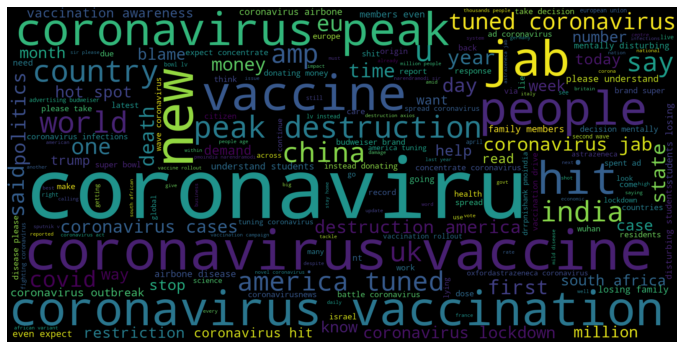

In [37]:
anger_tweets = data[data.label == 'anger']
neg_string = []
for t in anger_tweets.Text:
    neg_string.append(t)
anger_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(anger_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

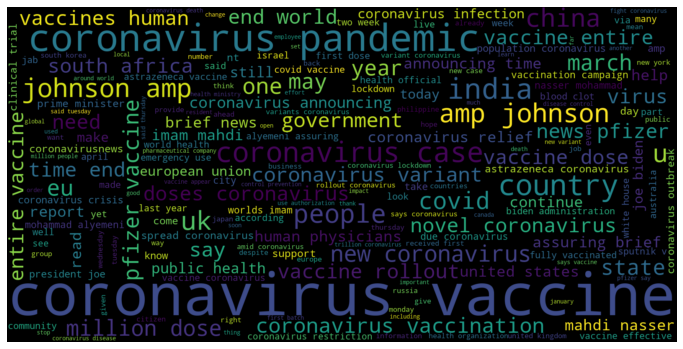

In [38]:
joy_tweets = data[data.label == 'joy']
joy_string = []
for t in joy_tweets.Text:
    joy_string.append(t)
joy_string = pd.Series(joy_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(joy_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [39]:
# detect list columns
data.applymap(lambda x: isinstance(x, list)).all()

Datetime          False
Tweet Id          False
Place             False
Text              False
Username          False
FollowersCount    False
FriendsCount      False
Language          False
Hashtag           False
Retweet Count     False
Likes Count       False
cleaned_Text      False
label             False
dtype: bool

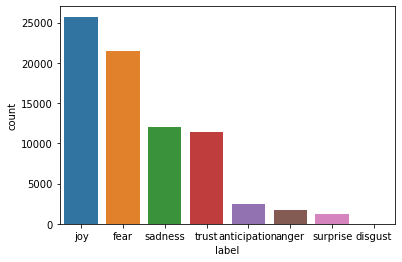

In [40]:
sns.countplot(data= data, x= 'label',
             order = data['label'].value_counts().index);

In [41]:
#trans = str.maketrans('', '', string.punctuation)
#[s.translate(trans) for s in token_words]

#stripped = [w.translate(table) for w in token_words]
#words = [word for word in stripped if word.isalpha()]

In [42]:
#---------Data Pre-processing--------#
#data.applymap(lambda x: x[0] if isinstance(x, list) else x)['Text'].value_counts()
#1. Convert all words to lower case in text
#text= data.Text
#text = str(text)
#text = text.str.lower()

#2. Remove the URL 
#text = text.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
#text = text.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

#3. Removing the Placeholders like links
#text = text.apply(lambda x: re.sub(r'{link}', '', x))
#text = text.apply(lambda x: re.sub(r"\[video\]", '', x))

#4. Removing HTML reference characters
#text = text.apply(lambda x: re.sub(r'&[a-z]+;', '', x))

#5. Remove Non-Letter characters
#text = text.apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

#6. Handling the twitter handles. @mention is used instead of the names and then removing it
#text = text.apply(lambda x: re.sub(r'@mention', '', x))

#data["Text"] = text

#7. Tokenization using TweetTokenizer
# Create a reference variable for Class TweetTokenizer
#tk = TweetTokenizer()
#token_words = text.apply(tk.tokenize)

#word_tokenize = TweetTokenizer().tokenize

#print(token_words)
#--Stop Words--#
#stoplist = set(stopwords.words("english"))
#data['filtered_text'] = data['Text'].astype(str).apply(lambda line: [token for token in word_tokenize(line) if token not in stoplist])


#table = str.maketrans('', '', string.punctuation)
#stripped = [w.translate(table) for w in tokens]
#words = [word for word in stripped if word.isalpha()]
#train_pos_no_punctuation = remove_punctuation(text)


In [43]:
#Find the top words in the tweet
#applying count vectorizer

#countVectorizer = CountVectorizer()
#countVector = countVectorizer.fit_transform(data['Text'])
#print('{} Number of tweets have {} words'.format(countVector.shape[0], countVector.shape[1]))

#count_vect_df = pd.DataFrame(countVector.toarray(), columns = countVectorizer.get_feature_names())
#count_vect_df

In [44]:
#most frequently used words in the tweets
#counts = pd.DataFrame(count_vect_df.sum())
#count_df = counts.sort_values(0, ascending = False).head(10)
#count_df

In [45]:
#------Spliting the DataSet------#
#The Pre-processed Data is divided into 2 sets of data
#Training Data: The dataset upon which the model would be trained on. Contains 95% data
#Test Data: The dataset upon which the model would be tested against. Contains 5% data

X_data, y_data = np.array(data['Text']), np.array(data['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.3, random_state = 0)
print('Data Split done successfully')


Data Split done successfully


In [46]:
#Create word embedding using word2vec 
Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [47]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 12889
Wall time: 5.56 s


In [48]:
word2vec_model.save("old_w2vModel.model")

In [49]:
# Defining the model input length.
input_length = 60 #can use 500

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
#Defining the Tokenizer and fitting it on the training data. Here, we are tokenzing the data by spliting it up with the delimiter space
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [51]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

#y_train = pad_sequences(tokenizer.texts_to_sequences(y_train), maxlen=input_length)
#y_test  = pad_sequences(tokenizer.texts_to_sequences(y_test) , maxlen=input_length)


print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (53124, 60)
X_test.shape : (22768, 60)


In [52]:
#Creating Embedding Matrix
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [53]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    log("")
    log("===============================================")
    classifier_name = str(type(classifier).__name__)
    log("Testing " + classifier_name)
    now = time()
    '''
    #----------------------------------------------
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    y_train = np.vstack(y_train)
    y_test = np.vstack(y_test)
    #----------------------------------------------
    '''
    list_of_labels = sorted(list(set(y_train)))
    
    model = classifier.fit(X_train, y_train)
    log("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    log("Predicting time {0}s".format(time() - now))

    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    log("=================== Results ===================")
    print("           joy          fear       sadness  trust    anticipation   anger   surprise   disgust")
    log("F1       " + str(f1))
    log("Precision" + str(precision))
    log("Recall   " + str(recall))
    log("Accuracy " + str(accuracy))
    log("===============================================")

    return precision, recall, accuracy, f1

def log(x):
    #can be used to write to log file
    print(x)

In [54]:
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape :", y_test.shape)

X_train.shape: (53124, 60)
X_test.shape : (22768, 60)
y_train.shape: (53124,)
y_test.shape : (22768,)


In [55]:
#Use vstack to fix the ValueError: Please reshape the input data into 2-dimensional matrix

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
y_train = list(y_train)

#y_train = hash(y_train)
#y_test = np.vstack(y_test)

precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, XGBoostClassifier(seed=seed))


Testing XGBClassifier


C:\Users\Naveena\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learing time 70.66852331161499s
Predicting time 0.10784482955932617s
=================== Results ===================
           joy          fear       sadness  trust    anticipation   anger   surprise   disgust
F1       [0.35350318 0.37350706 0.         0.59911709 0.64355746 0.40332861
 0.45338983 0.40414297]
Precision[0.96521739 0.92473118 0.         0.54382394 0.55030236 0.54367542
 0.93859649 0.67139001]
Recall   [0.21637427 0.23401361 0.         0.66692668 0.77486776 0.32057416
 0.29888268 0.28907612]
Accuracy 0.5624121574139143


In [56]:
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, RandomForestClassifier(n_estimators=403,n_jobs=-1, random_state=seed))


Testing RandomForestClassifier
Learing time 22.053622722625732s
Predicting time 1.1275708675384521s


C:\Users\Naveena\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=================== Results ===================
           joy          fear       sadness  trust    anticipation   anger   surprise   disgust
F1       [0.4400607  0.44514768 0.         0.61333116 0.62997913 0.39938556
 0.52977413 0.47868132]
Precision[0.99315068 0.99061033 0.         0.64114344 0.48583024 0.9063745
 1.         0.98285199]
Recall   [0.28265107 0.28707483 0.         0.58783151 0.89575539 0.25612159
 0.3603352  0.31638582]
Accuracy 0.5795414617006325


In [57]:
#Accuracy 43%
#precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, KNeighborsClassifier(n_neighbors = 3))

In [58]:
#Less Accuracy
#precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, SVC(kernel='linear'))

In [59]:
#Less Accuracy
#precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, GaussianNB())

In [60]:
#Define Model for LSTM
'''
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model
'''    

'\ndef getModel():\n    embedding_layer = Embedding(input_dim = vocab_length,\n                                output_dim = Embedding_dimensions,\n                                weights=[embedding_matrix],\n                                input_length=input_length,\n                                trainable=False)\n\n    model = Sequential([\n        embedding_layer,\n        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),\n        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),\n        Conv1D(100, 5, activation=\'relu\'),\n        GlobalMaxPool1D(),\n        Dense(16, activation=\'relu\'),\n        Dense(1, activation=\'sigmoid\'),\n    ],\n    name="Sentiment_Model")\n    return model\n'

In [61]:
#Model Summary
'''
training_model = getModel()
training_model.summary()
'''

'\ntraining_model = getModel()\ntraining_model.summary()\n'

In [62]:
#training the model 
'''
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]
             '''

"\ncallbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),\n             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]\n             "

In [63]:
#Compile the model
'''
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])'''

"\ntraining_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])"

In [64]:
'''
y_train = pad_sequences(tokenizer.texts_to_sequences(y_train), maxlen=input_length)
y_test  = pad_sequences(tokenizer.texts_to_sequences(y_test) , maxlen=input_length)

print(X_train.shape)
print(y_train.shape)
'''

'\ny_train = pad_sequences(tokenizer.texts_to_sequences(y_train), maxlen=input_length)\ny_test  = pad_sequences(tokenizer.texts_to_sequences(y_test) , maxlen=input_length)\n\nprint(X_train.shape)\nprint(y_train.shape)\n'

In [65]:
# Our vectorized labels
'''
X_train = np.asarray(X_train).astype('float32').reshape((-1,1))
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))

print(X_train.shape)
print(y_train.shape)
'''

"\nX_train = np.asarray(X_train).astype('float32').reshape((-1,1))\ny_train = np.asarray(y_train).astype('float32').reshape((-1,1))\n\nprint(X_train.shape)\nprint(y_train.shape)\n"

In [66]:
'''
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)
'''

'\nhistory = training_model.fit(\n    X_train, y_train,\n    batch_size=1024,\n    epochs=12,\n    validation_split=0.1,\n    callbacks=callbacks,\n    verbose=1,\n)\n'

In [67]:
'''
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))
'''

"\nacc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']\nloss, val_loss = history.history['loss'], history.history['val_loss']\nepochs = range(len(acc))\n"

In [68]:
'''
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
#ConfusionMatrix(y_pred, y_test)
'''

'\n# Predicting on the Test dataset.\ny_pred = training_model.predict(X_test)\n\n# Converting prediction to reflect the sentiment predicted.\ny_pred = np.where(y_pred>=0.5, 1, 0)\n\n# Printing out the Evaluation metrics. \n#ConfusionMatrix(y_pred, y_test)\n'

In [69]:
'''
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
'''

'\n# Print the evaluation metrics for the dataset.\nprint(classification_report(y_test, y_pred))\n'